# Seminar Notebook 2022: Financial Data Analytics
# Gilbert Böhme

# 1. Import and Install Packages

In [1]:
!pip install pysentiment2
!pip install tweet-preprocessor
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install mlxtend

In [2]:
import numpy as np
import preprocessor as p
import string
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pylab as pl
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_learning_curves
from sklearn.feature_extraction.text import TfidfVectorizer

# read data
conn = sqlite3.connect('twitterStream_final.db')
tweets_df = pd.read_sql('SELECT * FROM tweets', conn)
pd.set_option("display.max_colwidth", -1)

/var/folders/5q/_fcxw0093zz6mbncm4kcrzfw0000gn/T/ipykernel_70045/719009282.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [3]:
nltk.download('stopwords')

lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gilbert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Start Preprocessing

In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269325 entries, 0 to 269324
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               269325 non-null  int64  
 1   user_name             269325 non-null  object 
 2   user_followers_count  269325 non-null  int64  
 3   user_friends_count    269325 non-null  int64  
 4   tweet                 269325 non-null  object 
 5   tweet_id              269325 non-null  int64  
 6   created_at            269325 non-null  object 
 7   tweet_lang            269325 non-null  object 
 8   ot_retweet_count      123042 non-null  float64
 9   ot_retweet_time       123042 non-null  object 
 10  ot_id                 123042 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 22.6+ MB


In [5]:
tweets_df.describe()

user_id  user_followers_count  user_friends_count      tweet_id  \
count  2.693250e+05  2.693250e+05          269325.000000       2.693250e+05   
mean   8.872829e+17  7.640365e+03          1054.248803         1.460604e+18   
std    6.061405e+17  1.728837e+05          5619.620741         2.631538e+15   
min    3.240000e+02  0.000000e+00          0.000000            1.456234e+18   
25%    2.603182e+09  3.800000e+01          37.000000           1.458203e+18   
50%    1.223575e+18  2.410000e+02          199.000000          1.460621e+18   
75%    1.388894e+18  1.535000e+03          825.000000          1.462818e+18   
max    1.465630e+18  2.398648e+07          442679.000000       1.465637e+18   

       ot_retweet_count         ot_id  
count  123042.000000     1.230420e+05  
mean   742.460591        1.459241e+18  
std    1620.424962       1.370650e+16  
min    1.000000          3.344437e+17  
25%    2.000000          1.457929e+18  
50%    14.000000         1.459807e+18  
75%    368.000000        1.462076e+18  
max    8766.000000       1.465636e+18

In [6]:
tweets_df['tweet_cleaned'] = ''
tweets_df['tweet_cleaned']= tweets_df['tweet']
text = tweets_df['tweet_cleaned']
tweets_df['fintags'] = [[re.sub('\$|[0-9]', '', w) for w in re.findall('\$\w+', t)] for t in text]
tweets_df = tweets_df[['user_id','user_name','user_followers_count','user_friends_count','tweet_id','tweet','tweet_cleaned','fintags','created_at','ot_retweet_count','ot_retweet_time','ot_id','tweet_lang']]

In [7]:
def preprocess_tweets(column):
    text = column['tweet']
    text = text.lower()
    text = p.clean(text)
    text = re.sub(r'https\S+', '',text)
    text = re.sub('\$\w+', '', text)
    text = re.sub('\d+', '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ') # keep words with length>1 only
    text = re.sub('@[A-Za-z0-9]+','', text)
    text = re.sub('\[0-9]','', text)
    text = re.sub('\%|\:|\-|\,|\/|\.|\'|\~|\?|\;\(|\)|\!|\+|\*|','', text)
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    return text

In [8]:
tweets_df['tweet_cleaned'] = tweets_df.apply(preprocess_tweets, axis=1)

In [9]:
tweets_df['fintags']=tweets_df['fintags'].astype(str)

In [10]:
def preprocess_tweets_2(column):
    text = column['fintags']
    text = text.lower()
    text = p.clean(text)
    text = re.sub('\[|\]|','',text)
    text = re.sub('\'|\'|','',text)
    text = re.sub('\ ,','',text)
    return text

In [11]:
tweets_df['fintags'] = tweets_df.apply(preprocess_tweets_2, axis=1)

In [12]:
value = ['']
tweets_df = tweets_df[tweets_df.fintags.isin(value) == False]

In [13]:
value = ['']
tweets_df = tweets_df[tweets_df.tweet_cleaned.isin(value) == False]

In [14]:
tweets_df[['date','time']] = tweets_df['created_at'].str.split(' ', expand=True)

user_id                                         user_name  \
3   100185304            Artificial Intelligence Biotechnology Researcher   
4   1385267156           Duke of Fantom👻                                    
18  1345524809141276672  Johan Pétros Ruela                                 
37  1404250024104628226  ÁREA                                               
42  1455896200499109894  Cousin Cletus                                      

    user_followers_count  user_friends_count             tweet_id  \
3   4658                  3955                1456233727655297033   
4   118                   1166                1456233728561221638   
18  68                    231                 1456233900435443717   
37  33                    1                   1456234075119890439   
42  0                     6                   1456234161979727879   

                                                                                                                                           tweet  \
3   RT @MacaoChina: Covid19 Vaccine Maker $IBIO  Ibio shares are trading higher after the company reported the purchase of a FastPharming manuf…   
4   @crypto_blkbeard $DIS @TosdisFinance . Thank me later                                                                                          
18  RT @defichain: $TSLA $AAPL $AMZN there is no limit! \n\nPick your 3 favorite stocks 👇 https://t.co/qVrO81avN2                                  
37  Don’t let $MCD pass you up 😉                                                                                                                   
42  I like $BA $230 11/12 based off FCC approval for satellite internet and gap fill up to $222 despite downtrend on 18… https://t.co/pbd6OQiLVk   

                                                                                  tweet_cleaned  \
3   covid vaccine maker ibio shares trading higher company reported purchase fastpharming manuf   
4   thank later                                                                                   
18  limit pick favorite stocks                                                                    
37  dont let pass                                                                                 
42  like based fcc approval satellite internet gap fill despite downtrend                         

             fintags                 created_at  ot_retweet_count  \
3   ibio              2021-11-04 12:15:50+00:00  1.0                
4   dis               2021-11-04 12:15:51+00:00 NaN                 
18  tsla, aapl, amzn  2021-11-04 12:16:32+00:00  28.0               
37  mcd               2021-11-04 12:17:13+00:00 NaN                 
42  ba,               2021-11-04 12:17:34+00:00 NaN                 

              ot_retweet_time         ot_id tweet_lang        date  \
3   2021-11-04 11:51:23+00:00  1.456228e+18  en         2021-11-04   
4   None                      NaN            en         2021-11-04   
18  2021-11-04 08:48:26+00:00  1.456182e+18  en         2021-11-04   
37  None                      NaN            en         2021-11-04   
42  None                      NaN            en         2021-11-04   

              time  
3   12:15:50+00:00  
4   12:15:51+00:00  
18  12:16:32+00:00  
37  12:17:13+00:00  
42  12:17:34+00:00

In [15]:
tweets_df_sorted = tweets_df.sort_values(['ot_retweet_count'], ascending=False)
tweets_df_sorted[:5]

user_id              user_name  user_followers_count  \
269294  1439670095786151936  Neydahnik              1                      
269090  385917699            Büşra Yılmaz           84                     
267127  1218779769254187008  Cholilurr              17                     
266558  1417823000485715973  Thiện                  3                      
268734  1260187493703585793  sinamo                 65                     
266550  1458492295838306304  AKE#RTE #LydiaFinance  13                     
265569  1418553065305780225  kripto #CRO            6                      
268706  1365667132013498369  Ilyas                  36                     
264775  1452718866933682176  Fatih Çelik            13                     
264266  1460533603553710082  Ahmet İleri            7                      
263605  1483195526           Erdal                  3                      
268590  1382732285607313416  Amanda Bourque         9                      
263555  882976810924986369   Abdullah Furkan        3                      
263504  1291340118834515970  BiBakipCikacam         27                     
261868  1136370591517290496  Joe Gambiste           14647                  
261817  631255730            Максим                 14                     
261591  2531668161           Freedomdr              136                    
261580  1359484215893590017  Александр              0                      
268242  1362071617745154049  Oma                    1                      
261550  535866607            Mustafa TAŞTAN         27                     

        user_friends_count             tweet_id  \
269294  48                  1465634610239442944   
269090  215                 1465622225059524609   
267127  277                 1465507894401519619   
266558  255                 1465484635056402438   
268734  1619                1465597063664750593   
266550  297                 1465484357649502213   
265569  144                 1465453620560908297   
268706  103                 1465594296195768320   
264775  66                  1465435702498369547   
264266  369                 1465425388197322764   
263605  400                 1465412278115880976   
268590  91                  1465587751793803265   
263555  86                  1465411633002557442   
263504  266                 1465410900878413833   
261868  0                   1465386484207341574   
261817  94                  1465385457701867524   
261591  425                 1465381463763963908   
261580  9                   1465381312806764550   
268242  84                  1465566810732994562   
261550  119                 1465380842755313671   

                                                                                                                                                   tweet  \
269294  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is your favorite?\n \n$SOL $RON $ENS $METIS $UNI $M…   
269090  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is your favorite?\n \n$SOL $RON $ENS $METIS $UNI $M…   
267127  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is your favorite?\n \n$SOL $RON $ENS $METIS $UNI $M…   
266558  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is your favorite?\n \n$SOL $RON $ENS $METIS $UNI $M…   
268734  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is your favorite?\n \n$SOL $RON $ENS $METIS $UNI $M…   
266550  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is your favorite?\n \n$SOL $RON $ENS $METIS $UNI $M…   
265569  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is your favorite?\n \n$SOL $RON $ENS $METIS $UNI $M…   
268706  RT @Coin98Insights: Let’s have a look at some hottest events during last week.\n\nWhich one is 

In [16]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212233 entries, 3 to 269323
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               212233 non-null  int64  
 1   user_name             212233 non-null  object 
 2   user_followers_count  212233 non-null  int64  
 3   user_friends_count    212233 non-null  int64  
 4   tweet_id              212233 non-null  int64  
 5   tweet                 212233 non-null  object 
 6   tweet_cleaned         212233 non-null  object 
 7   fintags               212233 non-null  object 
 8   created_at            212233 non-null  object 
 9   ot_retweet_count      90740 non-null   float64
 10  ot_retweet_time       90740 non-null   object 
 11  ot_id                 90740 non-null   float64
 12  tweet_lang            212233 non-null  object 
 13  date                  212233 non-null  object 
 14  time                  212233 non-null  object 
dtype

# 3. Descriptive Analysis

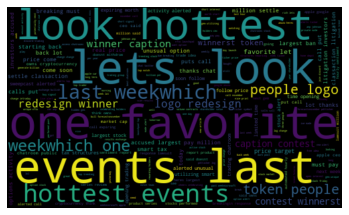

In [17]:
allWords = ' '.join([twts for twts in tweets_df['tweet_cleaned']])
wordCloud = WordCloud(background_color="black",width = 500, height=300, random_state=0, max_font_size =119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

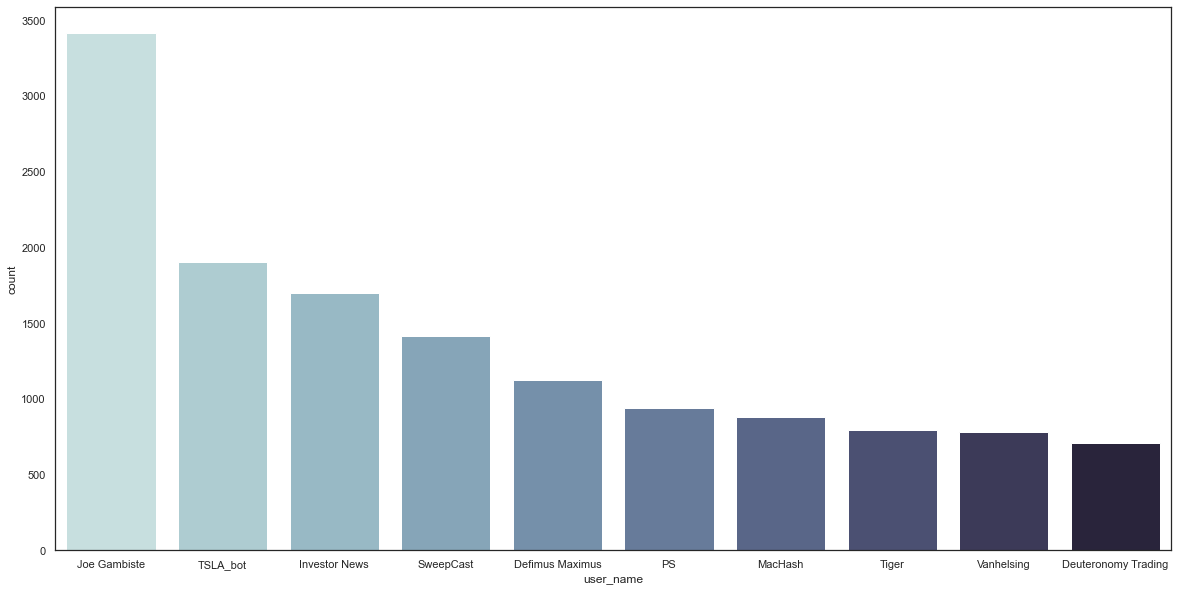

In [18]:
plt.figure(figsize=(20,10))
sns.set(style="white")
ax = sns.countplot(x="user_name", data=tweets_df, palette="ch:start=.2,rot=-.3", order=tweets_df['user_name'].value_counts().index[0:10])

In [19]:
amount_per_day = pd.DataFrame(tweets_df, columns=["tweet_cleaned"])

In [20]:
amount_per_day.index = pd.to_datetime(tweets_df['date'])

In [21]:
amount_per_day.sort_index()

tweet_cleaned
date                                                                                                        
2021-11-04  covid vaccine maker ibio shares trading higher company reported purchase fastpharming manuf     
2021-11-04  thank later                                                                                     
2021-11-04  limit pick favorite stocks                                                                      
2021-11-04  dont let pass                                                                                   
2021-11-04  like based fcc approval satellite internet gap fill despite downtrend                           
...                   ...                                                                                   
2021-11-30  mentioned news feed per spinoff                                                                 
2021-11-30  basic arbitrage would going opposite direction industry two different assets would good examplet
2021-11-30  cheers celebrating holders                                                                      
2021-11-30  watch vaccine stocks monday                                                                     
2021-11-30  head public health agency says severity disease omicron cases mild                              

[212233 rows x 1 columns]

In [22]:
#daily postings range
amount_per_day_2=amount_per_day.groupby(lambda x: x.date).count()
amount_per_day_2.sort_values(by=['tweet_cleaned'])

tweet_cleaned
2021-11-30  2678         
2021-11-13  3334         
2021-11-21  3554         
2021-11-14  3666         
2021-11-27  4054         
2021-11-25  4075         
2021-11-20  4346         
2021-11-06  4981         
2021-11-28  5041         
2021-11-07  5252         
2021-11-04  5816         
2021-11-26  6933         
2021-11-24  7839         
2021-11-05  8261         
2021-11-23  8994         
2021-11-08  9090         
2021-11-12  9313         
2021-11-11  9613         
2021-11-15  9623         
2021-11-29  9786         
2021-11-10  10436        
2021-11-19  10770        
2021-11-22  11177        
2021-11-17  12011        
2021-11-18  12577        
2021-11-09  14203        
2021-11-16  14810

In [23]:
new_list = tweets_df['fintags']
vectorizer = CountVectorizer(analyzer = 'word', stop_words = 'english',ngram_range=(1,5))
vectorizer.fit(new_list)
bag_of_words = vectorizer.transform(new_list)

In [24]:
sum_fintags = bag_of_words.sum(axis=0) 
fintags_freq = [(word, sum_fintags[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
fintags_freq =sorted(fintags_freq, key = lambda x: x[1], reverse=True)
fintags_freq[:500]

[('aapl', 53472),
 ('cat', 25011),
 ('tsla', 20358),
 ('msft', 17368),
 ('dis', 15867),
 ('ba', 13184),
 ('cat cat', 12763),
 ('amzn', 12417),
 ('spy', 10327),
 ('sol', 10012),
 ('nvda', 9935),
 ('uni', 9479),
 ('ens', 9268),
 ('metis', 9129),
 ('ron', 9127),
 ('sol ron', 9126),
 ('ron ens', 9124),
 ('sol ron ens', 9124),
 ('ens metis', 9122),
 ('ron ens metis', 9122),
 ('sol ron ens metis', 9122),
 ('metis uni', 9092),
 ('ens metis uni', 9092),
 ('ron ens metis uni', 9092),
 ('sol ron ens metis uni', 9092),
 ('fb', 8944),
 ('cvx', 8014),
 ('jpm', 7636),
 ('wmt', 7044),
 ('amd', 6928),
 ('hd', 6846),
 ('cat cat cat', 6328),
 ('googl', 6279),
 ('gs', 5745),
 ('lcid', 4982),
 ('qqq', 4947),
 ('btc', 4673),
 ('eth', 4644),
 ('intc', 4520),
 ('jnj', 4331),
 ('mrk', 4234),
 ('amc', 4229),
 ('pypl', 3999),
 ('vz', 3757),
 ('nke', 3384),
 ('aapl tsla', 3274),
 ('crm', 3166),
 ('shib', 3059),
 ('pfe', 2991),
 ('rblx', 2851),
 ('gme', 2836),
 ('csco', 2809),
 ('crv', 2799),
 ('aapl amzn', 2792)

In [25]:
fintags=pd.DataFrame(tweets_df['fintags'])

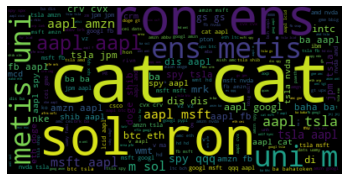

In [26]:
allWords = ' '.join([twts for twts in tweets_df['fintags']])
wordCloud = WordCloud(background_color="black").generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [27]:
new_list_words = tweets_df['tweet_cleaned']
vectorizer = CountVectorizer(analyzer = 'word', stop_words = 'english')
vectorizer.fit(new_list_words)
bag_of_words = vectorizer.transform(new_list_words)

{'covid': 6944, 'vaccine': 32894, 'maker': 18075, 'ibio': 14602, 'shares': 27333, 'trading': 31544, 'higher': 13954, 'company': 6161, 'reported': 25401, 'purchase': 24235, 'fastpharming': 11103, 'manuf': 18194, 'thank': 30450, 'later': 16823, 'limit': 17279, 'pick': 22639, 'favorite': 11131, 'stocks': 29063, 'dont': 9022, 'let': 17076, 'pass': 22115, 'like': 17250, 'based': 2555, 'fcc': 11154, 'approval': 1558, 'satellite': 26589, 'internet': 15582, 'gap': 12465, 'despite': 8279, 'downtrend': 9146, 'trades': 31510, 'regulators': 25118, 'grant': 13084, 'oral': 21461, 'antiviral': 1399, 'treatment': 31711, 'short': 27528, 'sale': 26483, 'volume': 33303, 'fisker': 11496, 'highlights': 13978, 'launch': 16848, 'plans': 22856, 'using': 32827, 'newswire': 20375, 'new': 20318, 'drilling': 9243, 'program': 23848, 'announced': 1308, 'axp': 2252, 'team': 30172, 'people': 22381, 'kentucky': 16408, 'ope': 21303, 'looks': 17660, 'ready': 24732, 'leap': 16946, 'forward': 11935, 'coming': 6032, 'soon'

In [28]:
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:10]

[('look', 11180),
 ('lets', 11087),
 ('amp', 10471),
 ('favorite', 9469),
 ('events', 9167),
 ('hottest', 9129),
 ('weekwhich', 9100),
 ('price', 8885),
 ('today', 8636),
 ('people', 8496),
 ('stocks', 8467),
 ('calls', 7963),
 ('stock', 7839),
 ('token', 7343),
 ('apple', 7297),
 ('new', 7205),
 ('winner', 7046),
 ('buy', 6597),
 ('week', 6521),
 ('contest', 6361),
 ('logo', 6331),
 ('caption', 6312),
 ('redesign', 6311),
 ('winnerst', 6310),
 ('market', 5811),
 ('like', 5523),
 ('day', 5447),
 ('time', 5393),
 ('trading', 4786),
 ('puts', 4461),
 ('earnings', 4431),
 ('million', 4240),
 ('big', 4088),
 ('short', 4044),
 ('trade', 4032),
 ('alerts', 3946),
 ('soon', 3877),
 ('free', 3814),
 ('good', 3720),
 ('alert', 3667),
 ('come', 3601),
 ('largest', 3566),
 ('options', 3553),
 ('flow', 3523),
 ('thanks', 3410),
 ('volume', 3332),
 ('news', 3319),
 ('pay', 3220),
 ('alerted', 3218),
 ('shares', 3190),
 ('dont', 3150),
 ('long', 3149),
 ('ceo', 3101),
 ('best', 3091),
 ('bullish', 3

# 4. Detection of tweet specific moods by applying the Loughran & McDonald dictionary

In [29]:
lmdict = {'Negative': ["abandon","abandoned","abandoning","abandonment","abandonments","abandons",
                       "abdicated","abdicates","abdicating","abdication","abdications","aberrant",
                       "aberration","aberrational","aberrations","abetting","abnormal","abnormalities",
                       "abnormality","abnormally","abolish","abolished","abolishes","abolishing","abrogate",
                       "abrogated","abrogates","abrogating","abrogation","abrogations","abrupt","abruptly",
                       "abruptness","absence","absences","absenteeism","abuse","abused","abuses","abusing",
                       "abusive","abusively","abusiveness","accident","accidental","accidentally","accidents",
                       "accusation","accusations","accuse","accused","accuses","accusing","acquiesce","acquiesced",
                       "acquiesces","acquiescing","acquit","acquits","acquittal","acquittals","acquitted","acquitting",
                       "adulterate","adulterated","adulterating","adulteration","adulterations","adversarial","adversaries",
                       "adversary","adverse","adversely","adversities","adversity","aftermath","aftermaths","against","aggravate",
                       "aggravated","aggravates","aggravating","aggravation","aggravations","alerted","alerting","alienate","alienated",
                       "alienates","alienating","alienation","alienations","allegation","allegations","allege","alleged","allegedly",
                       "alleges","alleging","annoy","annoyance","annoyances","annoyed","annoying","annoys","annul","annulled",
                       "annulling","annulment","annulments","annuls","anomalies","anomalous","anomalously","anomaly","anticompetitive",
                       "antitrust","argue","argued","arguing","argument","argumentative","arguments","arrearage","arrearages","arrears",
                       "arrest","arrested","arrests","artificially","assault","assaulted","assaulting","assaults","assertions","attrition","aversely","backdating","bad","bail","bailout","balk","balked","bankrupt","bankruptcies","bankruptcy","bankrupted","bankrupting","bankrupts","bans","barred","barrier","barriers","bottleneck","bottlenecks","boycott","boycotted","boycotting","boycotts","breach","breached","breaches","breaching","break","breakage","breakages","breakdown","breakdowns","breaking","breaks","bribe","bribed","briberies","bribery","bribes","bribing","bridge","broken","burden","burdened","burdening","burdens","burdensome","burned","calamities","calamitous","calamity","cancel","canceled","canceling","cancellation","cancellations","cancelled","cancelling","cancels","careless","carelessly","carelessness","catastrophe","catastrophes","catastrophic","catastrophically","caution","cautionary","cautioned","cautioning","cautions","cease","ceased","ceases","ceasing","censure","censured","censures","censuring","challenge","challenged","challenges","challenging","chargeoffs","circumvent","circumvented","circumventing","circumvention","circumventions","circumvents","claiming","claims","clawback","closed","closeout","closeouts","closing","closings","closure","closures","coerce","coerced","coerces","coercing","coercion","coercive","collapse","collapsed","collapses","collapsing","collision","collisions","collude","colluded","colludes","colluding","collusion","collusions","collusive","complain","complained","complaining","complains","complaint","complaints","complicate","complicated","complicates","complicating","complication","complications","compulsion","concealed","concealing","concede","conceded","concedes","conceding","concern","concerned","concerns","conciliating","conciliation","conciliations","condemn","condemnation","condemnations","condemned","condemning","condemns","condone","condoned","confess","confessed","confesses","confessing","confession","confine","confined","confinement","confinements","confines","confining","confiscate","confiscated","confiscates","confiscating","confiscation","confiscations","conflict","conflicted","conflicting","conflicts","confront","confrontation","confrontational","confrontations","confronted","confronting","confronts","confuse","confused","confuses","confusing","confusingly","confusion","conspiracies","conspiracy","conspirator","conspiratorial","conspirators","conspire","conspired","conspires","conspiring","contempt","contend","contended","contending","contends","contention","contentions","contentious","contentiously","contested","contesting","contraction","contractions","contradict","contradicted","contradicting","contradiction","contradictions","contradictory","contradicts","contrary","controversial","controversies","controversy","convict","convicted","convicting","conviction","convictions","corrected","correcting","correction","corrections","corrects","corrupt","corrupted","corrupting","corruption","corruptions","corruptly","corruptness","costly","counterclaim","counterclaimed","counterclaiming","counterclaims","counterfeit","counterfeited","counterfeiter","counterfeiters","counterfeiting","counterfeits","countermeasure","countermeasures","crime","crimes","criminal","criminally","criminals","crises","crisis","critical","critically","criticism","criticisms","criticize","criticized","criticizes","criticizing","crucial","crucially","culpability","culpable","culpably","cumbersome","curtail","curtailed","curtailing","curtailment","curtailments","curtails","cut","cutback","cutbacks","cyberattack","cyberattacks","cyberbullying","cybercrime","cybercrimes","cybercriminal","cybercriminals","damage","damaged","damages","damaging","dampen","dampened","danger","dangerous","dangerously","dangers","deadlock","deadlocked","deadlocking","deadlocks","deadweight","deadweights","debarment","debarments","debarred","deceased","deceit","deceitful","deceitfulness","deceive","deceived","deceives","deceiving","deception","deceptions","deceptive","deceptively","decline","declined","declines","declining","deface","defaced","defacement","defamation","defamations","defamatory","defame","defamed","defames","defaming","default","defaulted","defaulting","defaults","defeat","defeated","defeating","defeats","defect","defective","defects","defend","defendant","defendants","defended","defending","defends","defensive","defer","deficiencies","deficiency","deficient","deficit","deficits","defraud","defrauded","defrauding","defrauds","defunct","degradation","degradations","degrade","degraded","degrades","degrading","delay","delayed","delaying","delays","deleterious","deliberate","deliberated","deliberately","delinquencies","delinquency","delinquent","delinquently","delinquents","delist","delisted","delisting","delists","demise","demised","demises","demising","demolish","demolished","demolishes","demolishing","demolition","demolitions","demote","demoted","demotes","demoting","demotion","demotions","denial","denials","denied","denies","denigrate","denigrated","denigrates","denigrating","denigration","deny","denying","deplete","depleted","depletes","depleting","depletion","depletions","deprecation","depress","depressed","depresses","depressing","deprivation","deprive","deprived","deprives","depriving","derelict","dereliction","derogatory","destabilization","destabilize","destabilized","destabilizing","destroy","destroyed","destroying","destroys","destruction","destructive","detain","detained","detention","detentions","deter","deteriorate","deteriorated","deteriorates","deteriorating","deterioration","deteriorations","deterred","deterrence","deterrences","deterrent","deterrents","deterring","deters","detract","detracted","detracting","detriment","detrimental","detrimentally","detriments","devalue","devalued","devalues","devaluing","devastate","devastated","devastating","devastation","deviate","deviated","deviates","deviating","deviation","deviations","devolve","devolved","devolves","devolving","difficult","difficulties","difficultly","difficulty","diminish","diminished","diminishes","diminishing","diminution","disadvantage","disadvantaged","disadvantageous","disadvantages","disaffiliation","disagree","disagreeable","disagreed","disagreeing","disagreement","disagreements","disagrees","disallow","disallowance","disallowances","disallowed","disallowing","disallows","disappear","disappearance","disappearances","disappeared","disappearing","disappears","disappoint","disappointed","disappointing","disappointingly","disappointment","disappointments","disappoints","disapproval","disapprovals","disapprove","disapproved","disapproves","disapproving","disassociates","disassociating","disassociation","disassociations","disaster","disasters","disastrous","disastrously","disavow","disavowal","disavowed","disavowing","disavows","disciplinary","disclaim","disclaimed","disclaimer","disclaimers","disclaiming","disclaims","disclose","disclosed","discloses","disclosing","discontinuance","discontinuances","discontinuation","discontinuations","discontinue","discontinued","discontinues","discontinuing","discourage","discouraged","discourages","discouraging","discredit","discredited","discrediting","discredits","discrepancies","discrepancy","disfavor","disfavored","disfavoring","disfavors","disgorge","disgorged","disgorgement","disgorgements","disgorges","disgorging","disgrace","disgraceful","disgracefully","dishonest","dishonestly","dishonesty","dishonor","dishonorable","dishonorably","dishonored","dishonoring","dishonors","disincentives","disinterested","disinterestedly","disinterestedness","disloyal","disloyally","disloyalty","dismal","dismally","dismiss","dismissal","dismissals","dismissed","dismisses","dismissing","disorderly","disparage","disparaged","disparagement","disparagements","disparages","disparaging","disparagingly","disparities","disparity","displace","displaced","displacement","displacements","displaces","displacing","dispose","dispossess","dispossessed","dispossesses","dispossessing","disproportion","disproportional","disproportionate","disproportionately","dispute","disputed","disputes","disputing","disqualification","disqualifications","disqualified","disqualifies","disqualify","disqualifying","disregard","disregarded","disregarding","disregards","disreputable","disrepute","disrupt","disrupted","disrupting","disruption","disruptions","disruptive","disrupts","dissatisfaction","dissatisfied","dissent","dissented","dissenter","dissenters","dissenting","dissents","dissident","dissidents","dissolution","dissolutions","distort","distorted","distorting","distortion","distortions","distorts","distract","distracted","distracting","distraction","distractions","distracts","distress","distressed","disturb","disturbance","disturbances","disturbed","disturbing","disturbs","diversion","divert","diverted","diverting","diverts","divest","divested","divesting","divestiture","divestitures","divestment","divestments","divests","divorce","divorced","divulge","divulged","divulges","divulging","doubt","doubted","doubtful","doubts","downgrade","downgraded","downgrades","downgrading","downsize","downsized","downsizes","downsizing","downsizings","downtime","downtimes","downturn","downturns","downward","downwards","drag","drastic","drastically","drawback","drawbacks","dropped","drought","droughts","duress","dysfunction","dysfunctional","dysfunctions","easing","egregious","egregiously","embargo","embargoed","embargoes","embargoing","embarrass","embarrassed","embarrasses","embarrassing","embarrassment","embarrassments","embezzle","embezzled","embezzlement","embezzlements","embezzler","embezzles","embezzling","encroach","encroached","encroaches","encroaching","encroachment","encroachments","encumber","encumbered","encumbering","encumbers","encumbrance","encumbrances","endanger","endangered","endangering","endangerment","endangers","enjoin","enjoined","enjoining","enjoins","erode","eroded","erodes","eroding","erosion","erratic","erratically","erred","erring","erroneous","erroneously","error","errors","errs","escalate","escalated","escalates","escalating","evade","evaded","evades","evading","evasion","evasions","evasive","evict","evicted","evicting","eviction","evictions","evicts","exacerbate","exacerbated","exacerbates","exacerbating","exacerbation","exacerbations","exaggerate","exaggerated","exaggerates","exaggerating","exaggeration","excessive","excessively","exculpate","exculpated","exculpates","exculpating","exculpation","exculpations","exculpatory","exonerate","exonerated","exonerates","exonerating","exoneration","exonerations","exploit","exploitation","exploitations","exploitative","exploited","exploiting","exploits","expose","exposed","exposes","exposing","expropriate","expropriated","expropriates","expropriating","expropriation","expropriations","expulsion","expulsions","extenuating","fail","failed","failing","failings","fails","failure","failures","fallout","falsch","falsely","falsification","falsifications","falsified","falsifies","falsify","falsifying","falsity","fatalities","fatality","fatally","fault","faulted","faults","faulty","fear","fears","felonies","felonious","felony","fictitious","fined","fines","fired","firing","flaw","flawed","flaws","forbid","forbidden","forbidding","forbids","force","forced","forcing","foreclose","foreclosed","forecloses","foreclosing","foreclosure","foreclosures","forego","foregoes","foregone","forestall","forestalled","forestalling","forestalls","forfeit","forfeited","forfeiting","forfeits","forfeiture","forfeitures","forgers","forgery","fraud","frauds","fraudulence","fraudulent","fraudulently","frivolous","frivolously","frustrate","frustrated","frustrates","frustrating","frustratingly","frustration","frustrations","fugitive","fugitives","gratuitous","gratuitously","grievance","grievances","grossly","groundless","guilty","halt","halted","hamper","hampered","hampering","hampers","harass","harassed","harassing","harassment","hardship","hardships","harm","harmed","harmful","harmfully","harming","harms","harsh","harsher","harshest","harshly","harshness","hazard","hazardous","hazards","hinder","hindered","hindering","hinders","hindrance","hindrances","hostile","hostility","hurt","hurting","idle","idled","idling","ignore","ignored","ignores","ignoring","ill","illegal","illegalities","illegality","illegally","illegible","illicit","illicitly","illiquid","illiquidity","imbalance","imbalances","immature","immoral","impair","impaired","impairing","impairment","impairments","impairs","impasse","impasses","impede","impeded","impedes","impediment","impediments","impeding","impending","imperative","imperfection","imperfections","imperil","impermissible","implicate","implicated","implicates","implicating","impossibility","impossible","impound","impounded","impounding","impounds","impracticable","impractical","impracticalities","impracticality","imprisonment","improper","improperly","improprieties","impropriety","imprudent","imprudently","inability","inaccessible","inaccuracies","inaccuracy","inaccurate","inaccurately","inaction","inactions","inactivate","inactivated","inactivates","inactivating","inactivation","inactivations","inactivity","inadequacies","inadequacy","inadequate","inadequately","inadvertent","inadvertently","inadvisability","inadvisable","inappropriate","inappropriately","inattention","incapable","incapacitated","incapacity","incarcerate","incarcerated","incarcerates","incarcerating","incarceration","incarcerations","incidence","incidences","incident","incidents","incompatibilities","incompatibility","incompatible","incompetence","incompetency","incompetent","incompetently","incompetents","incomplete","incompletely","incompleteness","inconclusive","inconsistencies","inconsistency","inconsistent","inconsistently","inconvenience","inconveniences","inconvenient","incorrect","incorrectly","incorrectness","indecency","indecent","indefeasible","indefeasibly","indict","indictable","indicted","indicting","indictment","indictments","ineffective","ineffectively","ineffectiveness","inefficiencies","inefficiency","inefficient","inefficiently","ineligibility","ineligible","inequitable","inequitably","inequities","inequity","inevitable","inexperience","inexperienced","inferior","inflicted","infraction","infractions","infringe","infringed","infringement","infringements","infringes","infringing","inhibited","inimical","injunction","injunctions","injure","injured","injures","injuries","injuring","injurious","injury","inordinate","inordinately","inquiry","insecure","insensitive","insolvencies","insolvency","insolvent","instability","insubordination","insufficiency","insufficient","insufficiently","insurrection","insurrections","intentional","interfere","interfered","interference","interferences","interferes","interfering","intermittent","intermittently","interrupt","interrupted","interrupting","interruption","interruptions","interrupts","intimidation","intrusion","invalid","invalidate","invalidated","invalidates","invalidating","invalidation","invalidity","investigate","investigated","investigates","investigating","investigation","investigations","involuntarily","involuntary","irreconcilable","irreconcilably","irrecoverable","irrecoverably","irregular","irregularities","irregularity","irregularly","irreparable","irreparably","irreversible","jeopardize","jeopardized","justifiable","kickback","kickbacks","knowingly","lack","lacked","lacking","lackluster","lacks","lag","lagged","lagging","lags","lapse","lapsed","lapses","lapsing","late","laundering","layoff","layoffs","lie","limitation","limitations","lingering","liquidate","liquidated","liquidates","liquidating","liquidation","liquidations","liquidator","liquidators","litigant","litigants","litigate","litigated","litigates","litigating","litigation","litigations","lockout","lockouts","lose","loses","losing","loss","losses","lost","lying","malfeasance","malfunction","malfunctioned","malfunctioning","malfunctions","malice","malicious","maliciously","malpractice","manipulate","manipulated","manipulates","manipulating","manipulation","manipulations","manipulative","markdown","markdowns","misapplication","misapplications","misapplied","misapplies","misapply","misapplying","misappropriate","misappropriated","misappropriates","misappropriating","misappropriation","misappropriations","misbranded","miscalculate","miscalculated","miscalculates","miscalculating","miscalculation","miscalculations","mischaracterization","mischief","misclassification","misclassifications","misclassified","misclassify","miscommunication","misconduct","misdated","misdemeanor","misdemeanors","misdirected","mishandle","mishandled","mishandles","mishandling","misinform","misinformation","misinformed","misinforming","misinforms","misinterpret","misinterpretation","misinterpretations","misinterpreted","misinterpreting","misinterprets","misjudge","misjudged","misjudges","misjudging","misjudgment","misjudgments","mislabel","mislabeled","mislabeling","mislabelled","mislabels","mislead","misleading","misleadingly","misleads","misled","mismanage","mismanaged","mismanagement","mismanages","mismanaging","mismatch","mismatched","mismatches","mismatching","misplaced","misprice","mispricing","mispricings","misrepresent","misrepresentation","misrepresentations","misrepresented","misrepresenting","misrepresents","miss","missed","misses","misstate","misstated","misstatement","misstatements","misstates","misstating","misstep","missteps","mistake","mistaken","mistakenly","mistakes","mistaking","mistrial","mistrials","misunderstand","misunderstanding","misunderstandings","misunderstood","misuse","misused","misuses","misusing","monopolistic","monopolists","monopolization","monopolize","monopolized","monopolizes","monopolizing","monopoly","moratoria","moratorium","moratoriums","mothballed","mothballing","negative","negatively","negatives","neglect","neglected","neglectful","neglecting","neglects","negligence","negligences","negligent","negligently","nonattainment","noncompetitive","noncompliance","noncompliances","noncompliant","noncomplying","nonconforming","nonconformities","nonconformity","nondisclosure","nonfunctional","nonpayment","nonpayments","nonperformance","nonperformances","nonperforming","nonproducing","nonproductive","nonrecoverable","nonrenewal","nuisance","nuisances","nullification","nullifications","nullified","nullifies","nullify","nullifying","objected","objecting","objection","objectionable","objectionably","objections","obscene","obscenity","obsolescence","obsolete","obstacle","obstacles","obstruct","obstructed","obstructing","obstruction","obstructions","offence","offences","offend","offended","offender","offenders","offending","offends","omission","omissions","omit","omits","omitted","omitting","onerous","opportunistic","opportunistically","oppose","opposed","opposes","opposing","opposition","oppositions","outage","outages","outdated","outmoded","overage","overages","overbuild","overbuilding","overbuilds","overbuilt","overburden","overburdened","overburdening","overcapacities","overcapacity","overcharge","overcharged","overcharges","overcharging","overcome","overcomes","overcoming","overdue","overestimate","overestimated","overestimates","overestimating","overestimation","overestimations","overload","overloaded","overloading","overloads","overlook","overlooked","overlooking","overlooks","overpaid","overpayment","overpayments","overproduced","overproduces","overproducing","overproduction","overrun","overrunning","overruns","overshadow","overshadowed","overshadowing","overshadows","overstate","overstated","overstatement","overstatements","overstates","overstating","oversupplied","oversupplies","oversupply","oversupplying","overtly","overturn","overturned","overturning","overturns","overvalue","overvalued","overvaluing","panic","panics","penalize","penalized","penalizes","penalizing","penalties","penalty","peril","perils","perjury","perpetrate","perpetrated","perpetrates","perpetrating","perpetration","persist","persisted","persistence","persistent","persistently","persisting","persists","pervasive","pervasively","pervasiveness","petty","picket","picketed","picketing","plaintiff","plaintiffs","plea","plead","pleaded","pleading","pleadings","pleads","pleas","pled","poor","poorly","poses","posing","postpone","postponed","postponement","postponements","postpones","postponing","precipitated","precipitous","precipitously","preclude","precluded","precludes","precluding","predatory","prejudice","prejudiced","prejudices","prejudicial","prejudicing","premature","prematurely","pressing","pretrial","preventing","prevention","prevents","problem","problematic","problematical","problems","prolong","prolongation","prolongations","prolonged","prolonging","prolongs","prone","prosecute","prosecuted","prosecutes","prosecuting","prosecution","prosecutions","protest","protested","protester","protesters","protesting","protestor","protestors","protests","protracted","protraction","provoke","provoked","provokes","provoking","punished","punishes","punishing","punishment","punishments","punitive","purport","purported","purportedly","purporting","purports","question","questionable","questionably","questioned","questioning","questions","quit","quitting","racketeer","racketeering","rationalization","rationalizations","rationalize","rationalized","rationalizes","rationalizing","reassessment","reassessments","reassign","reassigned","reassigning","reassignment","reassignments","reassigns","recall","recalled","recalling","recalls","recession","recessionary","recessions","reckless","recklessly","recklessness","redact","redacted","redacting","redaction","redactions","redefault","redefaulted","redefaults","redress","redressed","redresses","redressing","refusal","refusals","refuse","refused","refuses","refusing","reject","rejected","rejecting","rejection","rejections","rejects","relinquish","relinquished","relinquishes","relinquishing","relinquishment","relinquishments","reluctance","reluctant","renegotiate","renegotiated","renegotiates","renegotiating","renegotiation","renegotiations","renounce","renounced","renouncement","renouncements","renounces","renouncing","reparation","reparations","repossessed","repossesses","repossessing","repossession","repossessions","repudiate","repudiated","repudiates","repudiating","repudiation","repudiations","resign","resignation","resignations","resigned","resigning","resigns","restate","restated","restatement","restatements","restates","restating","restructure","restructured","restructures","restructuring","restructurings","retaliate","retaliated","retaliates","retaliating","retaliation","retaliations","retaliatory","retribution","retributions","revocation","revocations","revoke","revoked","revokes","revoking","ridicule","ridiculed","ridicules","ridiculing","riskier","riskiest","risky","sabotage","sacrifice","sacrificed","sacrifices","sacrificial","sacrificing","scandalous","scandals","scrutinize","scrutinized","scrutinizes","scrutinizing","scrutiny","secrecy","seize","seized","seizes","seizing","sentenced","sentencing","serious","seriously","seriousness","setback","setbacks","sever","severe","severed","severely","severities","severity","sharply","shocked","shortage","shortages","shortfall","shortfalls","shrinkage","shrinkages","shut","shutdown","shutdowns","shuts","shutting","slander","slandered","slanderous","slanders","slippage","slippages","slow","slowdown","slowdowns","slowed","slower","slowest","slowing","slowly","slowness","sluggish","sluggishly","sluggishness","solvencies","solvency","spam","spammers","spamming","staggering","stagnant","stagnate","stagnated","stagnates","stagnating","stagnation","standstill","standstills","stolen","stoppage","stoppages","stopped","stopping","stops","strain","strained","straining","strains","stress","stressed","stresses","stressful","stressing","stringent","subjected","subjecting","subjection","subpoena","subpoenaed","subpoenas","substandard","sue","sued","sues","suffer","suffered","suffering","suffers","suing","summoned","summoning","summons","summonses","susceptibility","susceptible","suspect","suspected","suspects","suspend","suspended","suspending","suspends","suspension","suspensions","suspicion","suspicions","suspicious","suspiciously","taint","tainted","tainting","taints","tampered","tense","terminate","terminated","terminates","terminating","termination","terminations","testify","testifying","threat","threaten","threatened","threatening","threatens","threats","tightening","tolerate","tolerated","tolerates","tolerating","toleration","tortuous","tortuously","tragedies","tragedy","tragic","tragically","traumatic","trouble","troubled","troubles","turbulence","turmoil","unable","unacceptable","unacceptably","unaccounted","unannounced","unanticipated","unapproved","unattractive","unauthorized","unavailability","unavailable","unavoidable","unavoidably","unaware","uncollectable","uncollected","uncollectibility","uncollectible","uncollectibles","uncompetitive","uncompleted","unconscionable","unconscionably","uncontrollable","uncontrollably","uncontrolled","uncorrected","uncover","uncovered","uncovering","uncovers","undeliverable","undelivered","undercapitalized","undercut","undercuts","undercutting","underestimate","underestimated","underestimates","underestimating","underestimation","underfunded","underinsured","undermine","undermined","undermines","undermining","underpaid","underpayment","underpayments","underpays","underperform","underperformance","underperformed","underperforming","underperforms","underproduced","underproduction","underreporting","understate","understated","understatement","understatements","understates","understating","underutilization","underutilized","undesirable","undesired","undetected","undetermined","undisclosed","undocumented","undue","unduly","uneconomic","uneconomical","uneconomically","unemployed","unemployment","unethical","unethically","unexcused","unexpected","unexpectedly","unfair","unfairly","unfavorability","unfavorable","unfavorably","unfavourable","unfeasible","unfit","unfitness","unforeseeable","unforeseen","unforseen","unfortunate","unfortunately","unfounded","unfriendly","unfulfilled","unfunded","uninsured","unintended","unintentional","unintentionally","unjust","unjustifiable","unjustifiably","unjustified","unjustly","unknowing","unknowingly","unlawful","unlawfully","unlicensed","unliquidated","unmarketable","unmerchantable","unmeritorious","unnecessarily","unnecessary","unneeded","unobtainable","unoccupied","unpaid","unperformed","unplanned","unpopular","unpredictability","unpredictable","unpredictably","unpredicted","unproductive","unprofitability","unprofitable","unqualified","unrealistic","unreasonable","unreasonableness","unreasonably","unreceptive","unrecoverable","unrecovered","unreimbursed","unreliable","unremedied","unreported","unresolved","unrest","unsafe","unsalable","unsaleable","unsatisfactory","unsatisfied","unsavory","unscheduled","unsellable","unsold","unsound","unstabilized","unstable","unsubstantiated","unsuccessful","unsuccessfully","unsuitability","unsuitable","unsuitably","unsuited","unsure","unsuspected","unsuspecting","unsustainable","untenable","untimely","untrusted","untruth","untruthful","untruthfully","untruthfulness","untruths","unusable","unwanted","unwarranted","unwelcome","unwilling","unwillingness","upset","urgency","urgent","usurious","usurp","usurped","usurping","usurps","usury","vandalism","verdict","verdicts","vetoed","victims","violate","violated","violates","violating","violation","violations","violative","violator","violators","violence","violent","violently","vitiate","vitiated","vitiates","vitiating","vitiation","voided","voiding","volatile","volatility","vulnerabilities","vulnerability","vulnerable","vulnerably","warn","warned","warning","warnings","warns","wasted","wasteful","wasting","weak","weaken","weakened","weakening","weakens","weaker","weakest","weakly","weakness","weaknesses","willfully","worries","worry","worrying","worse","worsen","worsened","worsening","worsens","worst","worthless","writedown","writedowns","writeoff","writeoffs","wrong","wrongdoing","wrongdoings","wrongful","wrongfully",
                       "wrongly"],
         
        'Positive': ["able","abundance","abundant","acclaimed","accomplish","accomplished","accomplishes","accomplishing","accomplishment","accomplishments","achieve","achieved","achievement","achievements","achieves","achieving","adequately","advancement","advancements","advances","advancing","advantage","advantaged","advantageous","advantageously","advantages","alliance","alliances","assure","assured","assures","assuring","attain","attained","attaining","attainment","attainments","attains","attractive","attractiveness","beautiful","beautifully","beneficial","beneficially","benefit","benefited","benefiting","benefitted","benefitting","best","better","bolstered","bolstering","bolsters","boom","booming","boost","boosted","breakthrough","breakthroughs","brilliant","charitable","collaborate","collaborated","collaborates","collaborating","collaboration","collaborations","collaborative","collaborator","collaborators","compliment","complimentary","complimented","complimenting","compliments","conclusive","conclusively","conducive","confident","constructive","constructively","courteous","creative","creatively","creativeness","creativity","delight","delighted","delightful","delightfully","delighting","delights","dependability","dependable","desirable","desired","despite","destined","diligent","diligently","distinction","distinctions","distinctive","distinctively","distinctiveness","dream","easier","easily","easy","effective","efficiencies","efficiency","efficient","efficiently","empower","empowered","empowering","empowers","enable","enabled","enables","enabling","encouraged","encouragement","encourages","encouraging","enhance","enhanced","enhancement","enhancements","enhances","enhancing","enjoy","enjoyable","enjoyably","enjoyed","enjoying","enjoyment","enjoys","enthusiasm","enthusiastic","enthusiastically","excellence","excellent","excelling","excels","exceptional","exceptionally","excited","excitement","exciting","exclusive","exclusively","exclusiveness","exclusives","exclusivity","exemplary","fantastic","favorable","favorably","favored","favoring","favorite","favorites","friendly","gain","gained","gaining","gains","good","great","greater","greatest","greatly","greatness","happiest","happily","happiness","happy","highest","honor","honorable","honored","honoring","honors","ideal","impress","impressed","impresses","impressing","impressive","impressively","improve","improved","improvement","improvements","improves","improving","incredible","incredibly","influential","informative","ingenuity","innovate","innovated","innovates","innovating","innovation","innovations","innovative","innovativeness","innovator","innovators","insightful","inspiration","inspirational","integrity","invent","invented","inventing","invention","inventions","inventive","inventiveness","inventor","inventors","leadership","leading","loyal","lucrative","meritorious","opportunities","opportunity","optimistic","outperform","outperformed","outperforming","outperforms","perfect","perfected","perfectly","perfects","pleasant","pleasantly","pleased","pleasure","plentiful","popular","popularity","positive","positively","preeminence","preeminent","premier","premiere","prestige","prestigious","proactive","proactively","proficiency","proficient","proficiently","profitability","profitable","profitably","progress","progressed","progresses","progressing","prospered","prospering","prosperity","prosperous","prospers","rebound","rebounded","rebounding","receptive","regain","regained","regaining","resolve","revolutionize","revolutionized","revolutionizes","revolutionizing","reward","rewarded","rewarding","rewards","satisfaction","satisfactorily","satisfactory","satisfied","satisfies","satisfy","satisfying","smooth","smoothing","smoothly","smooths","solves","solving","spectacular","spectacularly","stability","stabilization","stabilizations","stabilize","stabilized","stabilizes","stabilizing","stable","strength","strengthen","strengthened","strengthening","strengthens","strengths","strong","stronger","strongest","succeed","succeeded","succeeding","succeeds","success","successes","successful","successfully","superior","surpass","surpassed","surpasses","surpassing","transparency","tremendous","tremendously","unmatched","unparalleled","unsurpassed","upturn","upturns","valuable","versatile","versatility","vibrancy","vibrant","win","winner","winners","winning",
                     "worthy"],
          
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [30]:
def negated(word): 
    if word.lower() in negate:
        return True
    else:
        return False

In [31]:
#Count positive and negative words with negation check, account for simple negation only for positive words
#Simple negation is taken to be observations of one of negate words occurring within three words

def count_with_negation_check(dict, train_words):
    
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', train_words.lower() )
 
    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [32]:
temp = [count_with_negation_check(lmdict,x) for x in tweets_df.tweet_cleaned]
temp = pd.DataFrame(temp)

tweets_df['wordcount'] = temp.iloc[:,0].values
tweets_df['NPositiveWords'] = temp.iloc[:,1].values
tweets_df['NNegativeWords'] = temp.iloc[:,2].values
tweets_df['Poswords'] = temp.iloc[:,3].values
tweets_df['Negwords'] = temp.iloc[:,4].values

In [33]:
tweets_df['LM_labeled'] = np.where(tweets_df['NPositiveWords'] > tweets_df['NNegativeWords'], 
                     'Positive', 
                     np.where(tweets_df['NPositiveWords'] < tweets_df['NNegativeWords'], 
                              'Negative',
                             np.where(tweets_df['NPositiveWords'] == tweets_df['NNegativeWords'], 
                                      'Neutral',
                                     np.nan)))

In [34]:
polarity = (tweets_df['NPositiveWords'] - tweets_df['NNegativeWords'])/(tweets_df['NPositiveWords']+tweets_df['NNegativeWords'])

In [35]:
tweets_df['Polarity'] = np.where(tweets_df['NPositiveWords'] > tweets_df['NNegativeWords'], 
                     polarity, 
                     np.where(tweets_df['NPositiveWords'] < tweets_df['NNegativeWords'], 
                              polarity,
                             np.where(tweets_df['NPositiveWords'] == tweets_df['NNegativeWords'], 
                                      0,
                                     np.nan)))

In [36]:
tweets_df.nlargest(5,'NPositiveWords')

user_id               user_name  user_followers_count  \
182218  1352319460363927555  Tommy Egan🎯             56                     
182789  1352319460363927555  Tommy Egan🎯             57                     
183009  1136370591517290496  Joe Gambiste            14484                  
11284   598311009            MTOptions               83                     
11371   1136370591517290496  Joe Gambiste            14238                  
11950   1186255606241476613  Nathan                  0                      
117637  598311009            MTOptions               84                     
170832  1209912306144034816  JWRW 💸                  276                    
178306  2262690743           Bellamima S             10                     
193944  64109894             Ronnie Matrix Mukiibi.  1956                   
200304  1441040518197223427  Sky Hi Trading Co.      72                     
208807  1369652740704632837  Jmac                    77                     
230977  1273819873727012864  Yoursha                 17                     
234918  1319527550431817733  Densur                  55                     
236872  598311009            MTOptions               84                     
237036  1136370591517290496  Joe Gambiste            14572                  
256088  903103429106688000   Tyler                   761                    
256096  1449370811731636229  CrypTownCrier           332                    
256133  1369053997273919492  The Bancorian           12                     
256180  1287952541091868673  Ry Guy                  56                     

        user_friends_count             tweet_id  \
182218  150                 1461786644542103556   
182789  150                 1461795680280793101   
183009  0                   1461799922659962885   
11284   179                 1456576217860169735   
11371   0                   1456579406890160131   
11950   0                   1456599856722497537   
117637  179                 1460223535742427137   
170832  49                  1461469314154962950   
178306  179                 1461722449846939659   
193944  1004                1462534258904420353   
200304  294                 1462801648196141056   
208807  92                  1462968678627037189   
230977  964                 1463827394196738049   
234918  1004                1464050744730947589   
236872  177                 1464204577314586627   
237036  0                   1464211995725602840   
256088  687                 1465198993458270210   
256096  3378                1465199443981086720   
256133  4                   1465201458576605188   
256180  267                 1465203719453163521   

                                                                                                                                                        tweet  \
182218  Week review\n$BABA win. (Trade of the week)\n$FB win\n$SNOW win\n$DDOG 2x win\n$BA win\n$TLRY win\n$AMAT breakeven\n$CGC lo… https://t.co/DjvRLSDuNc    
182789  Week review\n$BABA win. (Trade of the week)\n$FB win\n$SNOW win\n$DDOG 2x win\n$BA win\n$TLRY win\n$AMAT breakeven\n$CGC lo… https://t.co/NNaZcryLSY    
183009  RT @whatinthestock: Week review\n$BABA win. (Trade of the week)\n$FB win\n$SNOW win\n$DDOG 2x win\n$BA win\n$TLRY win\n$AMAT breakeven\n$CGC loss\n$…   
11284   Good morning!  What a great week!  Let's end this week strong and have a great session!  $TSLA $F $NET $DDOG $FSLY… https://t.co/USpHWmpirX             
11371   RT @MTOptions1: Good morning!  What a great week!  Let's end this week strong and have a great session!  $TSLA $F $NET $DDOG $FSLY $CRWD $I…            
11950   $JETS $MRK $MRNA $BNTX the first two are winners. The last two are losers. Boom Boom Boom!!! ✈️✈️✈️ ️                                                   
117637  Good morning.  New trading week, new opportunities!  Let's have a great week and a great session today!  $TSLA… https://t.co/HghScBwLhD                 
170832  $AMZN is better than Amazon Prime\

In [37]:
tweets_df.nsmallest(500,'Polarity')

user_id            user_name  user_followers_count  \
125   1235943879557382144  Zay                  1063                   
214   2315102144           Nikunj Jogani, CFA   365                    
237   1416760234488512515  Stock Signals Ocean  115                    
255   1385582219121528837  Brian Firestone      17                     
309   1385582219121528837  Brian Firestone      17                     
...                   ...              ...      ..                     
8290  1444692982788247557  Kess                 25                     
8301  1259585761529131008  SweepCast            913                    
8322  1485802058           HODOR                164                    
8344  950402063271424003   SmartOptions® Ai     6663                   
8351  1450212297000034305  Jaqeem               1                      

      user_friends_count             tweet_id  \
125   52                  1456235031744192519   
214   181                 1456236027056508935   
237   10                  1456236231843467264   
255   76                  1456236393076768768   
309   76                  1456236961316974592   
...   ..                                  ...   
8290  128                 1456377313382342661   
8301  32                  1456377555490062341   
8322  1370                1456378161239834628   
8344  70                  1456378977572904968   
8351  11                  1456379110180130821   

                                                                                                                                                     tweet  \
125   $NIO was a crazy fakeout yesterday, and it happens! That’s why we have stop losses.\n\n$UPST $BA $SNAP were solid. Th… https://t.co/U3262wuDra         
214   $ES $SPX enters danger territory above 4670/80 - caution ahead $dow $ndx $qqq                                                                          
237   $AAPL $QCOM both breaking out 👀\n\n#QCOM #Bullish #AAPL                                                                                                
255   '22 EPS Growth May Not Slow As Much As Others Suspect With PE Up &amp; FWD PE Down\n$aapl $amzn $abbv $brk $ba $bhc $crm… https://t.co/SqJJYtFfh6      
309   There Could Be Another 8-10% Upside For The S&amp;P 500 Before An Inevitable Decline.\n$aapl $amzn $abbv $brk $ba $bhc… https://t.co/QGcKSm3mCt        
...                                                                                                                                               ...        
8290  RT @drippy2hard: 🎊 Daily recap 🎊\n\n$COST 510C +1300%\n$SAVA scalps +50%\n$AFRM scalps +100%\n$GS stopped out -40%\n\nCongratulations those who to…    
8301  SweepCast alerted: $AMGN with Unusual Options Activity Alerted on $210 CALL Expiring: 12-17-2021 worth 25K🐂 |🥇 Star… https://t.co/kUcTe9bMSM           
8322  RT @Maximus_Holla: $INTC slow and steady... 20% so far!                                                                                                
8344  SmartOptions® Unusual Activity Alert\n(Delayed)\n\n$GS $390 Calls\n01/21/2022 Exp\n\nTrade Volume: 1,498 Contracts\n\n$5,59… https://t.co/WUY34lQSpm   
8351  $aapl is being manipulated not surprised if we see 140s. Stay safe https://t.co/iivLTZZq1G                                                             

                                                                    tweet_cleaned  \
125   crazy fakeout yesterday happens thats stop losses solid                       
214   enters danger territory caution ahead                                         
237   breaking                                                                      
255   eps growth may slow much others suspect amp fwd                               
309   could another upside amp inevitable decline                                   
...                                           ...                                   
8290  daily recap scalps scalps stopped congratulations                 

In [38]:
polarity_df = pd.DataFrame(tweets_df, columns=["Polarity", "tweet_cleaned",'date','fintags'])

In [39]:
polarity_df.index = pd.to_datetime(polarity_df['date'])

In [40]:
polarity_df = polarity_df.sort_index()

In [41]:
polarity_df.describe()
polarity_df['mean'] = polarity_df['Polarity'].mean()

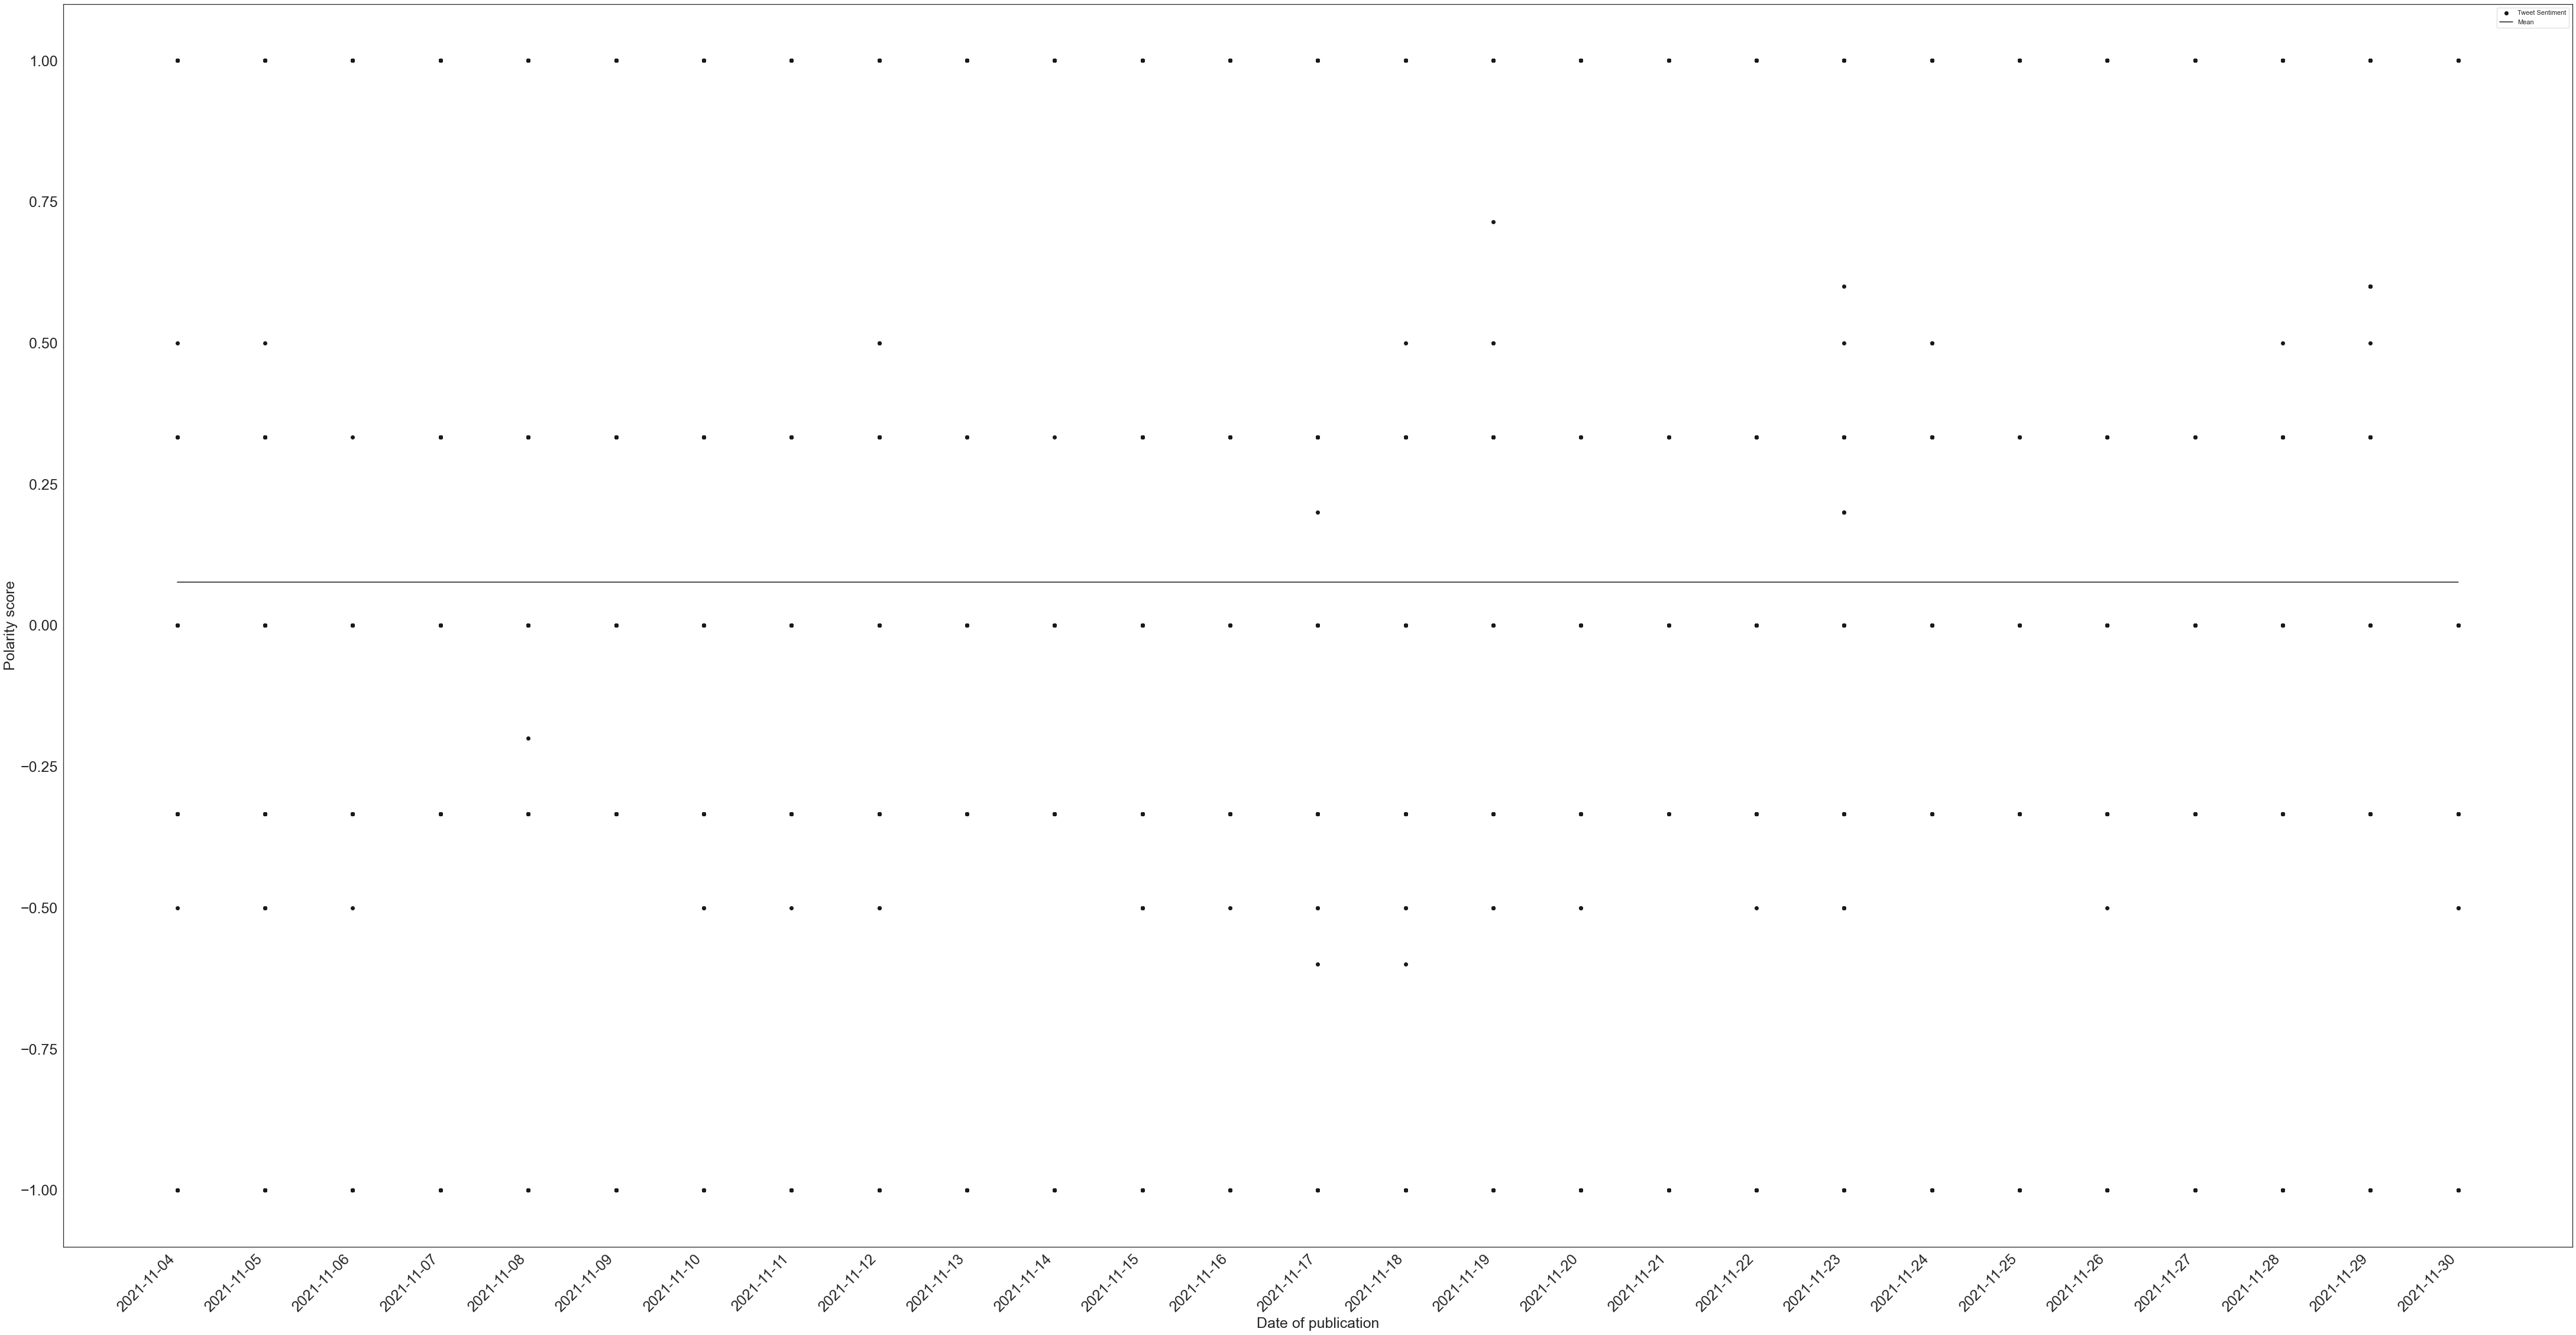

In [43]:
#polarity scatter over time
import datetime as dt
df=polarity_df

fig = plt.figure(figsize=(60,30))
ax = fig.add_subplot(111)
ax.scatter(df['date'],df['Polarity'], label='Tweet Sentiment',color='k')
ax.plot(df['date'],df['mean'], color='k', label='Mean')
ax.set(xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=25
)
plt.yticks(
    fontsize=25
)
plt.xlabel('Date of publication', fontsize=25)
plt.ylabel('Polarity score', fontsize =25)
plt.savefig('scatter.pdf')

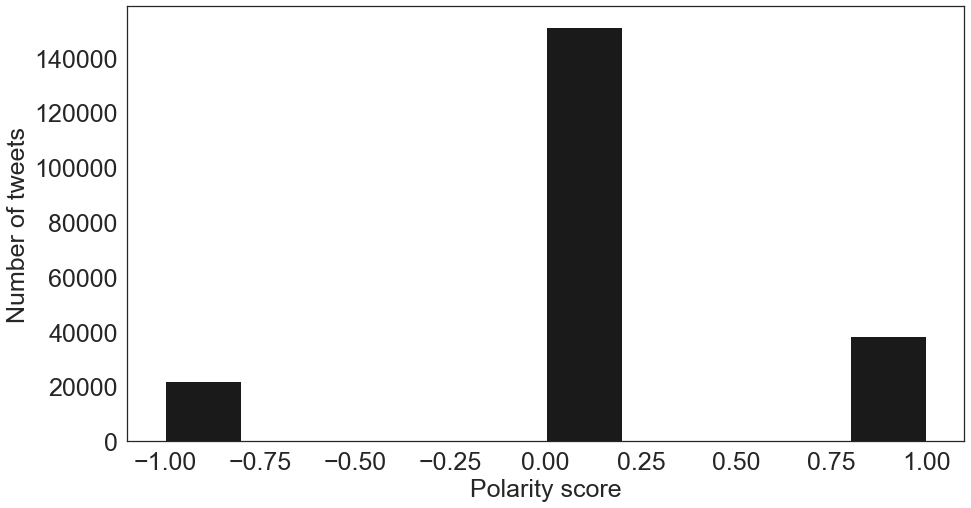

In [44]:
fig = plt.figure(figsize=(15,8))
plt.hist(df['Polarity'],color='k')
plt.xticks( 

    fontsize=25
)
plt.yticks(
    fontsize=25
)
plt.xlabel("Polarity score",fontsize=25)
plt.ylabel("Number of tweets",fontsize=25)
plt.savefig('polarity.pdf')

In [46]:
tweets_df_positive = tweets_df[tweets_df.LM_labeled == 'Positive' ]
tweets_df_negative = tweets_df[tweets_df.LM_labeled == 'Negative' ]
tweets_df_neutral = tweets_df[tweets_df.LM_labeled == 'Neutral' ]

tweets_df_positive=tweets_df_positive['Poswords'].astype('str')
tweets_df_negative=tweets_df_negative['Negwords'].astype('str')

# check out most frequent words - positive
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 100)
vectorizer.fit(tweets_df_positive)
bag_of_words_pos = vectorizer.transform(tweets_df_positive)
sum_words_pos = bag_of_words_pos.sum(axis=0) 
words_freq_pos = [(word, sum_words_pos[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_pos =sorted(words_freq_pos, key = lambda x: x[1], reverse=True)
lst = words_freq_pos
words_freq_df_pos = pd.DataFrame(lst, columns = ['positive words','freq'])

# check out most frequent words - negative
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 100)
vectorizer.fit(tweets_df_negative)
bag_of_words_neg = vectorizer.transform(tweets_df_negative)
sum_words_neg = bag_of_words_neg.sum(axis=0) 
words_freq_neg = [(word, sum_words_neg[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_neg =sorted(words_freq_neg, key = lambda x: x[1], reverse=True)
lst = words_freq_neg
words_freq_df_neg = pd.DataFrame(lst, columns = ['negative words','freq'])

# check out most frequent words - neutral
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), stop_words = 'english', max_features = 100)
vectorizer.fit(tweets_df_neutral['tweet_cleaned'])
bag_of_words_neu = vectorizer.transform(tweets_df_neutral['tweet_cleaned'])
sum_words_neu = bag_of_words_neu.sum(axis=0) 
words_freq_neu = [(word, sum_words_neu[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_neu =sorted(words_freq_neu, key = lambda x: x[1], reverse=True)
lst = words_freq_neu
words_freq_df_neu = pd.DataFrame(lst, columns = ['neutral words','freq'])

print(words_freq_df_pos[:10])
print(words_freq_df_neg[:10])
print(words_freq_df_neu[:10])

  positive words  freq
0  favorite       9446
1  winner         7028
2  good           3168
3  best           2641
4  great          1860
5  strong         1408
6  rewarding      962 
7  better         787 
8  happy          770 
9  gain           661 
        negative words  freq
0  alerted              3148
1  breaking             2799
2  litigation           1578
3  accused              1576
4  litigation accused   1572
5  breaking litigation  1569
6  alerted alerted      1475
7  break                1376
8  miss                 1075
9  delayed              829 
  neutral words  freq
0  price         7680
1  stocks        7114
2  amp           6845
3  today         6730
4  calls         6564
5  apple         6204
6  stock         6175
7  new           5777
8  buy           5180
9  week          5141


In [47]:
df['fintags_positive'] = np.where(df['Polarity'] > 0, 
                     df['fintags'], 
                                     np.nan)
df['fintags_negative'] = np.where(df['Polarity'] < 0, 
                     df['fintags'], 
                                     np.nan)
df['fintags_neutral'] = np.where(df['Polarity'] == 0, 
                     df['fintags'], 
                                     np.nan)

df_finpos = pd.DataFrame(df, columns=["Polarity", "tweet_cleaned",'date','fintags_positive'])
df_finpos = df_finpos[df_finpos['fintags_positive'].notna()]

df_finneg = pd.DataFrame(df, columns=["Polarity", "tweet_cleaned",'date','fintags_negative'])
df_finneg = df_finneg[df_finneg['fintags_negative'].notna()]

df_finneu = pd.DataFrame(df, columns=["Polarity", "tweet_cleaned",'date','fintags_neutral'])
df_finneu = df_finneu[df_finneu['fintags_neutral'].notna()]

# check out most frequent fintags - positive
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), stop_words = 'english', max_features = 100)
vectorizer.fit(df_finpos['fintags_positive'])
bag_of_words_pt = vectorizer.transform(df_finpos['fintags_positive'])
sum_words_pt = bag_of_words_pt.sum(axis=0) 
words_freq_pt = [(word, sum_words_pt[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_pt =sorted(words_freq_pt, key = lambda x: x[1], reverse=True)
lst = words_freq_pt
words_freq_df_pt = pd.DataFrame(lst, columns = ['positive fintags','freq'])

# check out most frequent fintags - negative
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), stop_words = 'english', max_features = 100)
vectorizer.fit(df_finneg['fintags_negative'])
bag_of_words_nf = vectorizer.transform(df_finneg['fintags_negative'])
sum_words_nf = bag_of_words_nf.sum(axis=0) 
words_freq_nf = [(word, sum_words_nf[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_nf =sorted(words_freq_nf, key = lambda x: x[1], reverse=True)
lst = words_freq_nf
words_freq_df_nf = pd.DataFrame(lst, columns = ['negative fintags','freq'])

# check out most frequent fintags - neutral
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), stop_words = 'english', max_features = 100)
vectorizer.fit(df_finneu['fintags_neutral'])
bag_of_words_nft = vectorizer.transform(df_finneu['fintags_neutral'])
sum_words_nft = bag_of_words_nft.sum(axis=0) 
words_freq_nft = [(word, sum_words_nft[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_nft =sorted(words_freq_nft, key = lambda x: x[1], reverse=True)
lst = words_freq_nft
words_freq_df_nft = pd.DataFrame(lst, columns = ['neutral fintags','freq'])



print(words_freq_df_pt[:10])
print(words_freq_df_nf[:10])
print(words_freq_df_nft[:10])

  positive fintags   freq
0  cat              19549
1  cat cat          12651
2  sol              9191 
3  uni              9163 
4  ens              9132 
5  ron              9116 
6  sol ron          9116 
7  ron ens          9116 
8  metis            9115 
9  ens metis        9115 
  negative fintags  freq
0  aapl             5549
1  jpm              2325
2  dis              1927
3  tsla             1822
4  ba               1397
5  googl            1223
6  msft             1221
7  amzn             1169
8  spy              974 
9  cvx              803 
  neutral fintags   freq
0  aapl            41929
1  tsla            16385
2  msft            14017
3  dis             12460
4  ba              10446
5  amzn            9305 
6  spy             7858 
7  nvda            7817 
8  fb              6901 
9  cvx             6150 


In [48]:
x=df_finpos.groupby(lambda x: x.date).mean()
x.sort_values(by=['Polarity'])

Polarity
2021-11-24  0.977228
2021-11-28  0.985580
2021-11-23  0.987303
2021-11-19  0.989097
2021-11-12  0.990246
2021-11-22  0.991182
2021-11-08  0.991334
2021-11-29  0.992327
2021-11-04  0.993837
2021-11-13  0.994152
2021-11-07  0.994253
2021-11-27  0.994334
2021-11-26  0.994421
2021-11-15  0.995092
2021-11-18  0.995183
2021-11-21  0.995263
2021-11-05  0.995294
2021-11-11  0.995370
2021-11-20  0.995578
2021-11-17  0.996600
2021-11-25  0.997379
2021-11-10  0.997530
2021-11-16  0.997601
2021-11-14  0.998358
2021-11-09  0.999032
2021-11-06  0.999557
2021-11-30  1.000000

In [49]:
x['Polarity'].sum()

26.833130430387662

In [50]:
y=df_finneg.groupby(lambda x: x.date).mean()
y.sort_values(by=['Polarity'])

Polarity
2021-11-08 -0.994125
2021-11-26 -0.993812
2021-11-21 -0.993350
2021-11-22 -0.993000
2021-11-09 -0.992982
2021-11-15 -0.992424
2021-11-11 -0.991189
2021-11-20 -0.990864
2021-11-23 -0.990842
2021-11-12 -0.990107
2021-11-24 -0.989835
2021-11-13 -0.989806
2021-11-29 -0.989236
2021-11-18 -0.988989
2021-11-16 -0.988492
2021-11-17 -0.988215
2021-11-27 -0.987489
2021-11-19 -0.987001
2021-11-05 -0.984353
2021-11-10 -0.983568
2021-11-25 -0.983264
2021-11-04 -0.981183
2021-11-30 -0.978697
2021-11-07 -0.975243
2021-11-14 -0.974783
2021-11-06 -0.968684
2021-11-28 -0.945336

In [52]:
z=df_finneu.groupby(lambda x: x.date).count()
z.sort_values(by=['Polarity'])

Polarity  tweet_cleaned  date  fintags_neutral
2021-11-30  2176      2176           2176  2176           
2021-11-20  2539      2539           2539  2539           
2021-11-21  2590      2590           2590  2590           
2021-11-13  2665      2665           2665  2665           
2021-11-25  2834      2834           2834  2834           
2021-11-14  2837      2837           2837  2837           
2021-11-06  3163      3163           3163  3163           
2021-11-27  3328      3328           3328  3328           
2021-11-07  3947      3947           3947  3947           
2021-11-28  3983      3983           3983  3983           
2021-11-04  4636      4636           4636  4636           
2021-11-26  5381      5381           5381  5381           
2021-11-24  6042      6042           6042  6042           
2021-11-05  6215      6215           6215  6215           
2021-11-23  6865      6865           6865  6865           
2021-11-12  7008      7008           7008  7008           
2021-11-15  7113      7113           7113  7113           
2021-11-08  7196      7196           7196  7196           
2021-11-11  7262      7262           7262  7262           
2021-11-10  7283      7283           7283  7283           
2021-11-09  7340      7340           7340  7340           
2021-11-16  7436      7436           7436  7436           
2021-11-19  7645      7645           7645  7645           
2021-11-29  7784      7784           7784  7784           
2021-11-17  8090      8090           8090  8090           
2021-11-22  8543      8543           8543  8543           
2021-11-18  9336      9336           9336  9336

In [53]:
tweets_df['Positive_Tweets'] = np.where(tweets_df['NPositiveWords'] > tweets_df['NNegativeWords'], 
                     1,0)
tweets_df['Negative_Tweets'] = np.where(tweets_df['NPositiveWords'] < tweets_df['NNegativeWords'], 
                     1,0)

tweets_df_positive_p = tweets_df[['date', 'Positive_Tweets']]
tweets_df_positive_p['cum_sum'] = tweets_df_positive_p['Positive_Tweets'].cumsum()

tweets_df_negative_p = tweets_df[['date', 'Negative_Tweets']]
tweets_df_negative_p['cum_sum'] = tweets_df_negative_p['Negative_Tweets'].cumsum()

tweets_df_positive_p=tweets_df_positive_p.set_index('date')
tweets_df_negative_p=tweets_df_negative_p.set_index('date')

/var/folders/5q/_fcxw0093zz6mbncm4kcrzfw0000gn/T/ipykernel_70045/2556562719.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df_positive_p['cum_sum'] = tweets_df_positive_p['Positive_Tweets'].cumsum()
/var/folders/5q/_fcxw0093zz6mbncm4kcrzfw0000gn/T/ipykernel_70045/2556562719.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df_negative_p['cum_sum'] = tweets_df_negative_p['Negative_Tweets'].cumsum()


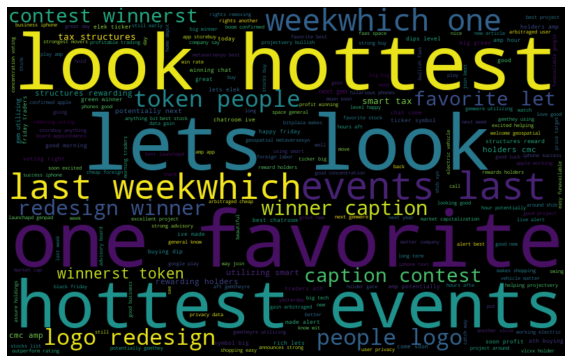

In [54]:
all_words = ' '.join([text for text in tweets_df[tweets_df.LM_labeled == 'Positive' ]['tweet_cleaned']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('cloud1.png')

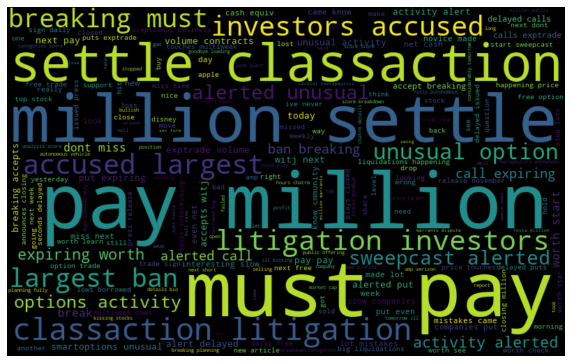

In [55]:
all_words = ' '.join([text for text in tweets_df[tweets_df.LM_labeled == 'Negative' ]['tweet_cleaned']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('cloud2.png')

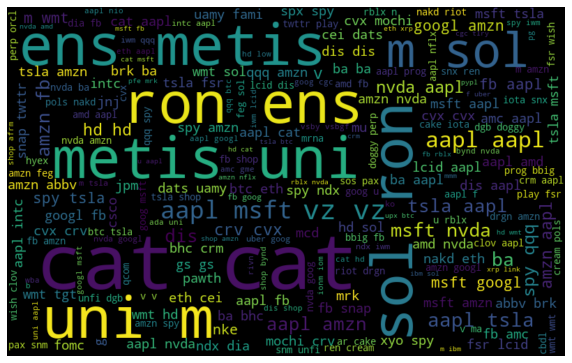

In [56]:
all_words = ' '.join([text for text in tweets_df[tweets_df.LM_labeled == 'Positive' ]['fintags']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('cloud3.png')

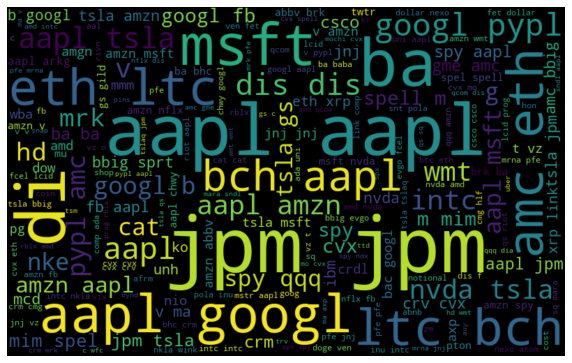

In [57]:
all_words = ' '.join([text for text in tweets_df[tweets_df.LM_labeled == 'Negative' ]['fintags']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('cloud4.png')

In [58]:
#create different dataframes regarding different sentiments
tweets_df_positive = tweets_df[tweets_df.LM_labeled == 'Positive' ]
tweets_df_negative = tweets_df[tweets_df.LM_labeled == 'Negative' ]
tweets_df_neutral = tweets_df[tweets_df.LM_labeled == 'Neutral' ]

tweets_df_positive_m = tweets_df_positive[['date', 'NPositiveWords']]
tweets_df_positive_m['cum_sum'] = tweets_df_positive_m['NPositiveWords'].cumsum()

tweets_df_negative_m = tweets_df_negative[['date', 'NNegativeWords']]
tweets_df_negative_m['cum_sum'] = tweets_df_negative_m['NNegativeWords'].cumsum()

tweets_df_positive_m=tweets_df_positive_m.set_index('date')
tweets_df_negative_m=tweets_df_negative_m.set_index('date')

/var/folders/5q/_fcxw0093zz6mbncm4kcrzfw0000gn/T/ipykernel_70045/379730580.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df_positive_m['cum_sum'] = tweets_df_positive_m['NPositiveWords'].cumsum()
/var/folders/5q/_fcxw0093zz6mbncm4kcrzfw0000gn/T/ipykernel_70045/379730580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df_negative_m['cum_sum'] = tweets_df_negative_m['NNegativeWords'].cumsum()


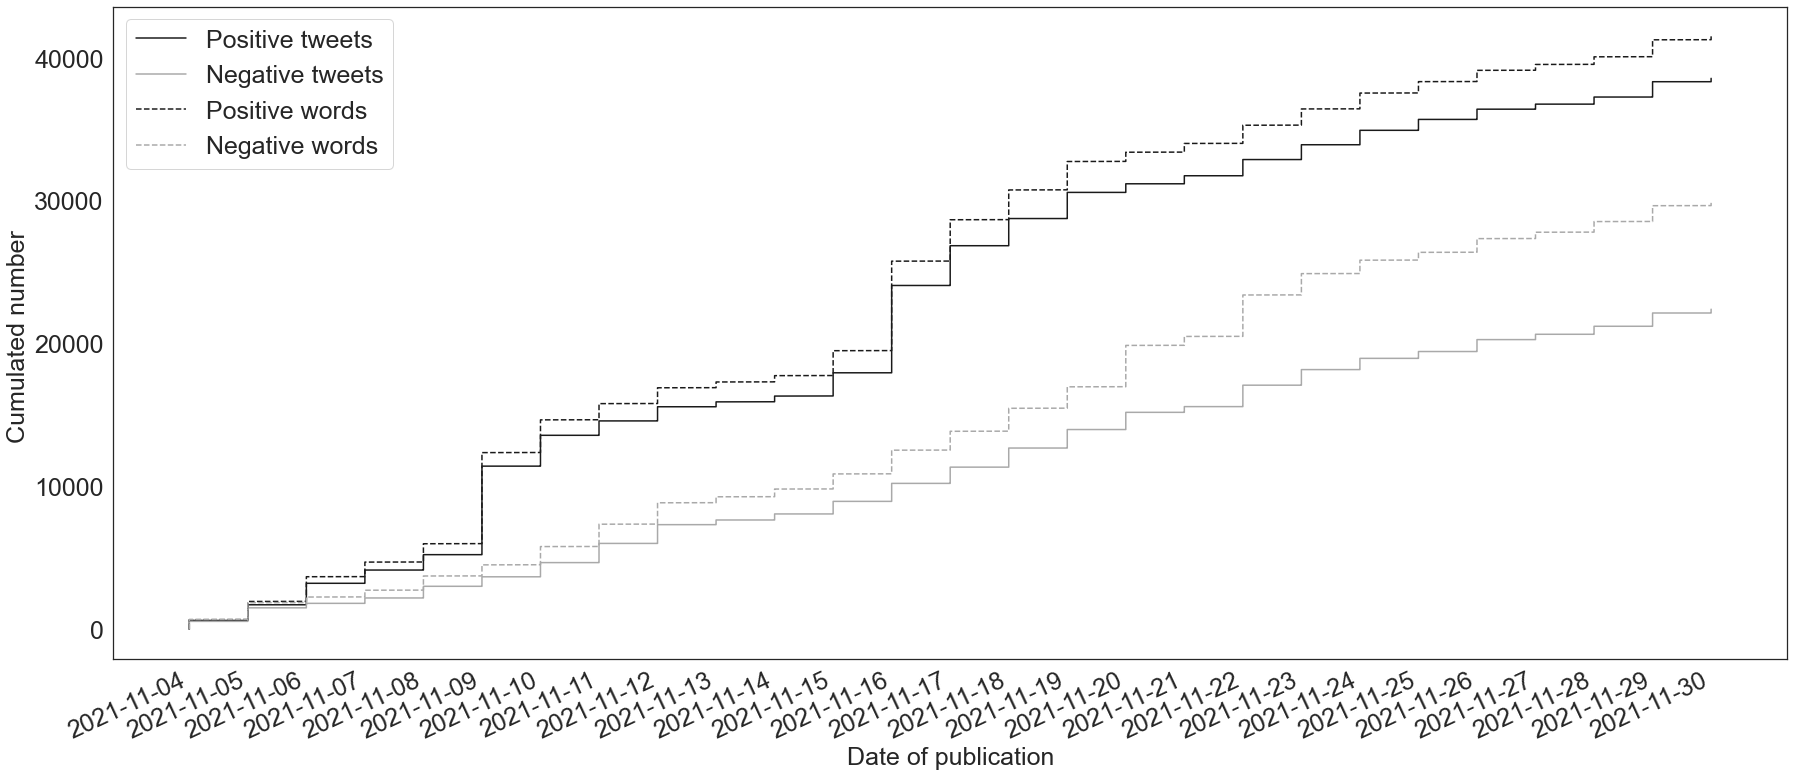

In [59]:
#development of positive and negative tweets and words over time
plt.rc('font', size=40)
plt.figure(figsize=(30,12))
plt.xlabel('Date of publication', fontsize=25)
plt.ylabel('Cumulated number ', fontsize =25)

plt.xticks(
    rotation=25, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=25)
plt.yticks(fontsize=25)
plt.plot(tweets_df_positive_p['cum_sum'], color="k",label='Positive tweets')
plt.plot(tweets_df_negative_p['cum_sum'], color="darkgrey",label='Negative tweets')
plt.plot(tweets_df_positive_m['cum_sum'],color='k',label='Positive words',linestyle='--')
plt.plot(tweets_df_negative_m['cum_sum'],color='darkgrey',label='Negative words',linestyle='--')
plt.legend(fontsize=25)
plt.savefig('cum_amount.pdf')

In [60]:
tweets_positive_sorted=tweets_df_positive_m.groupby(by=['date']).sum()
tweets_negative_sorted=tweets_df_negative_m.groupby(by=['date']).sum()

In [61]:
tweets_positive_sorted.sort_values(by=['date']).drop(['cum_sum'],axis=1)

NPositiveWords
date                      
2021-11-04  678           
2021-11-05  1273          
2021-11-06  1733          
2021-11-07  1024          
2021-11-08  1285          
2021-11-09  6381          
2021-11-10  2293          
2021-11-11  1137          
2021-11-12  1110          
2021-11-13  406           
2021-11-14  443           
2021-11-15  1747          
2021-11-16  6269          
2021-11-17  2900          
2021-11-18  2086          
2021-11-19  1992          
2021-11-20  650           
2021-11-21  614           
2021-11-22  1275          
2021-11-23  1141          
2021-11-24  1112          
2021-11-25  800           
2021-11-26  791           
2021-11-27  412           
2021-11-28  535           
2021-11-29  1191          
2021-11-30  244

In [62]:
tweets_negative_sorted.sort_values(by=['date']).drop('cum_sum',axis=1)

NNegativeWords
date                      
2021-11-04  681           
2021-11-05  1184          
2021-11-06  397           
2021-11-07  477           
2021-11-08  996           
2021-11-09  780           
2021-11-10  1280          
2021-11-11  1566          
2021-11-12  1500          
2021-11-13  420           
2021-11-14  542           
2021-11-15  1059          
2021-11-16  1662          
2021-11-17  1323          
2021-11-18  1610          
2021-11-19  1504          
2021-11-20  2899          
2021-11-21  628           
2021-11-22  2903          
2021-11-23  1495          
2021-11-24  941           
2021-11-25  549           
2021-11-26  961           
2021-11-27  447           
2021-11-28  747           
2021-11-29  1111          
2021-11-30  345

In [63]:
tweets_positive_sorted_tweets=tweets_df_positive_p.groupby(by=['date']).sum()
tweets_negative_sorted_tweets=tweets_df_negative_p.groupby(by=['date']).sum()

In [64]:
tweets_positive_sorted_tweets.sort_values(by=['date']).drop('cum_sum',axis=1)

Positive_Tweets
date                       
2021-11-04  622            
2021-11-05  1098           
2021-11-06  1504           
2021-11-07  928            
2021-11-08  1077           
2021-11-09  6198           
2021-11-10  2159           
2021-11-11  1008           
2021-11-12  991            
2021-11-13  342            
2021-11-14  406            
2021-11-15  1630           
2021-11-16  6114           
2021-11-17  2784           
2021-11-18  1903           
2021-11-19  1830           
2021-11-20  603            
2021-11-21  563            
2021-11-22  1134           
2021-11-23  1037           
2021-11-24  1010           
2021-11-25  763            
2021-11-26  717            
2021-11-27  353            
2021-11-28  497            
2021-11-29  1073           
2021-11-30  236

In [65]:
tweets_negative_sorted_tweets.sort_values(by=['date']).drop('cum_sum',axis=1)

Negative_Tweets
date                       
2021-11-04  558            
2021-11-05  948            
2021-11-06  314            
2021-11-07  377            
2021-11-08  817            
2021-11-09  665            
2021-11-10  994            
2021-11-11  1343           
2021-11-12  1314           
2021-11-13  327            
2021-11-14  423            
2021-11-15  880            
2021-11-16  1260           
2021-11-17  1137           
2021-11-18  1338           
2021-11-19  1295           
2021-11-20  1204           
2021-11-21  401            
2021-11-22  1500           
2021-11-23  1092           
2021-11-24  787            
2021-11-25  478            
2021-11-26  835            
2021-11-27  373            
2021-11-28  561            
2021-11-29  929            
2021-11-30  266

# 5. Create a dataset of manually labelled tweets



In [66]:
tweets_df['labeled_tweets'] = ""

In [67]:
tweets_df['number'] = ""

In [68]:
first_column = tweets_df.pop('number')
tweets_df.insert(0,'number',first_column)

In [69]:
tweets_df = tweets_df.drop_duplicates(subset='tweet_cleaned',keep='last',inplace=False)

In [70]:
tweets_df['number'] = np.arange(len(tweets_df))

In [71]:
#tweets_df_labeled=tweets_df.sample(n=4000,replace=True)

In [72]:
#pip install openpyxl

In [73]:
#from openpyxl.workbook import Workbook
#tweets_df_labeled.to_excel('tweets_df_final1000.xlsx')

In [75]:
#the code was created with excel whereas with the "Verketten" function the labels were combined with the python characters
tweets_df.loc[tweets_df.index[77357], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[56531], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[7189], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[59471], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[13672], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[40641], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[42666], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[2010], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[70891], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[33973], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[21148], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[62894], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[75926], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[397], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[49308], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[30981], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[55149], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[50914], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[14136], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[50868], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[11398], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[23532], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[70805], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[14860], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[22488], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[51354], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[14983], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[20391], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[21592], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[39072], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[67485], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[69808], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[24807], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[56305], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[25234], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[51776], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[23471], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22503], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[35591], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[14205], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[18295], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[15202], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[60132], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52717], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[44404], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[60834], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[23189], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[17627], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[59709], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[18113], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[36937], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[48197], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[97], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[25216], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[61916], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[43675], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[8880], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[14191], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[17443], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[36498], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[65140], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[26557], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[56179], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[11575], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[19040], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[54387], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[76143], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[19132], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[45611], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[9914], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[32862], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[16987], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[68910], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[52099], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[66635], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[19755], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[36539], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[12439], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[56451], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[54029], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[44798], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[21082], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[52708], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[65025], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[66958], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[61794], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[18852], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[20139], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[432], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[47973], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[32462], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[72150], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[11464], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[36832], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[22602], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[11955], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[20341], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[58029], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[3915], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[51652], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[69911], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[29516], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[15039], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[73671], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[77436], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[23915], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[61799], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[52963], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[4146], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[23363], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[65505], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[37957], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[74302], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[34258], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[56970], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[58879], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[62316], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[68138], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[40630], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[59571], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[41192], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[44691], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[43375], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[10869], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[1958], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[75301], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[39707], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[19684], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[63044], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[43862], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[23412], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[44414], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[75307], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[46418], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[74293], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[41090], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[69337], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[5289], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[2647], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[74795], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[50555], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[47325], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[74156], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[18957], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[20503], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[45604], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[60595], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[58147], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[8104], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[4778], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[34194], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[32846], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[77175], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[4894], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[61961], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[76668], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[8383], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[24548], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[65], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[16540], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[23217], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[42690], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[73836], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[53841], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[61600], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[33190], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[51153], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[53179], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[8179], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[51735], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[50087], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[50494], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[16731], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[71153], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[31215], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[19875], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[12191], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[8135], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[59504], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[9915], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[39116], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[715], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[43096], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[17023], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[5203], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[76091], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[66889], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[66748], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[32332], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[10201], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[75657], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[56372], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[69204], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[65419], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[73092], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[2067], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[39643], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[11438], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[58856], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[30059], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[22708], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[77081], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[73036], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[35077], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[53045], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[20112], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[6383], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[3498], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[67761], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[64082], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[23792], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[74216], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[66512], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22843], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[68880], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[62587], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[31393], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[10098], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[10982], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[7919], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[22143], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[77203], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[57012], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[43426], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[71151], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[49910], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[75005], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[61799], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[40468], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[2323], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[28184], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[42866], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[34475], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[38986], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[28206], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[1555], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[38594], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[7499], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[51217], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[21274], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[29746], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[17131], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[52377], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[57461], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[28566], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[29538], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[5752], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[18014], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[70979], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[68578], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[59811], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[53518], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[56483], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[56376], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[4704], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[11438], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[51436], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[10223], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[11451], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[63918], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[58221], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[7909], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[75322], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[74233], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[34901], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[27814], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[4755], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[74946], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[75610], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[46009], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[40855], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[30363], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[18141], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[41449], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[67714], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[58392], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[22078], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[20937], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[65796], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[18906], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[67871], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[75297], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[55593], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[44006], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[74776], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[72848], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[18852], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[10342], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[68635], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[44555], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[36355], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[21320], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[77200], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[65341], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[40065], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[54042], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[45421], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[5100], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[36499], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[10478], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[25893], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[20499], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[51153], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[64101], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[56649], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[74497], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[36127], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[1066], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[15237], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[65910], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[56620], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[2935], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[34301], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[74146], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[75713], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[16229], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[50246], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[73122], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[59529], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[20788], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[728], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[32852], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[29407], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[62469], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[6457], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[5949], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[17187], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[25134], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[77597], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[23475], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[27795], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[8949], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22196], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[40394], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[15022], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[71902], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[1970], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[35197], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[68842], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[60802], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[19875], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[6326], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[67017], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[28230], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[2485], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[31578], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[54578], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[33533], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[71895], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[7785], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[15583], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[46131], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[25784], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[50601], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[65383], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[8066], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[39759], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[48023], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[26816], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[40306], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[49973], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[56791], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[47820], 'labeled_tweets'] = 1

In [76]:
tweets_df.loc[tweets_df.index[45725], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[767], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[33559], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[32313], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[57771], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[20562], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[74161], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[16543], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[77524], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[42069], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[7203], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[64338], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[69881], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[55558], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[65269], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[9852], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[37114], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[54174], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[56352], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[67230], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[49253], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[20729], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[36298], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[48798], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[56582], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[22585], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[29350], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[16954], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[1762], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[39850], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[24490], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[33792], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[64706], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[38815], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[63694], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[71401], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[59285], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[30913], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[40810], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[6234], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[3505], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[47762], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[63525], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[77480], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[38321], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[56261], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[23073], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[37036], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[36499], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[9404], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[73418], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[73654], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[3926], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[30241], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[9082], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[1663], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[41741], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[70738], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[29463], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[56888], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[55393], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[69576], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[19231], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[71957], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[11221], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[49029], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[41193], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[44634], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[21781], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[54745], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[19709], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[33559], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[25278], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[56019], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[21861], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[33337], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[33498], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[31030], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[27190], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[44476], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[24068], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[18736], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[8153], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[48627], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[32032], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[55270], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[13367], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[22273], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[46144], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[61595], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[3253], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[34146], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[65640], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[5409], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[76570], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[5203], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[58862], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[58170], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[45542], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52672], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[48824], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[49373], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[34162], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[15496], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[427], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[77303], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[10142], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[60058], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[58014], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[10161], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[50784], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[20544], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[58448], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[19698], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[4641], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[516], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52399], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[4238], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[66302], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[38048], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[5813], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[36687], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[40810], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[30999], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[63268], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[30860], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[395], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[9931], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[26444], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[64898], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[69043], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52998], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[48294], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[41118], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[7041], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[1281], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[6739], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[56405], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[73550], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[71294], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[37771], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[72972], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[38167], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[27984], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[76296], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[67513], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[64231], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[55905], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[36977], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[71153], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[32698], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[68554], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[53448], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[58528], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[12886], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[67965], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[44912], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[1564], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[61600], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[14965], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[51240], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[14710], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[51757], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22144], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[54522], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[54745], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[30219], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[66843], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[57526], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[70335], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[75689], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[19844], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[76079], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[19634], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[63956], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[6960], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[17144], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[60362], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[33964], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[69474], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[57777], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[58831], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[77354], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[6107], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[3389], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22748], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[12988], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[19861], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[15787], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[11965], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[66521], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[39764], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[57289], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52425], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[23808], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[69043], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52620], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[69547], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[72107], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[50915], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[64815], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[75816], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52573], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[61818], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[30021], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[7203], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[15657], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[67218], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[3941], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[39716], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[60228], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[52500], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[27515], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[2309], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[70821], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[65006], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[2934], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[66299], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[13536], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[62277], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[12750], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[40393], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[3077], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[60146], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[36126], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[53827], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[27822], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[4387], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[61960], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[28946], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[68902], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[67660], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[27541], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[20755], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[19320], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[42673], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[53361], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[10058], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[68807], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[66494], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[43014], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[14409], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[29076], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[35693], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[63414], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[43063], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[49022], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[53841], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[28639], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[7141], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[21980], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[12700], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[1380], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22853], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22149], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[20315], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[74978], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[15176], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[13832], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[15974], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[48702], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[22487], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[65443], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[9888], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[48908], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[16599], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[68550], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[44006], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[56287], 'labeled_tweets'] = 2
tweets_df.loc[tweets_df.index[64315], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[3885], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[73721], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[41760], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[57640], 'labeled_tweets'] = 0
tweets_df.loc[tweets_df.index[8153], 'labeled_tweets'] = 1
tweets_df.loc[tweets_df.index[58751], 'labeled_tweets'] = 1

# 7. Check the tone of the manually labeled data set

In [78]:
value = ['']
labeled_data = tweets_df[tweets_df.labeled_tweets.isin(value) == False]

In [81]:
labeled_data.drop(['tweet','fintags','user_id','user_name','user_followers_count','user_friends_count',
            'created_at',
            'tweet_lang',
            'tweet_id',
            'ot_retweet_count',
            'ot_retweet_time',
            'ot_id','date',
            'time','wordcount','Polarity','LM_labeled','Positive_Tweets','number','Negative_Tweets','NPositiveWords','NNegativeWords','Poswords','Negwords'], axis=1, inplace=True)

/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [82]:
#dataset seems to be balanced
labeled_data['labeled_tweets'].value_counts()

1    228
0    202
2    192
Name: labeled_tweets, dtype: int64

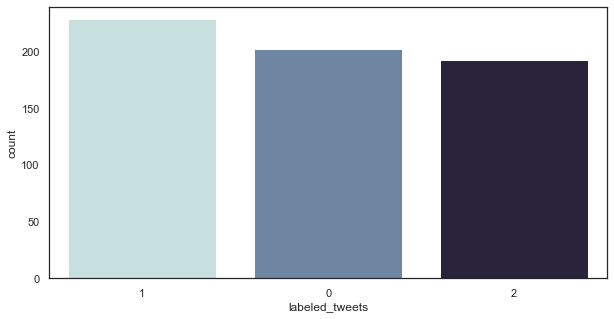

In [83]:
plt.figure(figsize=(10,5))
sns.set(style="white")
ax = sns.countplot(x="labeled_tweets", data=labeled_data, palette="ch:start=.2,rot=-.3", order=labeled_data["labeled_tweets"].value_counts().index[0:10])

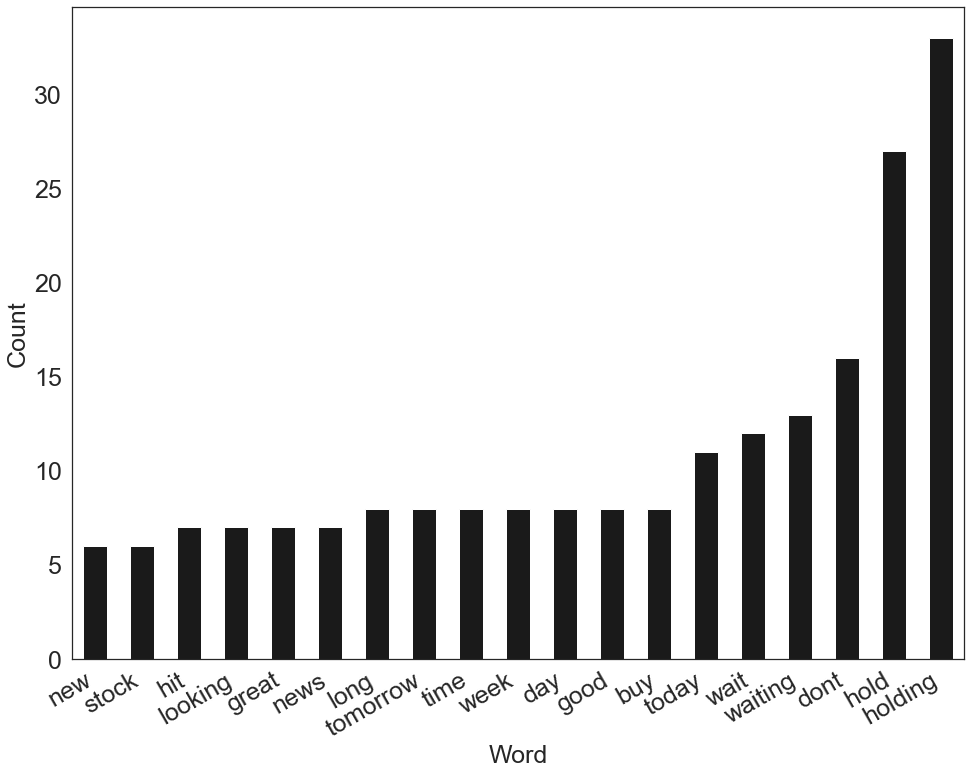

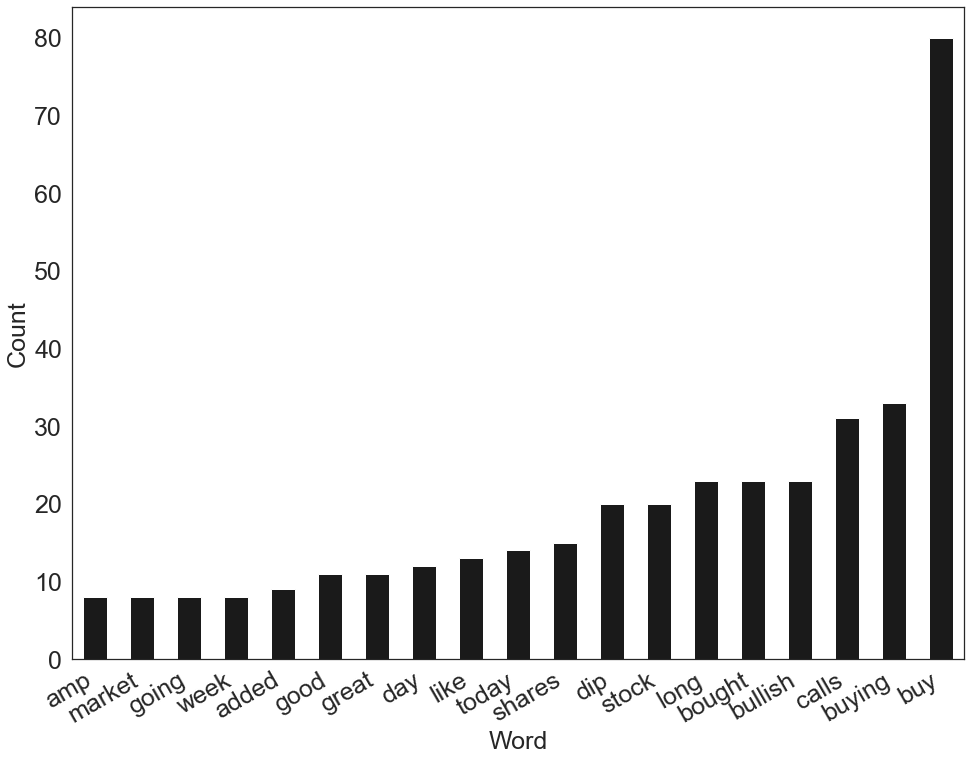

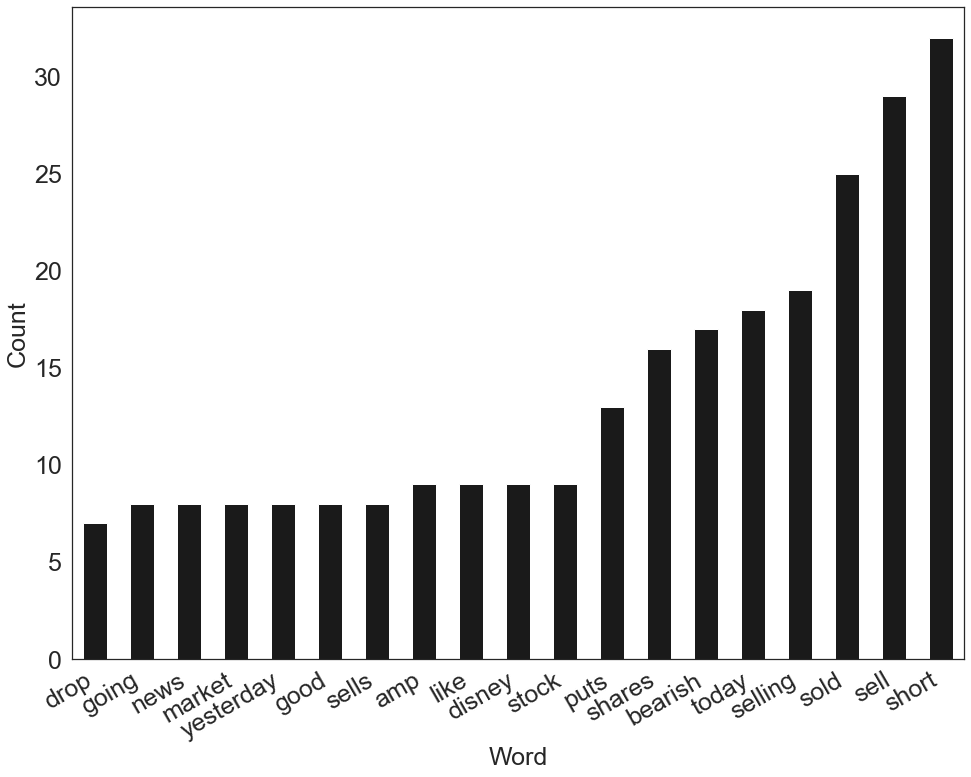

In [84]:
#check most frequent words with respect to the label "Buy", "Hold" and "Sell"
top_words_buy = labeled_data[labeled_data['labeled_tweets']==1]
top_words_hold = labeled_data[labeled_data['labeled_tweets']==0]
top_words_sell = labeled_data[labeled_data['labeled_tweets']==2]

text_buy=top_words_buy['tweet_cleaned']

vectorizer_buy = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), stop_words = 'english', max_features = 1000)
vectorizer_buy.fit(text_buy)
words_buy = vectorizer_buy.transform(text_buy)

sum_words_buy = words_buy.sum(axis=0) 
words_freq_buy = [(word, sum_words_buy[0, idx]) for word, idx in vectorizer_buy.vocabulary_.items()]
words_freq_buy =sorted(words_freq_buy, key = lambda x: x[1], reverse=True)
words_freq_buy[:500]

lst_buy = words_freq_buy
buy_df = pd.DataFrame(lst_buy)
buy_df.columns = ['words','count']
buy_df = buy_df[:19]

text_hold=top_words_hold['tweet_cleaned']

vectorizer_hold = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), stop_words = 'english', max_features = 1000)
vectorizer_hold.fit(text_hold)
words_hold = vectorizer_hold.transform(text_hold)

sum_words_hold = words_hold.sum(axis=0) 
words_freq_hold = [(word, sum_words_hold[0, idx]) for word, idx in vectorizer_hold.vocabulary_.items()]
words_freq_hold =sorted(words_freq_hold, key = lambda x: x[1], reverse=True)
words_freq_hold[:500]

lst_hold = words_freq_hold
hold_df = pd.DataFrame(lst_hold)
hold_df.columns = ['words','count']
hold_df = hold_df[:19]

text_sell=top_words_sell['tweet_cleaned']

vectorizer_sell = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), stop_words = 'english', max_features = 1000)
vectorizer_sell.fit(text_sell)
words_sell = vectorizer_sell.transform(text_sell)

sum_words_sell = words_sell.sum(axis=0) 
words_freq_sell = [(word, sum_words_sell[0, idx]) for word, idx in vectorizer_sell.vocabulary_.items()]
words_freq_sell =sorted(words_freq_sell, key = lambda x: x[1], reverse=True)
words_freq_sell[:500]

lst_sell = words_freq_sell
sell_df = pd.DataFrame(lst_sell)
sell_df.columns = ['words','count']
sell_df = sell_df[:19]

fig, ax = plt.subplots(figsize=(16, 12))
hold_df.sort_values(by='count').plot.bar(x='words',
                      y='count',
                      ax=ax,
                      color="k")
plt.xticks(fontsize=25, rotation=30, 
    horizontalalignment='right')
plt.yticks(fontsize=25)
plt.xlabel('Word', fontsize=25)
plt.ylabel('Count', fontsize =25)
ax.get_legend().remove()
plt.savefig('hold.pdf')


fig, ax = plt.subplots(figsize=(16, 12))
buy_df.sort_values(by='count').plot.bar(x='words',
                      y='count',
                      ax=ax,
                      color="k")
plt.xticks(fontsize=25, rotation=30, 
    horizontalalignment='right')
plt.yticks(fontsize=25)
plt.xlabel('Word', fontsize=25)
plt.ylabel('Count', fontsize =25)
ax.get_legend().remove()
plt.savefig('buy.pdf')


fig, ax = plt.subplots(figsize=(16, 12 ))
sell_df.sort_values(by='count').plot.bar(x='words',
                      y='count',
                      ax=ax,
                      color="k")
plt.xticks(fontsize=25, rotation=30, 
    horizontalalignment='right')
plt.yticks(fontsize=25)
plt.xlabel('Word', fontsize=25)
plt.ylabel('Count', fontsize =25)
ax.get_legend().remove()
plt.savefig('sell.pdf')

# 8. Split the Data (70/30)

In [85]:
y = labeled_data.labeled_tweets.values

x_train, x_test, y_train, y_test = train_test_split(labeled_data.tweet_cleaned.values, 
                                                                y,
                                                                stratify=y,
                                                                random_state = 1,
                                                                test_size=0.3,
                                                                shuffle = True
                                                               )

In [86]:
vectorizer= CountVectorizer(binary=False, stop_words='english',max_features=500)
vectorizer.fit(list(x_train)+list(x_test))
x_train_cv= vectorizer.transform(x_train)
x_test_cv= vectorizer.transform(x_test)

In [87]:
count_0_train = np.count_nonzero(y_train == 0)
count_1_train = np.count_nonzero(y_train == 1)
count_2_train = np.count_nonzero(y_train == 2)
print('Total occurences of "1" in array: ', count_0_train)
print('Total occurences of "2" in array: ', count_1_train)
print('Total occurences of "3" in array: ', count_2_train)

count_0_test = np.count_nonzero(y_test == 0)
count_1_test = np.count_nonzero(y_test == 1)
count_2_test = np.count_nonzero(y_test == 2)
print('Total occurences of "4" in array: ', count_0_test)
print('Total occurences of "5" in array: ', count_1_test)
print('Total occurences of "6" in array: ', count_2_test)

Total occurences of "1" in array:  141
Total occurences of "2" in array:  160
Total occurences of "3" in array:  134
Total occurences of "4" in array:  61
Total occurences of "5" in array:  68
Total occurences of "6" in array:  58


In [88]:
tfidf_vectorizer = TfidfVectorizer(binary=False,stop_words = 'english', max_features = 500)
tfidf_vectorizer.fit(list(x_train)+list(x_test))
x_train_tfidf= tfidf_vectorizer.transform(x_train)
x_test_tfidf= tfidf_vectorizer.transform(x_test)

# 9. KFold - Cross Validation

In [90]:
#transform documents to document-term matrix
y_train= y_train.astype('int')
y_test= y_test.astype('int')

In [91]:
X_KFold =labeled_data.tweet_cleaned.values
vectorizer= CountVectorizer(binary=False, stop_words='english',max_features=500)
vectorizer.fit(list(X_KFold))
X_KFold_cv = vectorizer.transform(X_KFold)

In [92]:
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = 'english',max_features=500)
tfidf_vectorizer.fit(X_KFold)
X_KFold_tfidf= tfidf_vectorizer.transform(X_KFold)

In [93]:
X_KFold_nomax =labeled_data.tweet_cleaned.values
vectorizer_nomax= CountVectorizer(binary=False, stop_words='english')
vectorizer_nomax.fit(list(X_KFold_nomax))
X_KFold_cv_nomax = vectorizer_nomax.transform(X_KFold_nomax)

In [94]:
tfidf_vectorizer_nomax = TfidfVectorizer(analyzer = 'word', stop_words = 'english')
tfidf_vectorizer_nomax.fit(X_KFold_nomax)
X_KFold_tfidf_nomax= tfidf_vectorizer_nomax.transform(X_KFold_nomax)

# 10. Fit different classification models

# SVM Classifier-CV: rbf-kernel, max. 500 features

In [95]:
from sklearn import svm

svm = svm.SVC(kernel = 'rbf', probability = True)

# fit the SVC model based on the given training data
prob= svm.fit(x_train_cv, y_train).predict_proba(x_test_cv)

#perform classification and prediction on samples in x_test_cv
y_pred_svm_cv = svm.predict(x_test_cv)

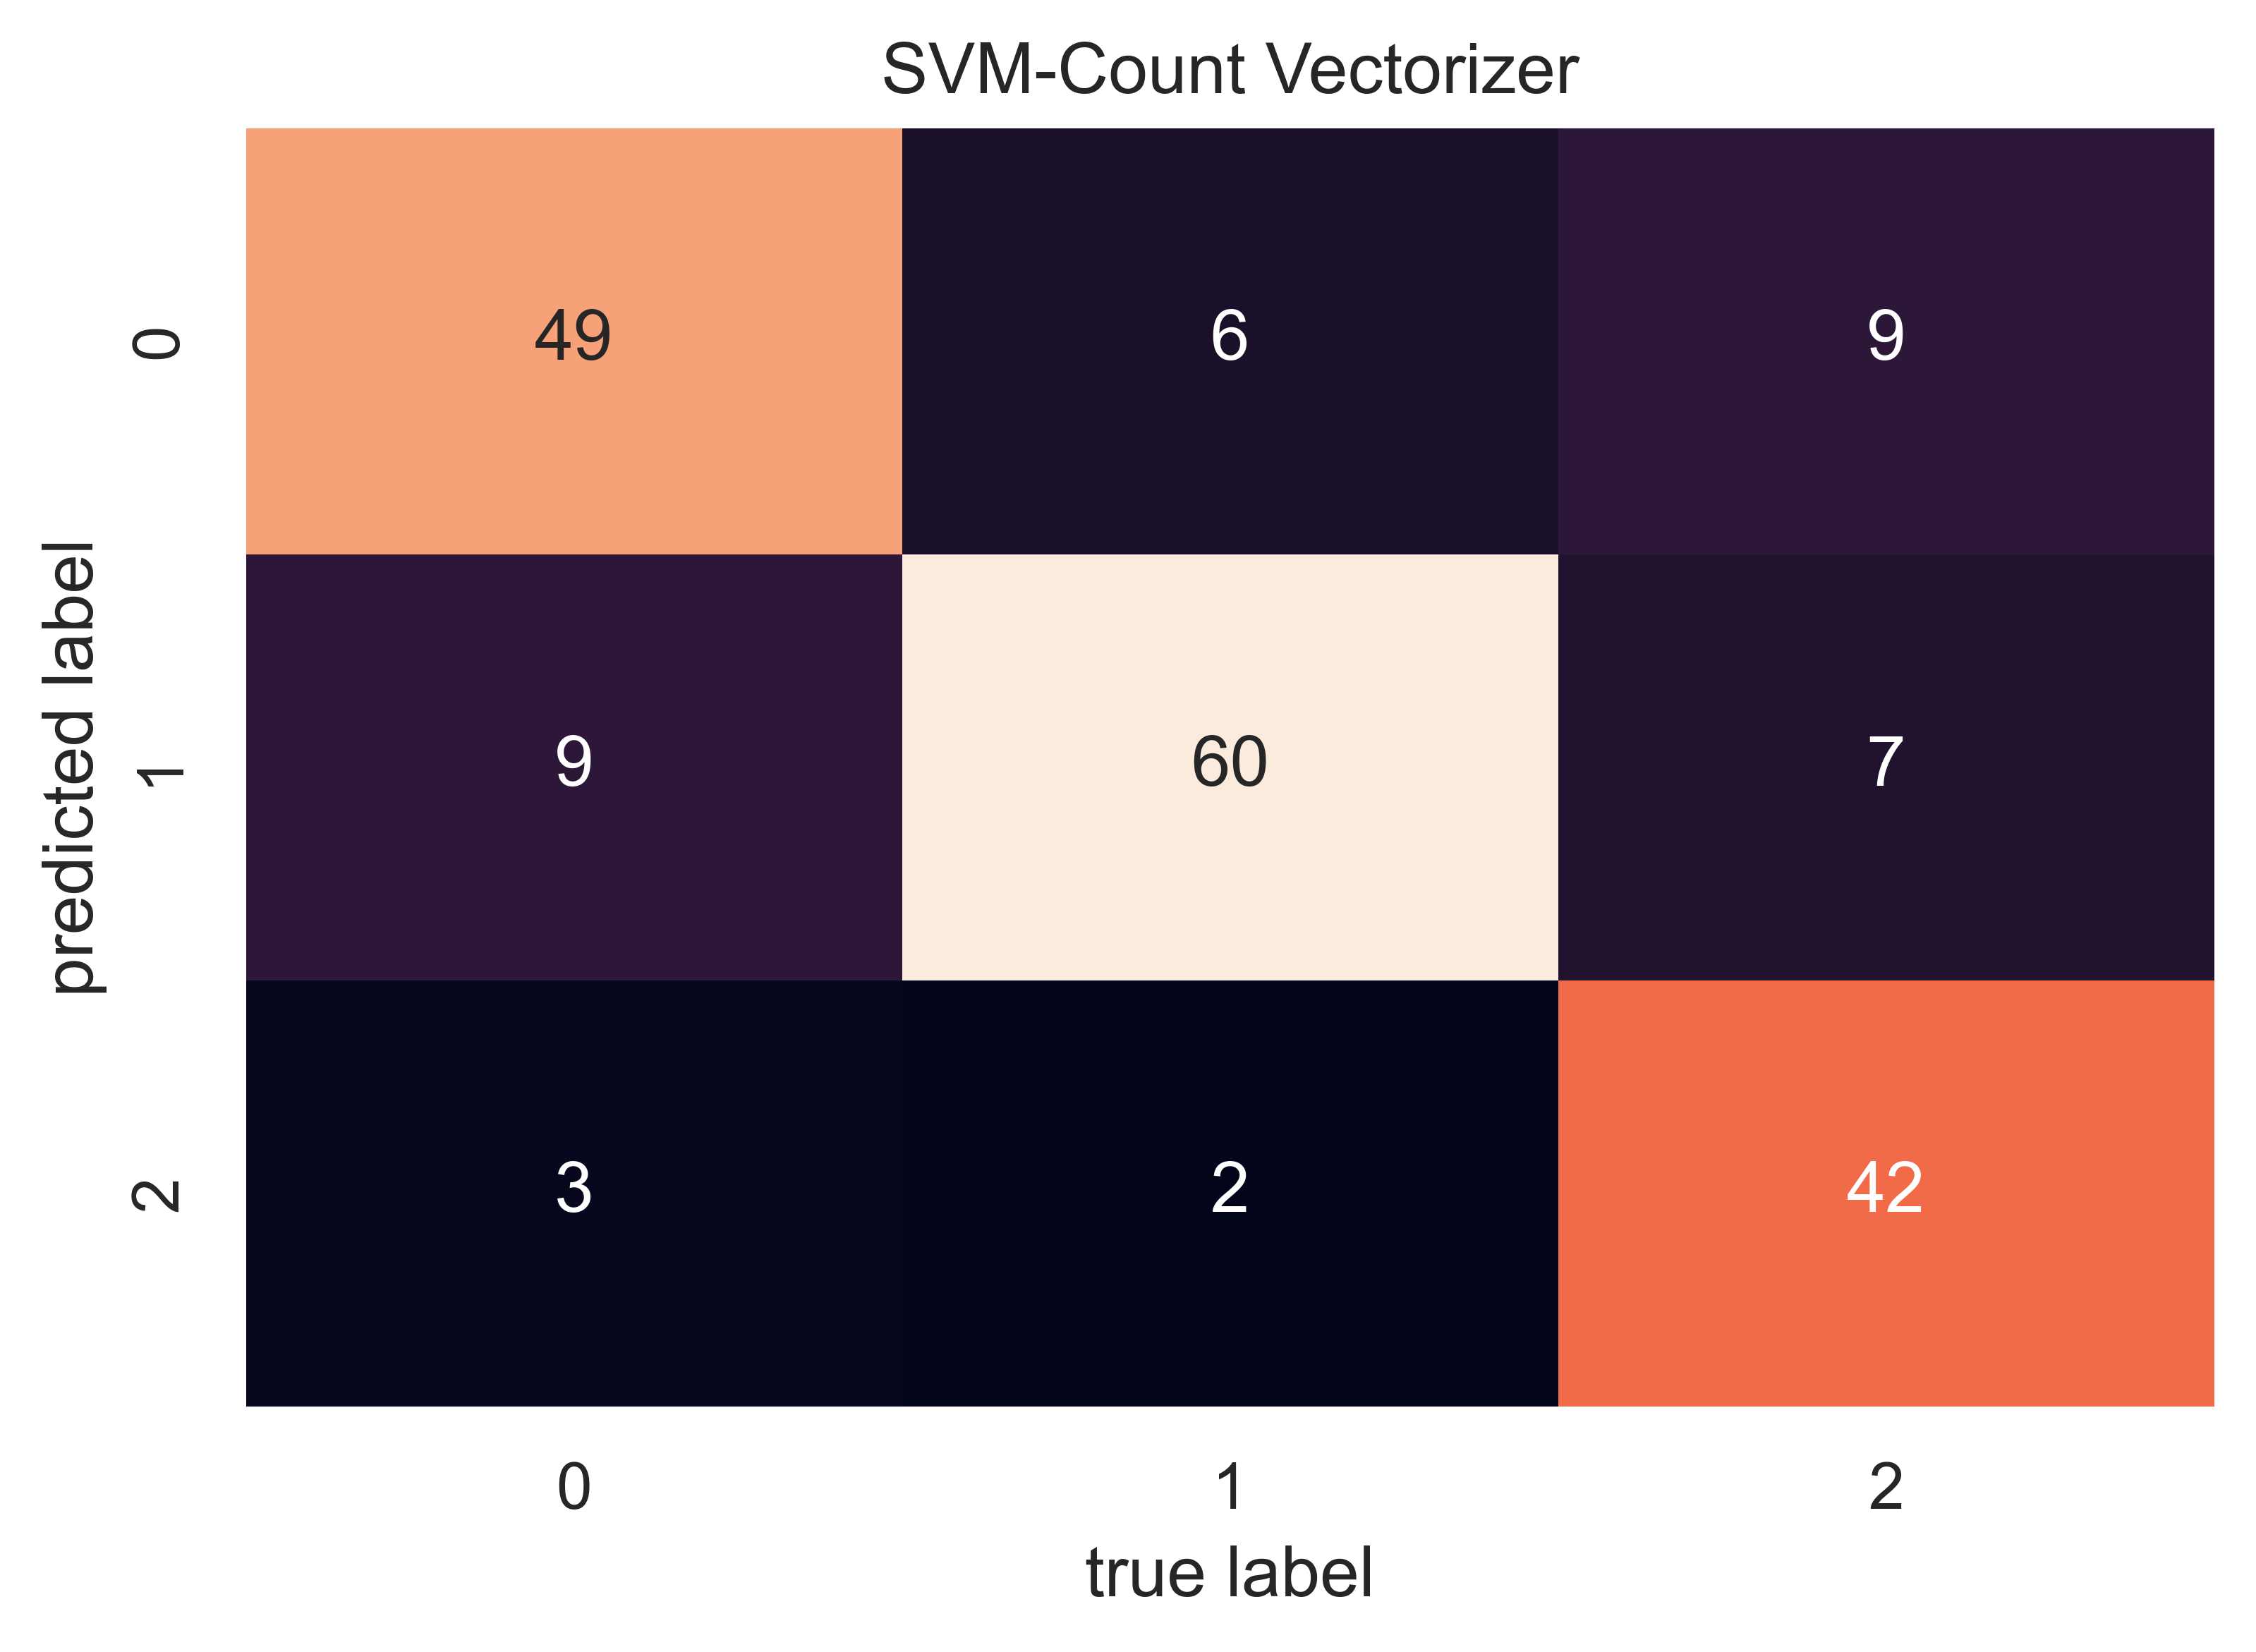

In [96]:
plt.figure(dpi=600)
mat_svm_cv = confusion_matrix(y_test, y_pred_svm_cv)
sns.heatmap(mat_svm_cv.T, annot=True, fmt='d', cbar=False)

plt.title('SVM-Count Vectorizer')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [97]:
print ('Accuracy:', accuracy_score(y_test, y_pred_svm_cv))
print('Precision:',precision_score(y_test, y_pred_svm_cv, average=None))
print ('F1 score:', f1_score(y_test, y_pred_svm_cv,average=None))
print ('Recall:', recall_score(y_test, y_pred_svm_cv,average=None))
print ('Precision:', precision_score(y_test, y_pred_svm_cv,average=None))

Accuracy: 0.8074866310160428
Precision: [0.765625   0.78947368 0.89361702]
F1 score: [0.784      0.83333333 0.8       ]
Recall: [0.80327869 0.88235294 0.72413793]
Precision: [0.765625   0.78947368 0.89361702]


In [98]:
print(classification_report(y_test, y_pred_svm_cv, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78        61
           1       0.79      0.88      0.83        68
           2       0.89      0.72      0.80        58

    accuracy                           0.81       187
   macro avg       0.82      0.80      0.81       187
weighted avg       0.81      0.81      0.81       187



In [99]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm, X_KFold_cv, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.77777778 0.74603175 0.66129032 0.79032258 0.79032258 0.85483871
 0.80645161 0.80645161 0.83870968 0.80645161]


In [100]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7879


# SVM Classifier-TF-IDF: rbf-kernel, max. 500 features

In [101]:
from sklearn import svm
svm = svm.SVC(kernel = 'rbf', probability = True)

prob= svm.fit(x_train_tfidf, y_train).predict_proba(x_test_tfidf)
y_pred_svm_tfidf = svm.predict(x_test_tfidf)

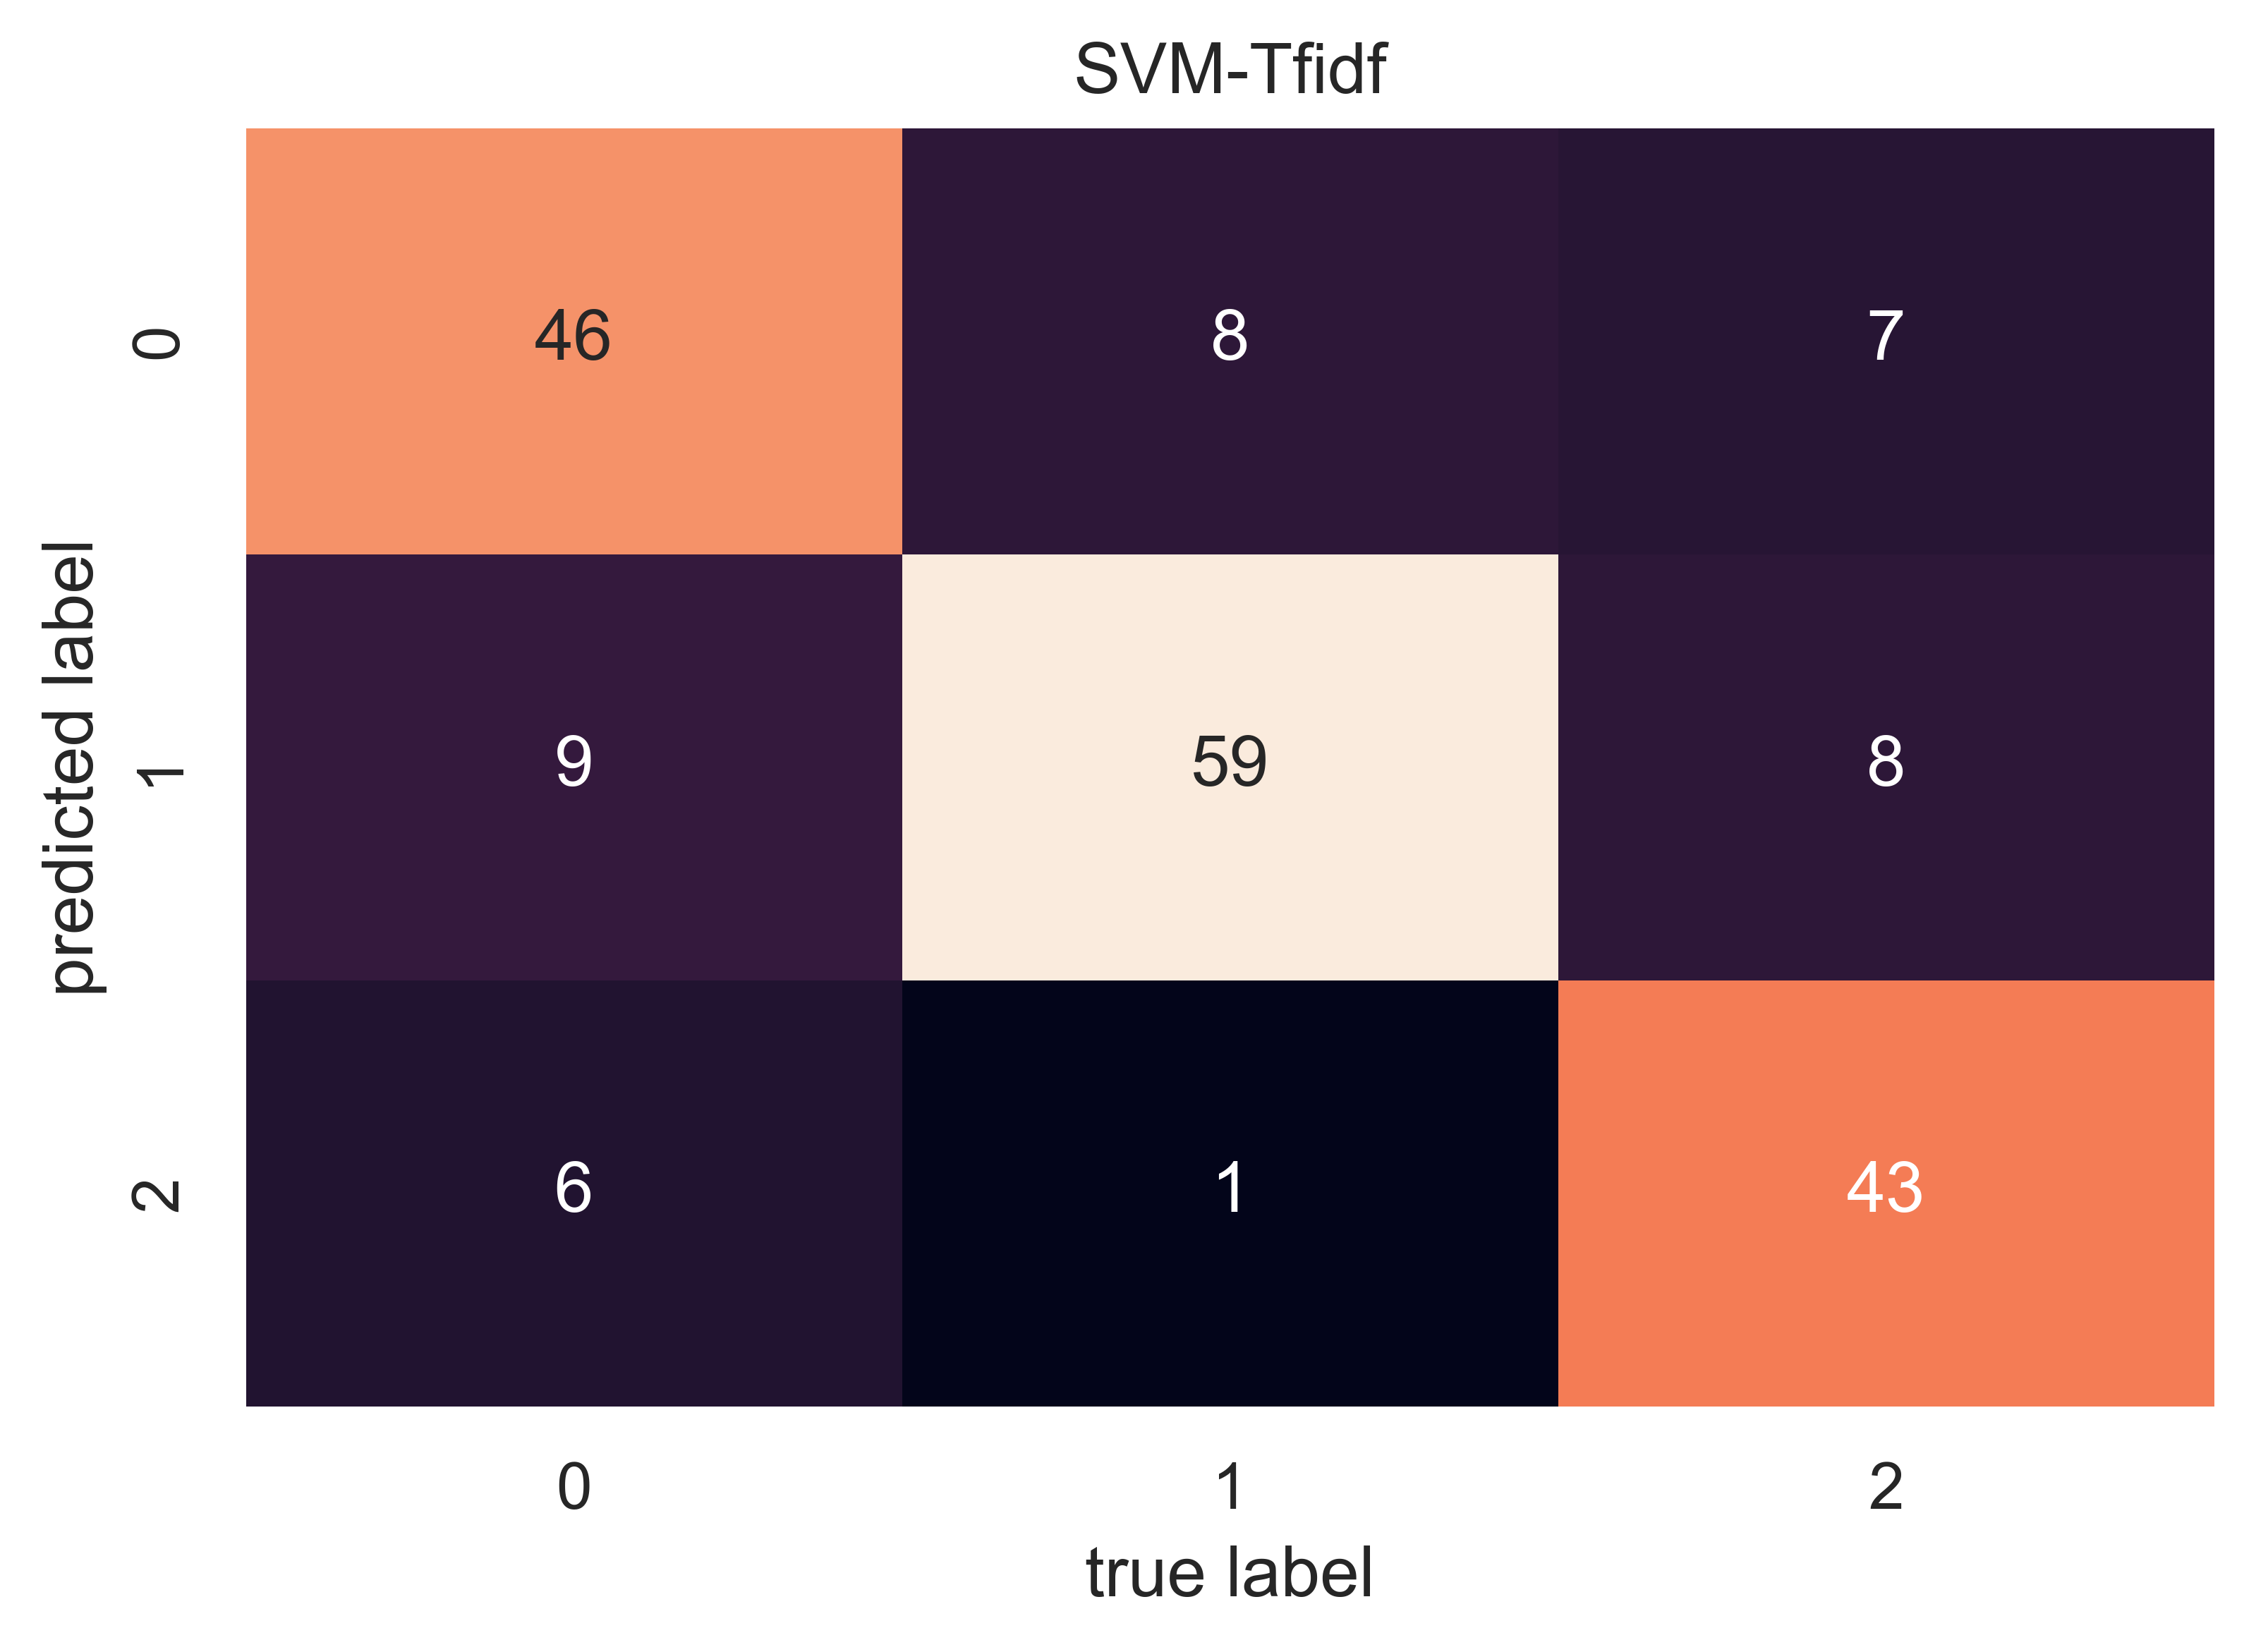

In [102]:
plt.figure(dpi=600)
mat_svm_tfidf = confusion_matrix(y_test,y_pred_svm_tfidf)
sns.heatmap(mat_svm_tfidf.T, annot=True, fmt='d', cbar=False)

plt.title('SVM-Tfidf')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

In [103]:
print ('Accuracy:', accuracy_score(y_test, y_pred_svm_tfidf))
print('Precision:',precision_score(y_test, y_pred_svm_tfidf, average=None))
print ('F1 score:', f1_score(y_test, y_pred_svm_tfidf,average=None))
print ('Recall:', recall_score(y_test, y_pred_svm_tfidf,average=None))
print ('Precision:', precision_score(y_test, y_pred_svm_tfidf,average=None))

Accuracy: 0.7914438502673797
Precision: [0.75409836 0.77631579 0.86      ]
F1 score: [0.75409836 0.81944444 0.7962963 ]
Recall: [0.75409836 0.86764706 0.74137931]
Precision: [0.75409836 0.77631579 0.86      ]


In [104]:
print(classification_report(y_test, y_pred_svm_tfidf, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        61
           1       0.78      0.87      0.82        68
           2       0.86      0.74      0.80        58

    accuracy                           0.79       187
   macro avg       0.80      0.79      0.79       187
weighted avg       0.80      0.79      0.79       187



In [105]:
scores = cross_val_score(svm, X_KFold_tfidf, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.79365079 0.76190476 0.66129032 0.66129032 0.79032258 0.75806452
 0.80645161 0.82258065 0.80645161 0.79032258]


In [106]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7652


# Naive Bayes-CV: Alpha = 1, max. 500 features

In [107]:
 model_naive_cv_500 = MultinomialNB().fit(x_train_cv, y_train) 
y_pred_nb_cv = model_naive_cv_500.predict(x_test_cv)

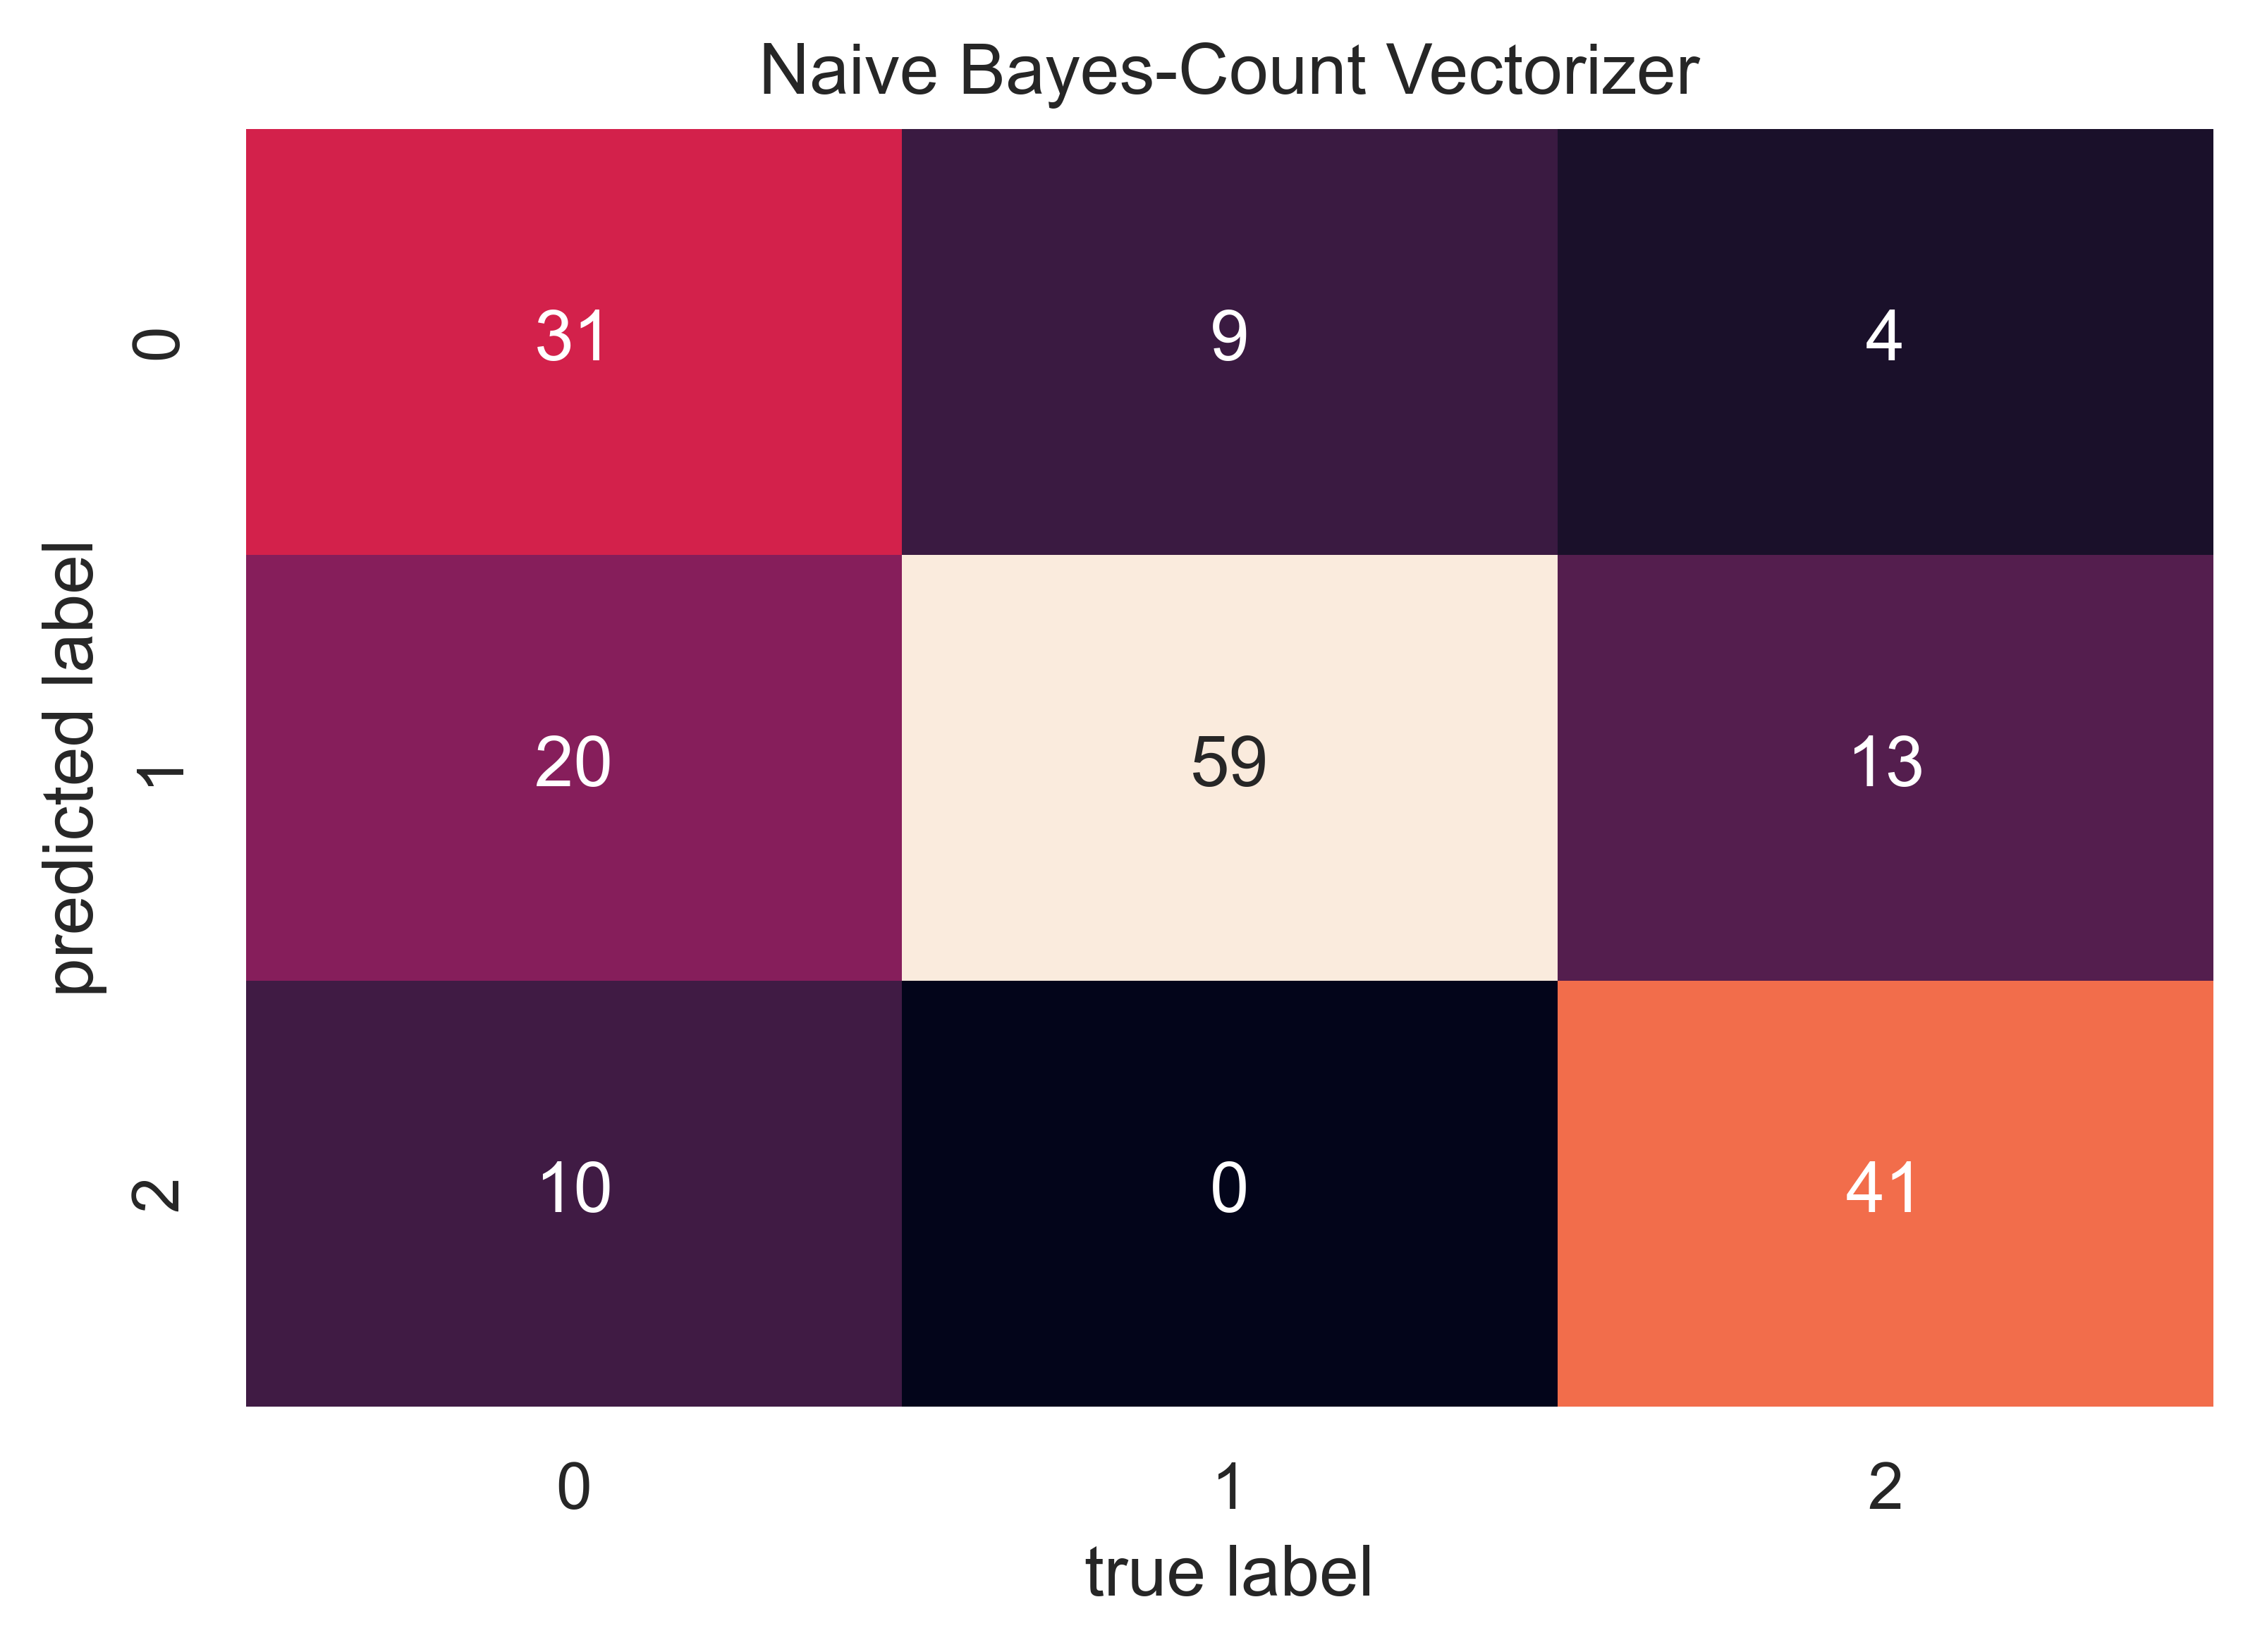

In [108]:
plt.figure(dpi=600)
mat_nb_cv = confusion_matrix(y_test, y_pred_nb_cv)
sns.heatmap(mat_nb_cv.T, annot=True, fmt='d', cbar=False)

plt.title('Naive Bayes-Count Vectorizer')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [109]:
print ('Accuracy:', accuracy_score(y_test, y_pred_nb_cv))
print('Precision:',precision_score(y_test, y_pred_nb_cv, average=None))
print ('F1 score:', f1_score(y_test, y_pred_nb_cv,average=None))
print ('Recall:', recall_score(y_test, y_pred_nb_cv,average=None))
print ('Precision:', precision_score(y_test, y_pred_nb_cv,average=None))

Accuracy: 0.7005347593582888
Precision: [0.70454545 0.64130435 0.80392157]
F1 score: [0.59047619 0.7375     0.75229358]
Recall: [0.50819672 0.86764706 0.70689655]
Precision: [0.70454545 0.64130435 0.80392157]


In [110]:
print(classification_report(y_test, y_pred_nb_cv, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59        61
           1       0.64      0.87      0.74        68
           2       0.80      0.71      0.75        58

    accuracy                           0.70       187
   macro avg       0.72      0.69      0.69       187
weighted avg       0.71      0.70      0.69       187



In [111]:
scores = cross_val_score(model_naive_cv_500, X_KFold_cv, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.79365079 0.63492063 0.67741935 0.66129032 0.72580645 0.72580645
 0.72580645 0.75806452 0.74193548 0.72580645]


In [112]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7171


# Naive Bayes-TF-IDF: Alpha = 1, max. 500 features 

In [113]:
model_naive_tfidf_500 = MultinomialNB().fit(x_train_tfidf, y_train) 
predicted_naive_tfidf = model_naive_tfidf_500.predict(x_test_tfidf)

In [114]:
model_naive_tfidf_500.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

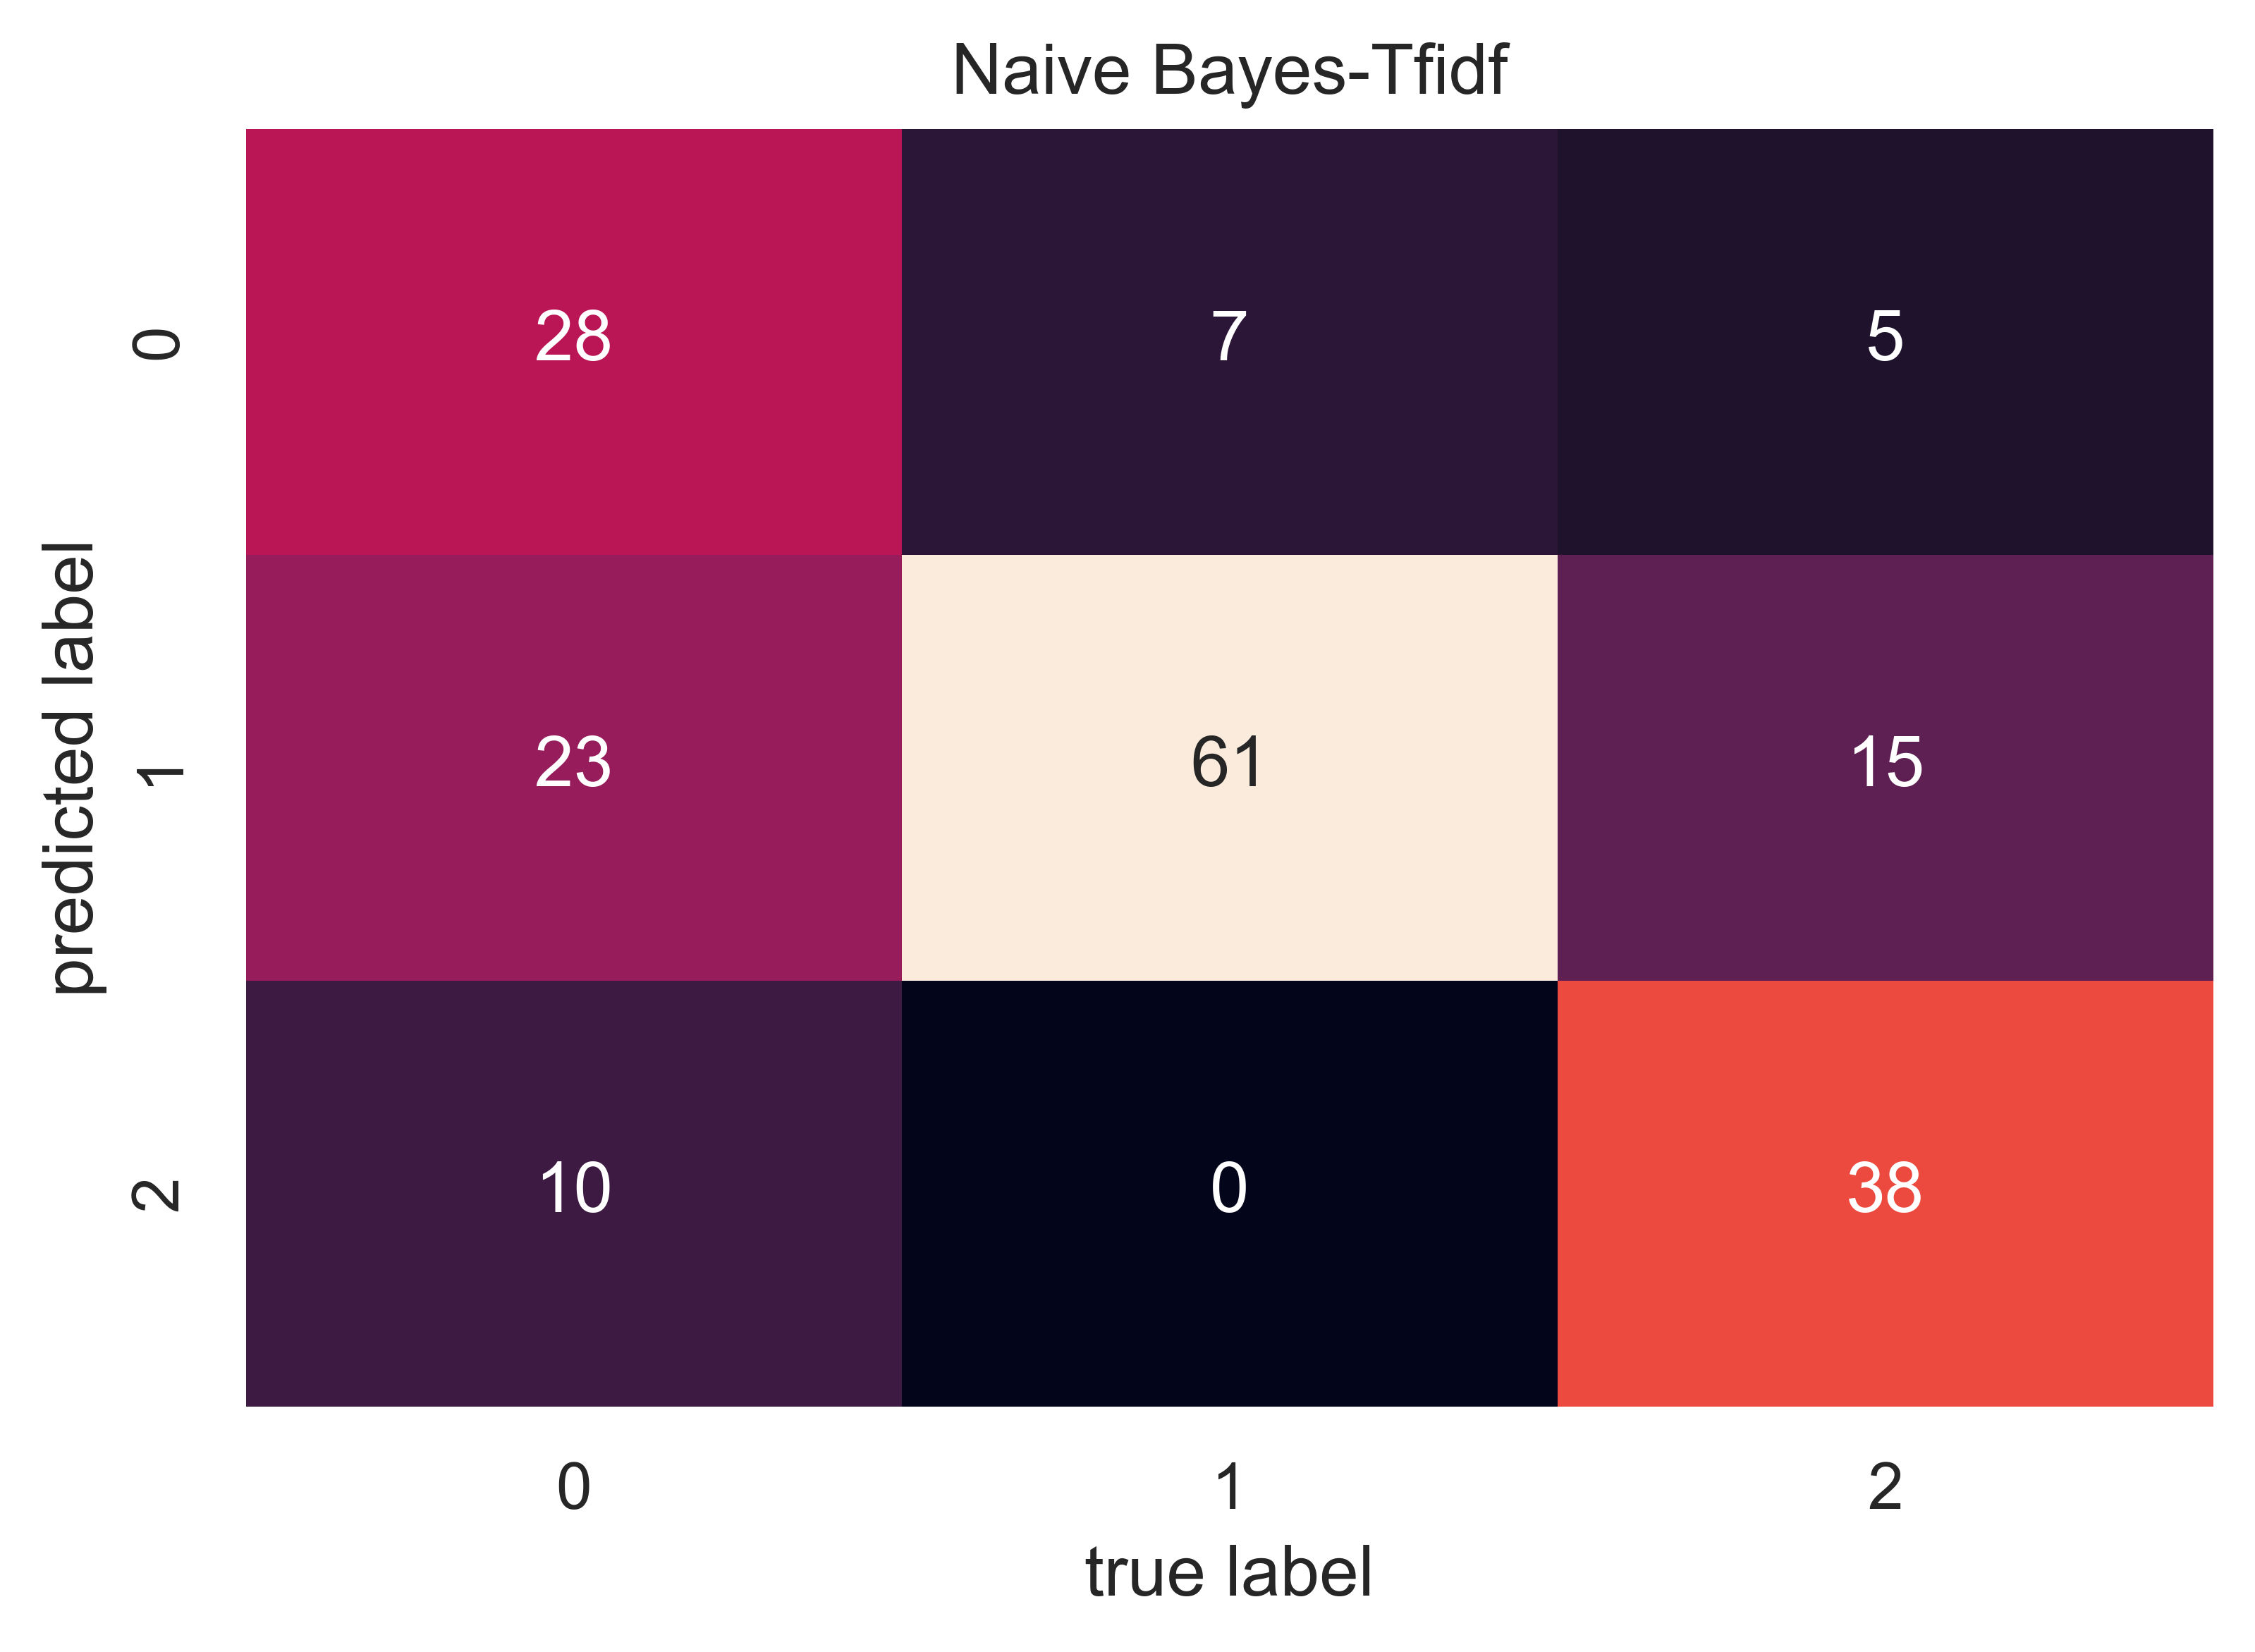

In [115]:
plt.figure(dpi=600)
mat_nb_tfidf = confusion_matrix(y_test, predicted_naive_tfidf)
sns.heatmap(mat_nb_tfidf.T, annot=True, fmt='d', cbar=False)

plt.title('Naive Bayes-Tfidf')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [116]:
print ('Accuracy:', accuracy_score(y_test, predicted_naive_tfidf))
print('Precision:',precision_score(y_test, predicted_naive_tfidf, average=None))
print ('F1 score:', f1_score(y_test, predicted_naive_tfidf,average=None))
print ('Recall:', recall_score(y_test, predicted_naive_tfidf,average=None))
print ('Precision:', precision_score(y_test, predicted_naive_tfidf,average=None))

Accuracy: 0.679144385026738
Precision: [0.7        0.61616162 0.79166667]
F1 score: [0.55445545 0.73053892 0.71698113]
Recall: [0.45901639 0.89705882 0.65517241]
Precision: [0.7        0.61616162 0.79166667]


In [117]:
print(classification_report(y_test, predicted_naive_tfidf, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.70      0.46      0.55        61
           1       0.62      0.90      0.73        68
           2       0.79      0.66      0.72        58

    accuracy                           0.68       187
   macro avg       0.70      0.67      0.67       187
weighted avg       0.70      0.68      0.67       187



In [118]:
scores = cross_val_score(model_naive_tfidf_500,X_KFold_tfidf, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.79365079 0.63492063 0.67741935 0.66129032 0.79032258 0.67741935
 0.72580645 0.75806452 0.77419355 0.74193548]


In [119]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7235


# Naive Bayes Classifiers - Alpha Dependency

/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive

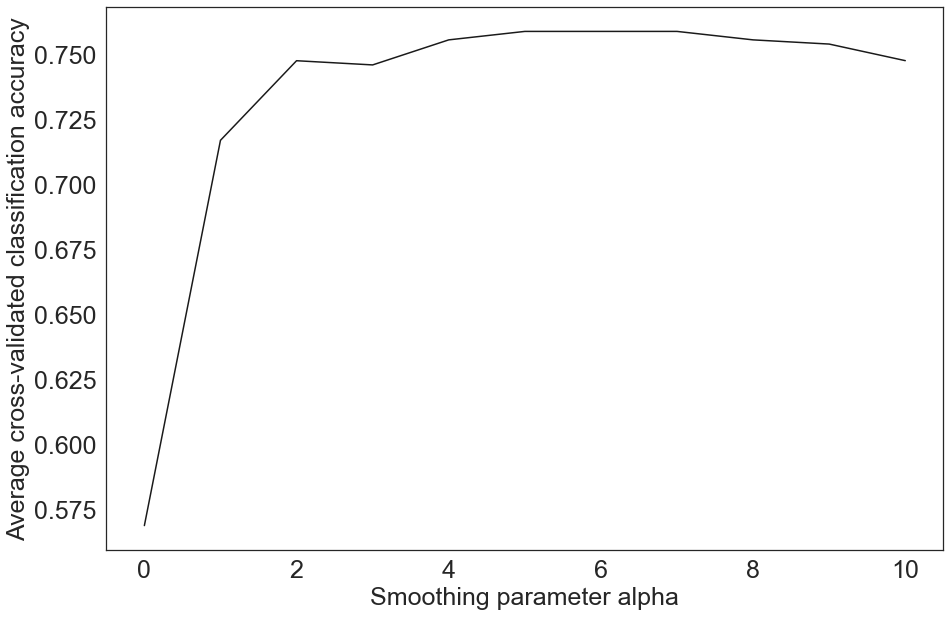

In [120]:
nb_range = range(0, 11)
nb_scores = []
for a in nb_range:
    nb = MultinomialNB(alpha=a)
    scores = cross_val_score(nb, X_KFold_cv, list(y), cv=10, scoring='accuracy')
    nb_scores.append(scores.mean())
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (15,10)



plt.plot(nb_range, nb_scores, 'k')
plt.xlabel('Smoothing parameter alpha', fontsize=25)
plt.ylabel('Average cross-validated classification accuracy',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('alpha-cv.pdf', format='pdf')

/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/gilbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive

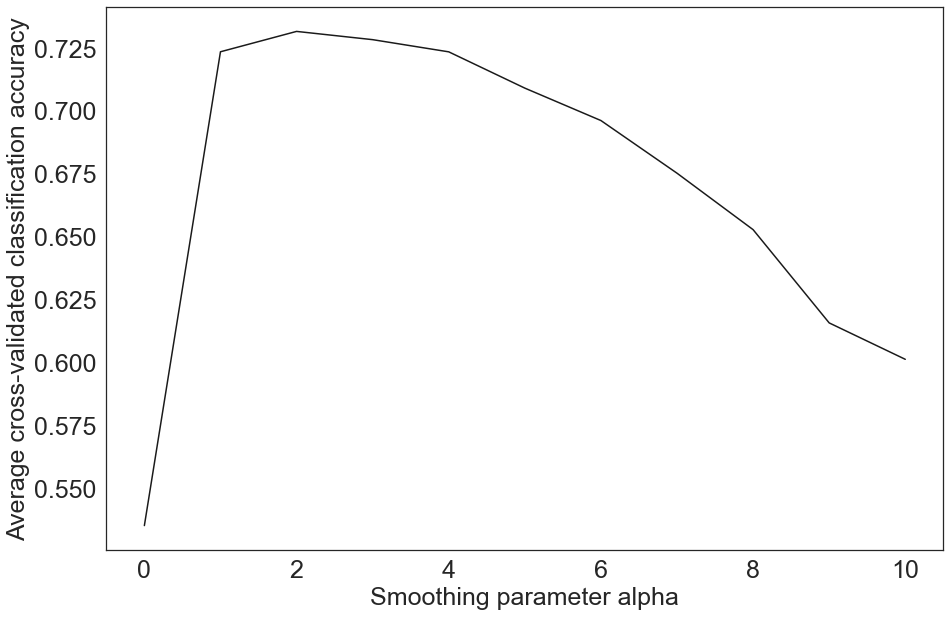

In [121]:
nb_range = range(0, 11)
nb_scores = []
for a in nb_range:
    nb = MultinomialNB(alpha=a)
    scores = cross_val_score(nb, X_KFold_tfidf, list(y), cv=10, scoring='accuracy')
    nb_scores.append(scores.mean())

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(nb_range, nb_scores, 'k')

plt.xlabel('Smoothing parameter alpha', fontsize=25)
plt.ylabel('Average cross-validated classification accuracy',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('alpha-tfidf.pdf', format='pdf')

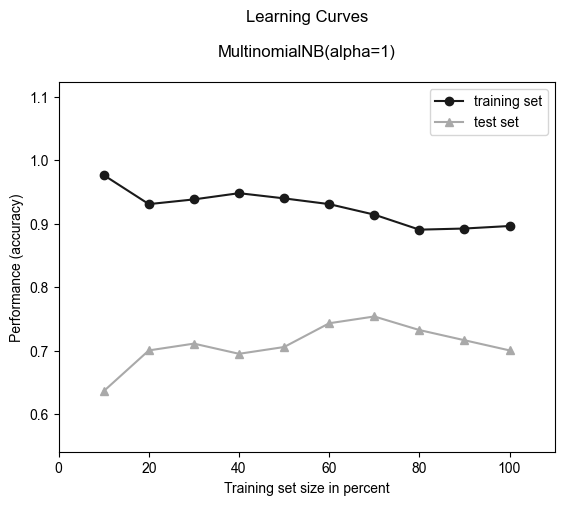

<Figure size 1080x720 with 0 Axes>

In [122]:
clf = MultinomialNB(alpha = 1)
x=plot_learning_curves(x_train_cv, y_train, x_test_cv, y_test,clf, scoring = 'accuracy',suppress_plot=False )
plt.gca().get_lines()[0].set_color("k")
plt.gca().get_lines()[1].set_color("darkgrey")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')
leg.legendHandles[1].set_color('darkgrey')
fig=plt.figure(linewidth=10, edgecolor='#04253a')
fig.savefig('alpha-cv.pdf',edgecolor=fig.get_edgecolor())
#plt.savefig("plots.pdf")

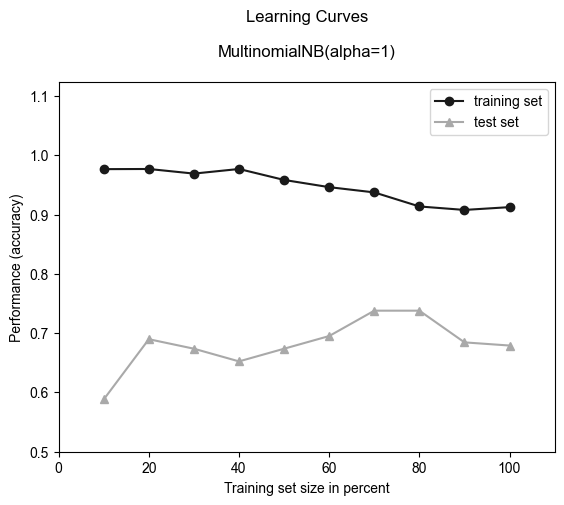

In [123]:
x=plot_learning_curves(x_train_tfidf, y_train, x_test_tfidf, y_test, clf, scoring = 'accuracy')
plt.gca().get_lines()[0].set_color("k")
plt.gca().get_lines()[1].set_color("darkgrey")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')
leg.legendHandles[1].set_color('darkgrey')
plt.savefig("plots.pdf")

# Naive Bayes-CV & -TFIDF: Alpha = 6 and 2, max. 500 features

In [124]:
model_naive_tfidf_alpha = MultinomialNB(alpha=2).fit(x_train_tfidf, y_train) 
predicted_naive_tfidf_alpha = model_naive_tfidf_alpha.predict(x_test_tfidf)

model_naive_cv_alpha = MultinomialNB(alpha=6).fit(x_train_cv, y_train) 
predicted_naive_cv_alpha = model_naive_cv_alpha.predict(x_test_cv)

In [125]:
x_train_cv

<435x500 sparse matrix of type '<class 'numpy.int64'>'
	with 1881 stored elements in Compressed Sparse Row format>

In [126]:
model_naive_tfidf_alpha.get_params()

{'alpha': 2, 'class_prior': None, 'fit_prior': True}

In [127]:
model_naive_cv_alpha.get_params()

{'alpha': 6, 'class_prior': None, 'fit_prior': True}

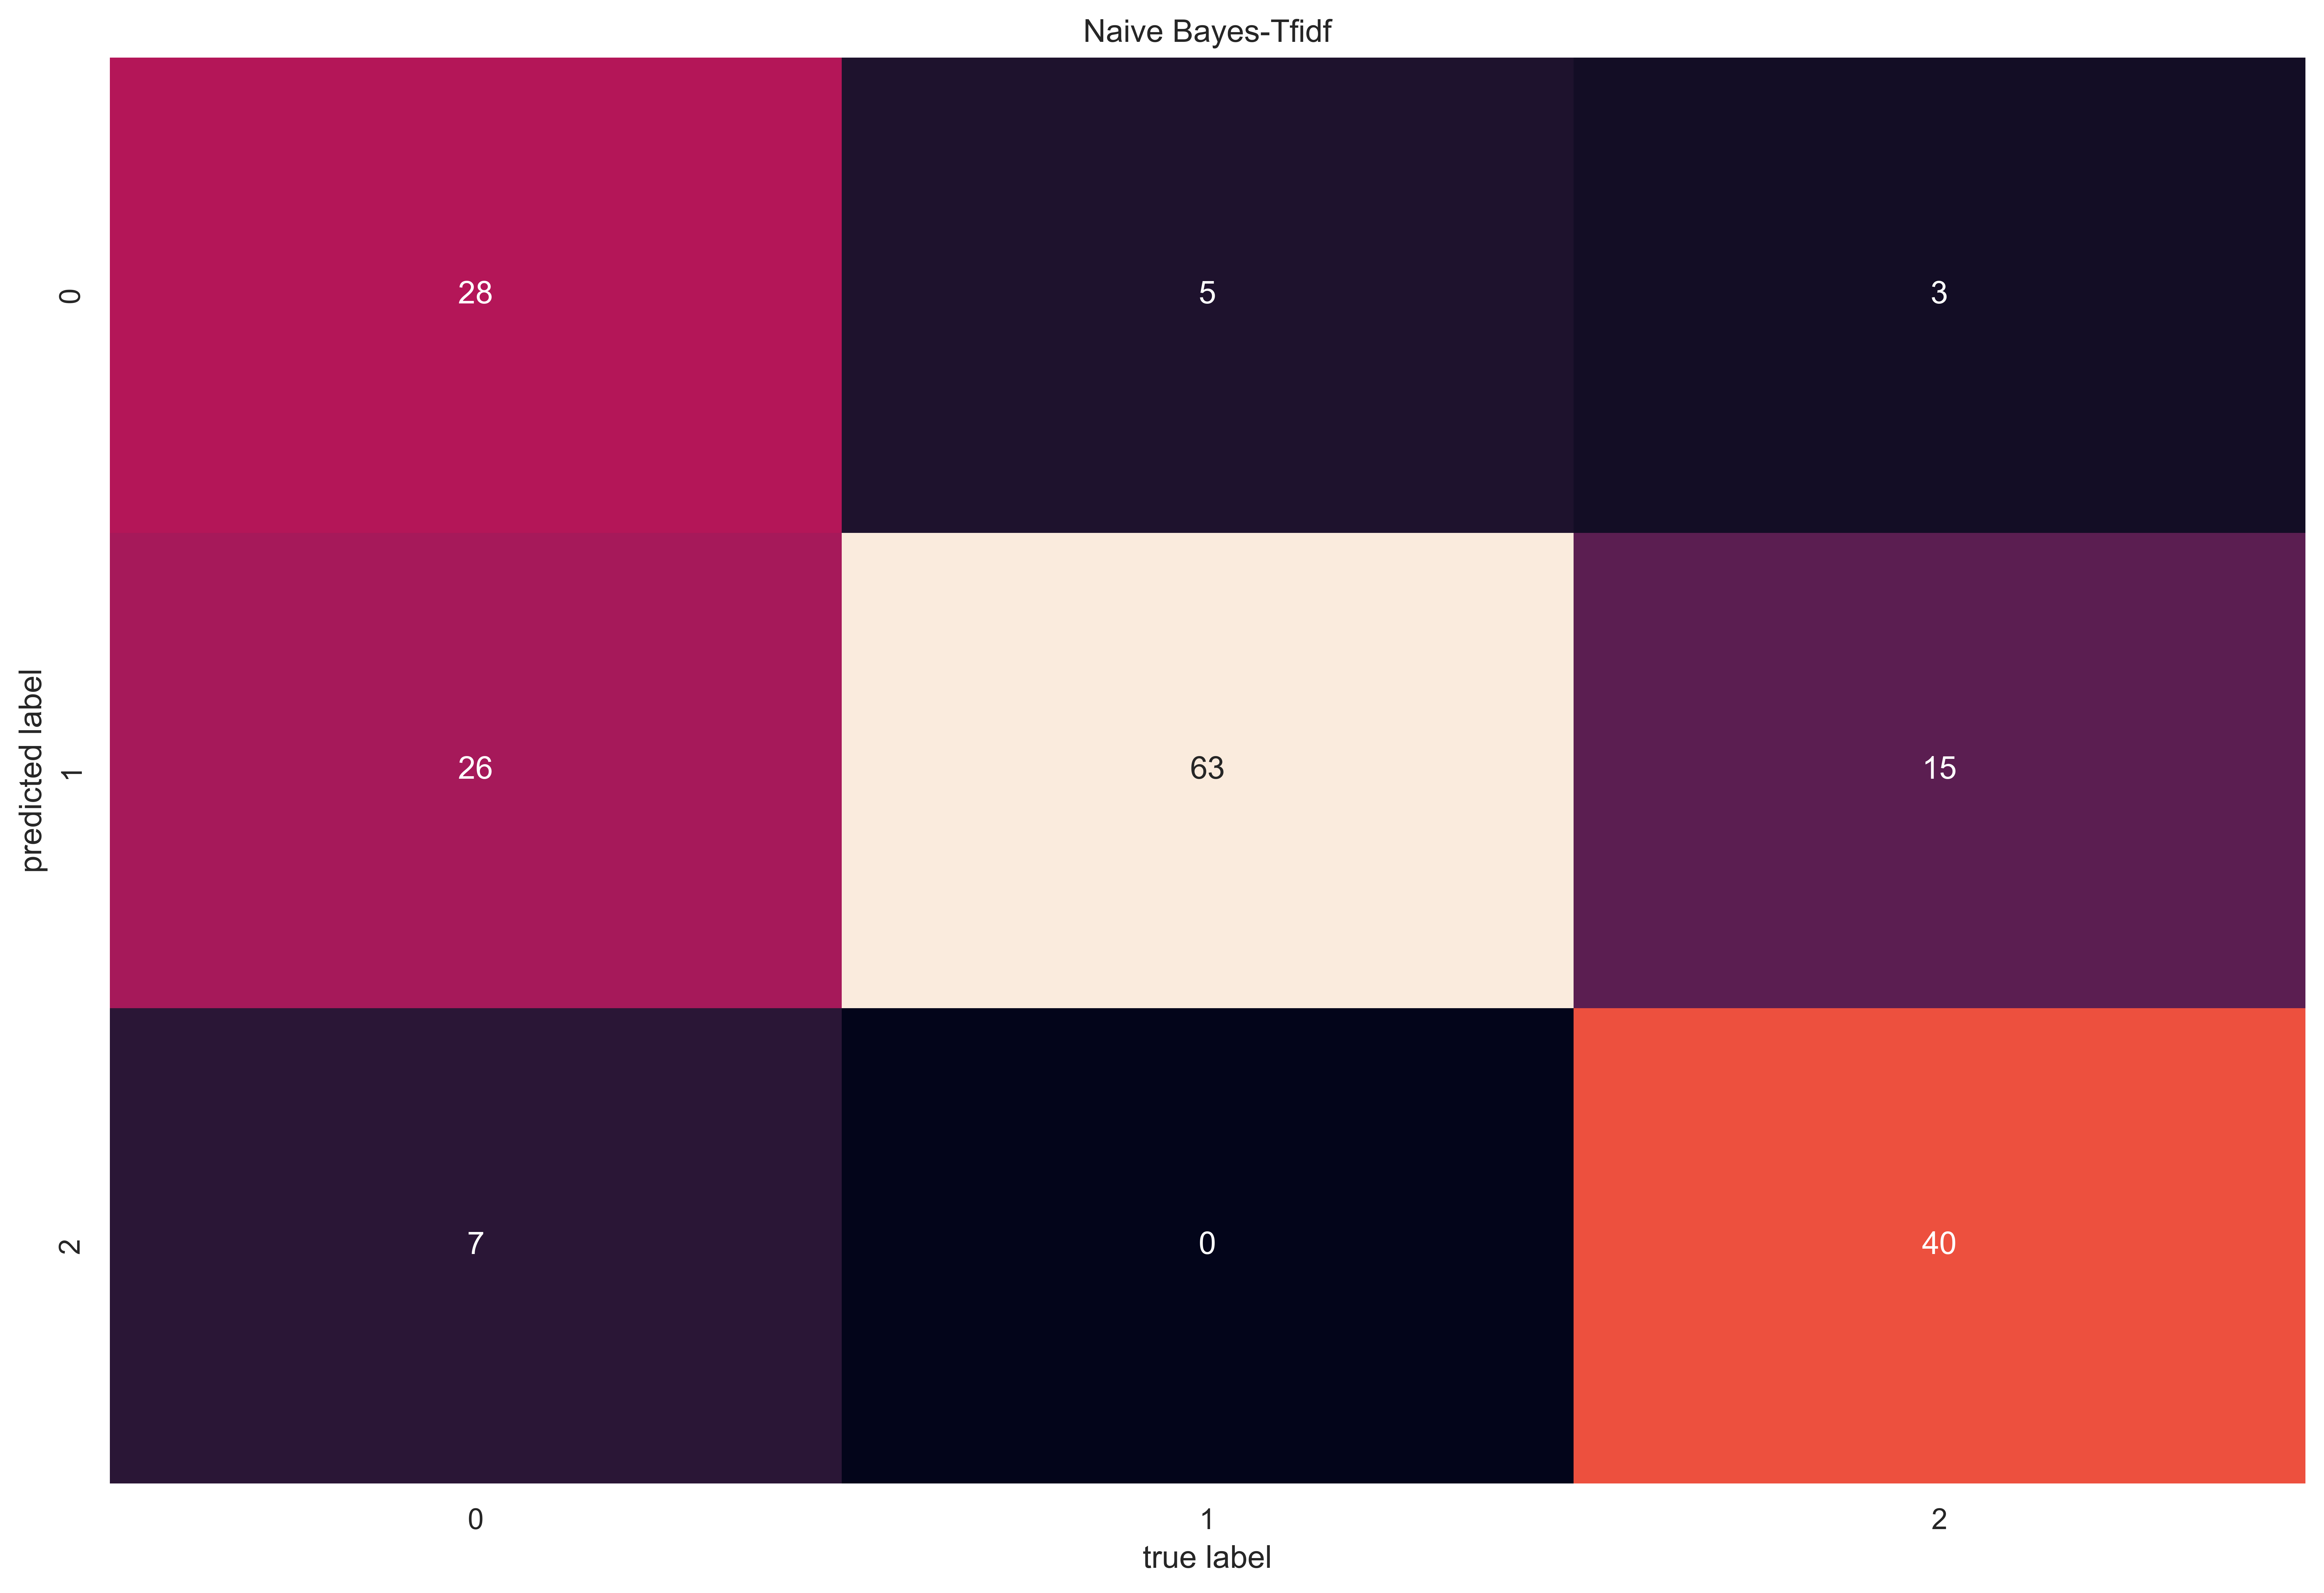

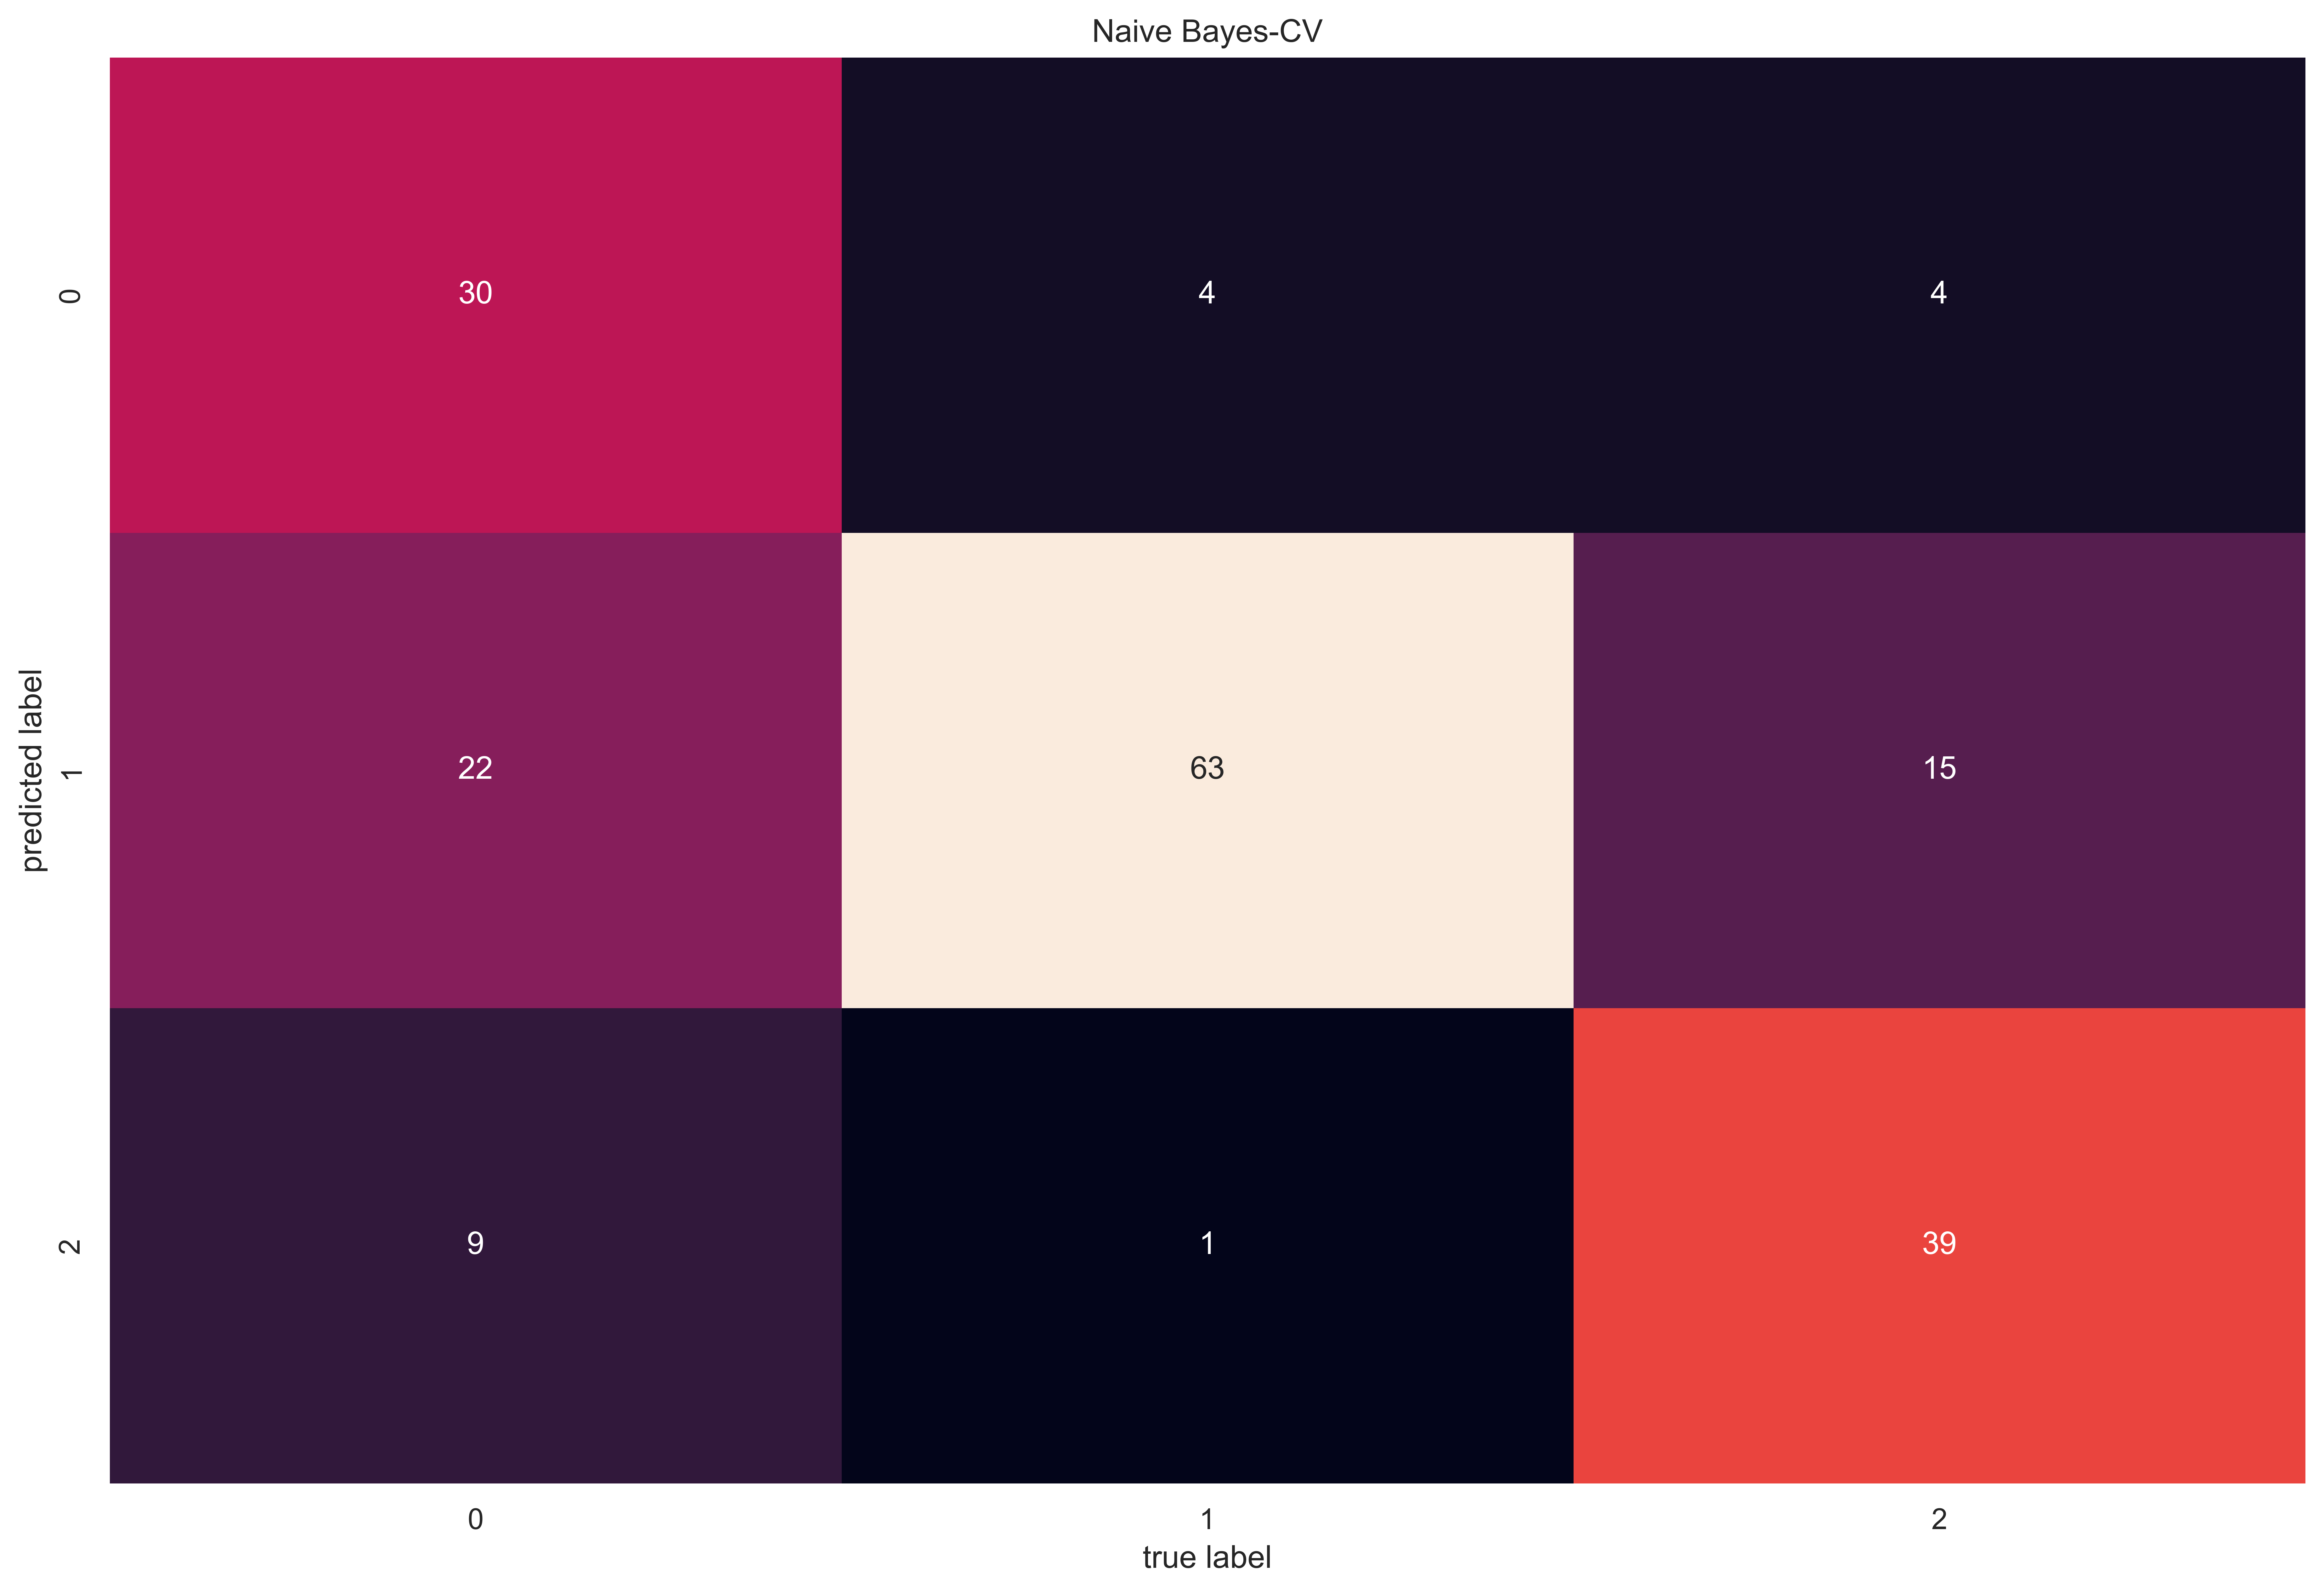

In [128]:
plt.figure(dpi=600)
mat_nb_alpha_tfidf = confusion_matrix(y_test, predicted_naive_tfidf_alpha)
sns.heatmap(mat_nb_alpha_tfidf.T, annot=True, fmt='d', cbar=False)

plt.title('Naive Bayes-Tfidf')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

plt.figure(dpi=600)
mat_nb_alpha_cv = confusion_matrix(y_test, predicted_naive_cv_alpha)
sns.heatmap(mat_nb_alpha_cv.T, annot=True, fmt='d', cbar=False)

plt.title('Naive Bayes-CV')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [129]:
print ('Accuracy:', accuracy_score(y_test, predicted_naive_tfidf_alpha))
print('Precision:',precision_score(y_test, predicted_naive_tfidf_alpha, average=None))
print ('F1 score:', f1_score(y_test, predicted_naive_tfidf_alpha,average=None))
print ('Recall:', recall_score(y_test, predicted_naive_tfidf_alpha,average=None))
print ('Precision:', precision_score(y_test, predicted_naive_tfidf_alpha,average=None))

Accuracy: 0.7005347593582888
Precision: [0.77777778 0.60576923 0.85106383]
F1 score: [0.57731959 0.73255814 0.76190476]
Recall: [0.45901639 0.92647059 0.68965517]
Precision: [0.77777778 0.60576923 0.85106383]


In [130]:
print ('Accuracy:', accuracy_score(y_test, predicted_naive_cv_alpha))
print('Precision:',precision_score(y_test, predicted_naive_cv_alpha, average=None))
print ('F1 score:', f1_score(y_test, predicted_naive_cv_alpha,average=None))
print ('Recall:', recall_score(y_test, predicted_naive_cv_alpha,average=None))
print ('Precision:', precision_score(y_test, predicted_naive_cv_alpha,average=None))

Accuracy: 0.7058823529411765
Precision: [0.78947368 0.63       0.79591837]
F1 score: [0.60606061 0.75       0.72897196]
Recall: [0.49180328 0.92647059 0.67241379]
Precision: [0.78947368 0.63       0.79591837]


In [131]:
scores_tfidf = cross_val_score(model_naive_tfidf_alpha ,X_KFold_tfidf,list(y), cv = 10, scoring='accuracy')
scores_cv = cross_val_score(model_naive_cv_alpha ,X_KFold_cv,list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores_tfidf))
print('Cross-validation scores:{}'.format(scores_cv))

Cross-validation scores:[0.76190476 0.65079365 0.72580645 0.67741935 0.77419355 0.72580645
 0.70967742 0.75806452 0.75806452 0.77419355]
Cross-validation scores:[0.77777778 0.6984127  0.75806452 0.72580645 0.77419355 0.77419355
 0.74193548 0.79032258 0.77419355 0.77419355]


In [132]:
print('Average cross-validation score: {:.4f}'.format(scores_tfidf.mean()))
print('Average cross-validation score: {:.4f}'.format(scores_cv.mean()))

Average cross-validation score: 0.7316
Average cross-validation score: 0.7589


# Naive Bayes-CV: no feature restrictions

In [133]:
vectorizer_nomax= CountVectorizer(binary=False, stop_words='english')
vectorizer_nomax.fit(list(x_train)+list(x_test))
x_train_cv_nomax= vectorizer_nomax.transform(x_train)
x_test_cv_nomax= vectorizer_nomax.transform(x_test)

In [134]:
model_naive = MultinomialNB().fit(x_train_cv_nomax, y_train) 
y_pred_nb_cv_nomax = model_naive.predict(x_test_cv_nomax)

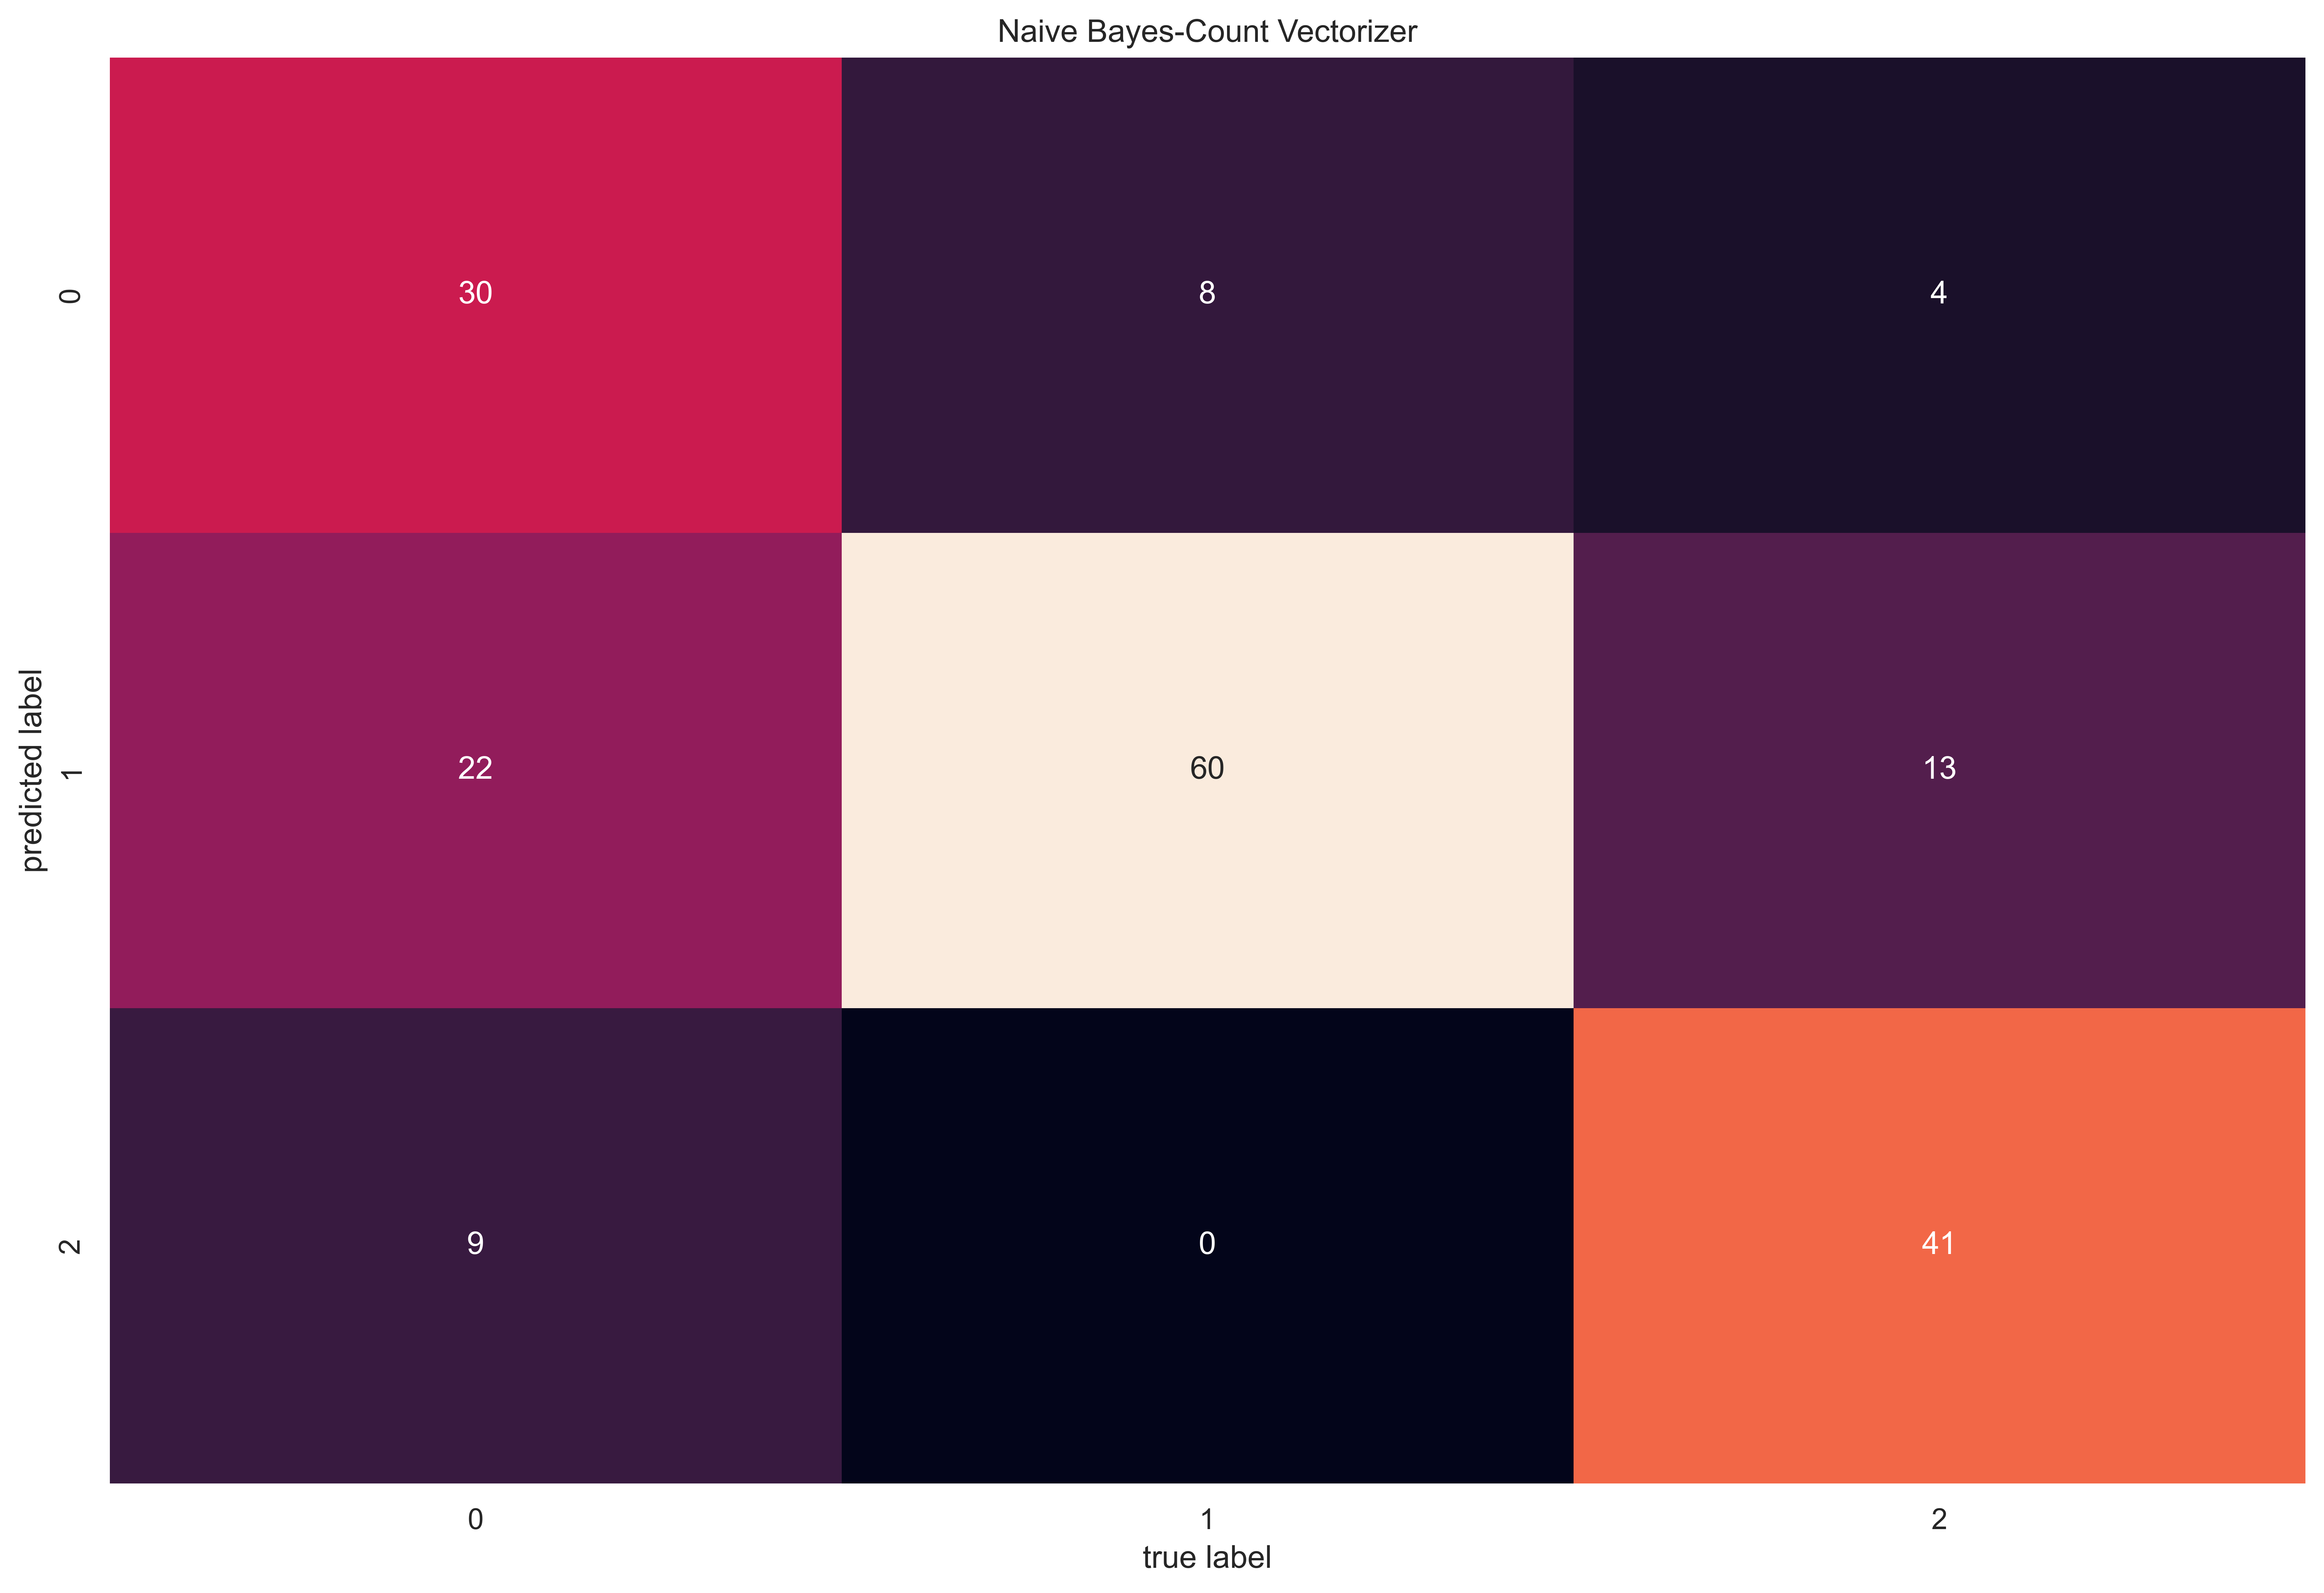

In [135]:
plt.figure(dpi=600)
mat_nb_cv = confusion_matrix(y_test, y_pred_nb_cv_nomax)
sns.heatmap(mat_nb_cv.T, annot=True, fmt='d', cbar=False)
plt.title('Naive Bayes-Count Vectorizer')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



In [136]:
print ('Accuracy:', accuracy_score(y_test, y_pred_nb_cv_nomax))
print('Precision:',precision_score(y_test, y_pred_nb_cv_nomax, average=None))
print ('F1 score:', f1_score(y_test, y_pred_nb_cv_nomax,average=None))
print ('Recall:', recall_score(y_test, y_pred_nb_cv_nomax,average=None))
print ('Precision:', precision_score(y_test,y_pred_nb_cv_nomax,average=None))

Accuracy: 0.7005347593582888
Precision: [0.71428571 0.63157895 0.82      ]
F1 score: [0.58252427 0.73619632 0.75925926]
Recall: [0.49180328 0.88235294 0.70689655]
Precision: [0.71428571 0.63157895 0.82      ]


In [137]:
print(classification_report(y_test, y_pred_nb_cv_nomax, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.71      0.49      0.58        61
           1       0.63      0.88      0.74        68
           2       0.82      0.71      0.76        58

    accuracy                           0.70       187
   macro avg       0.72      0.69      0.69       187
weighted avg       0.72      0.70      0.69       187



In [138]:
scores_nomax = cross_val_score(model_naive ,X_KFold_cv_nomax,list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores_nomax))

Cross-validation scores:[0.77777778 0.61904762 0.69354839 0.69354839 0.74193548 0.72580645
 0.70967742 0.79032258 0.74193548 0.70967742]


In [139]:
print('Average cross-validation score: {:.4f}'.format(scores_nomax.mean()))

Average cross-validation score: 0.7203


# Naive Bayes-TFIDF: no feature restrictions

In [140]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
tfidf_vectorizer.fit(list(x_train)+list(x_test))
x_train_tfidf_nomax = tfidf_vectorizer.transform(x_train)
x_test_tfidf_nomax = tfidf_vectorizer.transform(x_test)

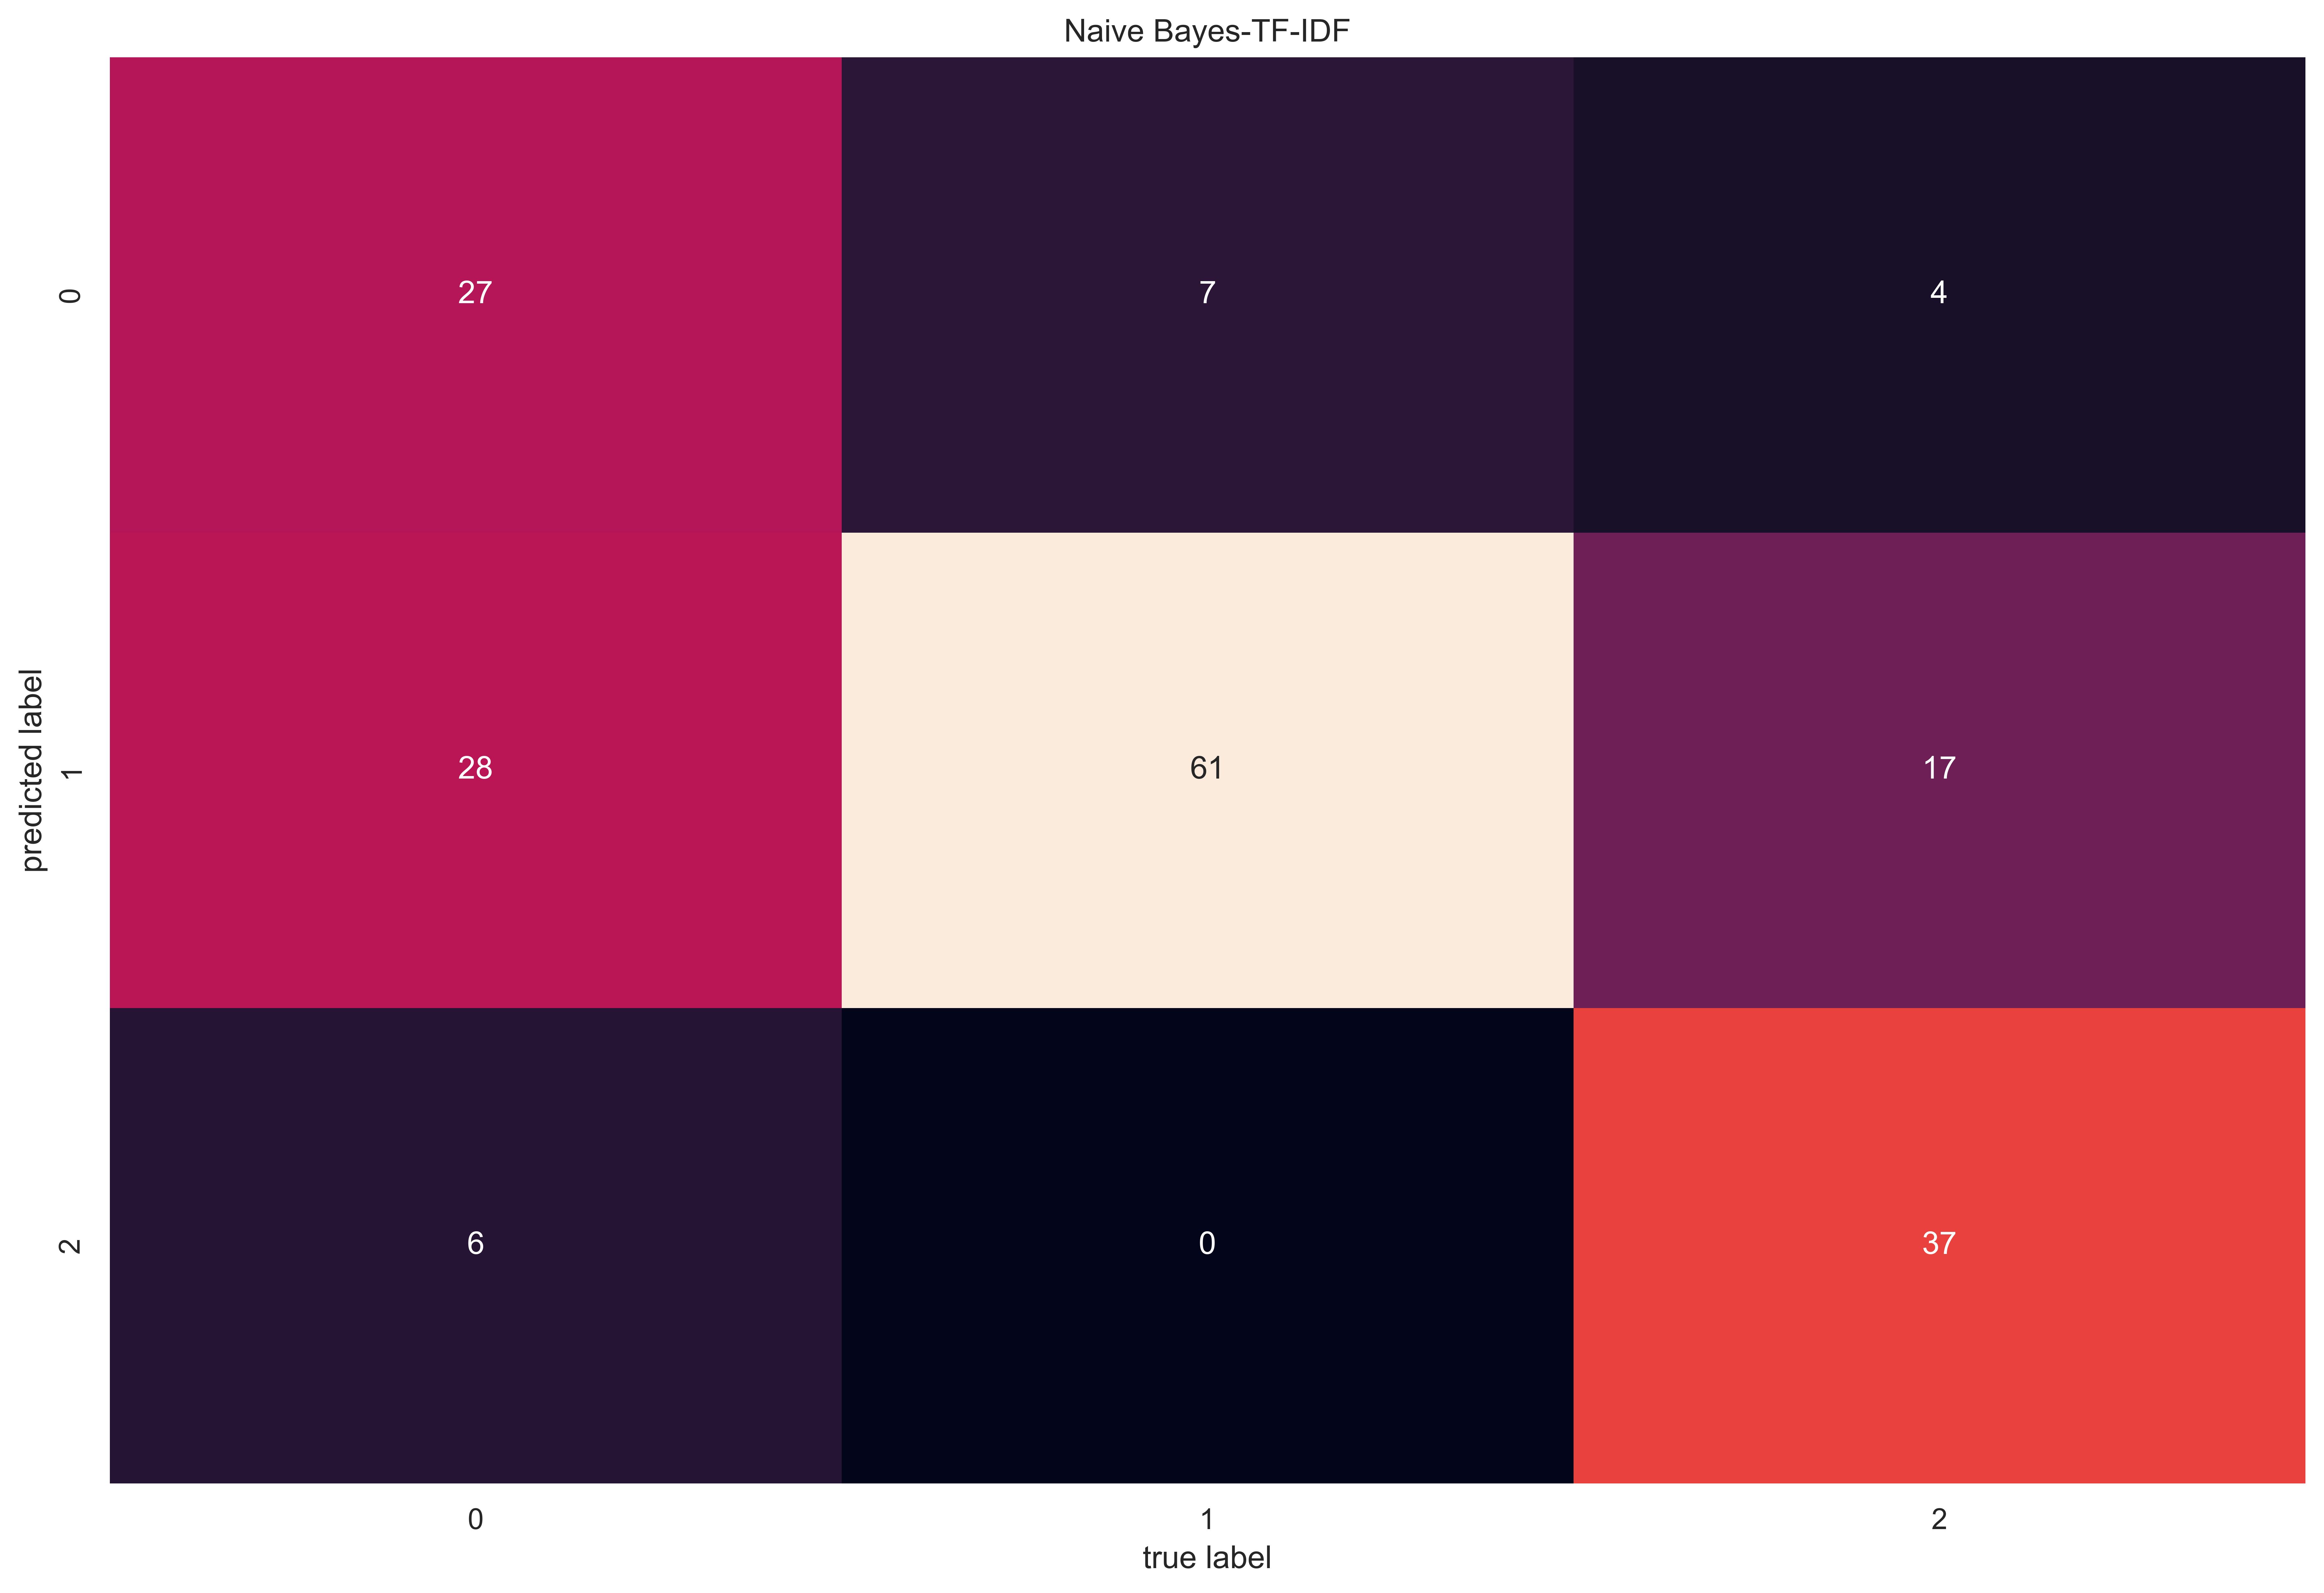

              precision    recall  f1-score   support

           0       0.71      0.44      0.55        61
           1       0.58      0.90      0.70        68
           2       0.86      0.64      0.73        58

    accuracy                           0.67       187
   macro avg       0.72      0.66      0.66       187
weighted avg       0.71      0.67      0.66       187



In [141]:
model_naive_nomax = MultinomialNB().fit(x_train_tfidf_nomax, y_train) 
y_pred_nb_tfidf_nomax = model_naive_nomax.predict(x_test_tfidf_nomax)
plt.figure(dpi=600)
mat_nb_tfidf = confusion_matrix(y_test, y_pred_nb_tfidf_nomax)

sns.heatmap(mat_nb_tfidf.T, annot=True, fmt='d', cbar=False)

plt.title('Naive Bayes-TF-IDF')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred_nb_tfidf_nomax, labels=[0, 1, 2]))

In [143]:
print ('Accuracy:', accuracy_score(y_test, y_pred_nb_tfidf_nomax))
print('Precision:',precision_score(y_test, y_pred_nb_tfidf_nomax, average=None))
print ('F1 score:', f1_score(y_test, y_pred_nb_tfidf_nomax,average=None))
print ('Recall:', recall_score(y_test, y_pred_nb_tfidf_nomax,average=None))
print ('Precision:', precision_score(y_test,y_pred_nb_tfidf_nomax,average=None))

Accuracy: 0.6684491978609626
Precision: [0.71052632 0.5754717  0.86046512]
F1 score: [0.54545455 0.70114943 0.73267327]
Recall: [0.44262295 0.89705882 0.63793103]
Precision: [0.71052632 0.5754717  0.86046512]


In [144]:
scores_nomax = cross_val_score(model_naive_nomax,X_KFold_tfidf_nomax,list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores_nomax))

Cross-validation scores:[0.74603175 0.61904762 0.59677419 0.67741935 0.75806452 0.64516129
 0.67741935 0.74193548 0.70967742 0.75806452]


In [145]:
print('Average cross-validation score: {:.4f}'.format(scores_nomax.mean()))

Average cross-validation score: 0.6930


# KNN -CV: cosine distance, max. 500 features

In [146]:
classifier_KNN= KNeighborsClassifier(n_neighbors=13, p=3, metric='cosine')

#x_train_cv = vectorizer.transform(x_train)
#x_test_cv = vectorizer.transform(x_test)

In [147]:
math.sqrt((len(y_test)))

13.674794331177344

In [148]:
classifier_KNN.fit(x_train_cv, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=13, p=3)

In [149]:
y_pred_KNN_cv= classifier_KNN.predict(x_test_cv)

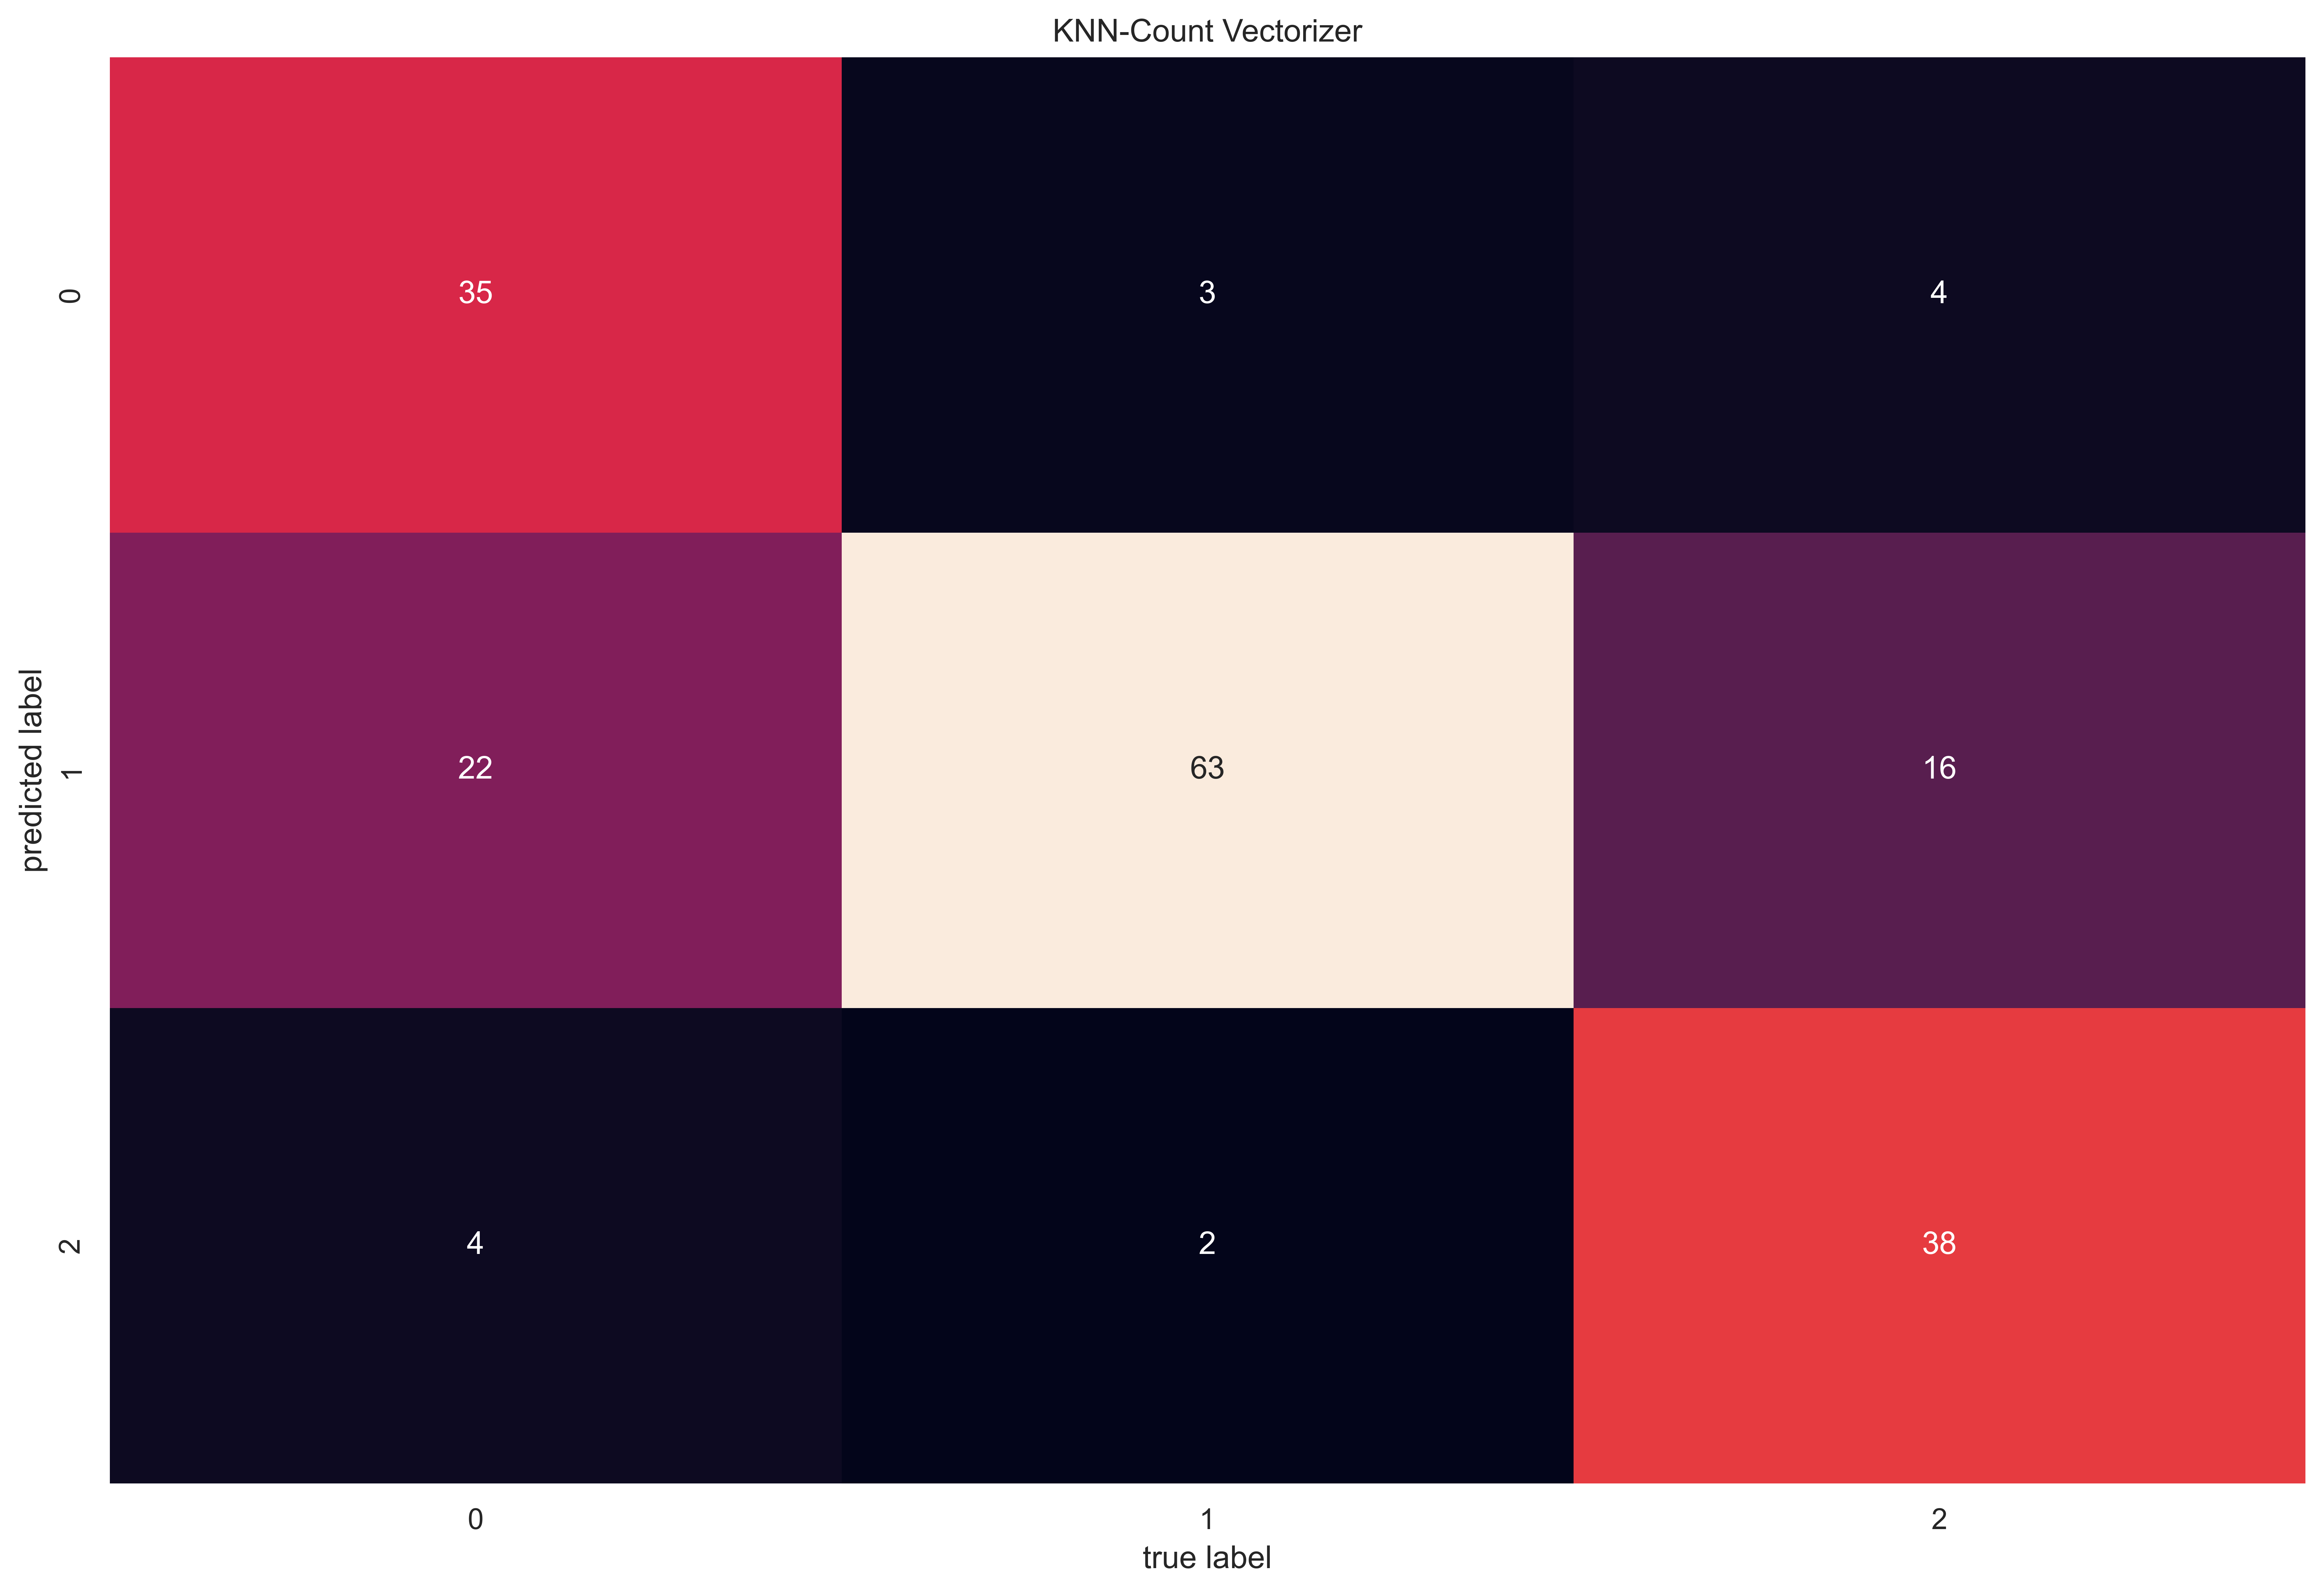

In [150]:
plt.figure(dpi=600)
cm_KNN_cv = confusion_matrix(y_test, y_pred_KNN_cv)
sns.heatmap(cm_KNN_cv.T, annot=True, fmt='d', cbar=False)
plt.title('KNN-Count Vectorizer')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [151]:
print ('Accuracy:', accuracy_score(y_test, y_pred_KNN_cv))
print('Precision:',precision_score(y_test, y_pred_KNN_cv, average=None))
print ('F1 score:', f1_score(y_test, y_pred_KNN_cv,average=None))
print ('Recall:', recall_score(y_test, y_pred_KNN_cv,average=None))
print ('Precision:', precision_score(y_test,y_pred_KNN_cv,average=None))

Accuracy: 0.7272727272727273
Precision: [0.83333333 0.62376238 0.86363636]
F1 score: [0.67961165 0.74556213 0.74509804]
Recall: [0.57377049 0.92647059 0.65517241]
Precision: [0.83333333 0.62376238 0.86363636]


In [152]:
print(classification_report(y_test, y_pred_KNN_cv, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.83      0.57      0.68        61
           1       0.62      0.93      0.75        68
           2       0.86      0.66      0.75        58

    accuracy                           0.73       187
   macro avg       0.77      0.72      0.72       187
weighted avg       0.77      0.73      0.72       187



In [153]:
scores = cross_val_score(classifier_KNN, X_KFold_cv, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.74603175 0.77777778 0.77419355 0.67741935 0.75806452 0.72580645
 0.72580645 0.74193548 0.75806452 0.75806452]


In [154]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7443


# KNN-TFIDF: cosine distance, max. 500 features

In [155]:
classifier_KNN= KNeighborsClassifier(n_neighbors=13, p=3, metric='cosine')

In [156]:
math.sqrt((len(y_test)))

13.674794331177344

In [157]:
classifier_KNN.fit(x_train_tfidf, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=13, p=3)

In [158]:
y_pred_KNN_tfidf= classifier_KNN.predict(x_test_tfidf)

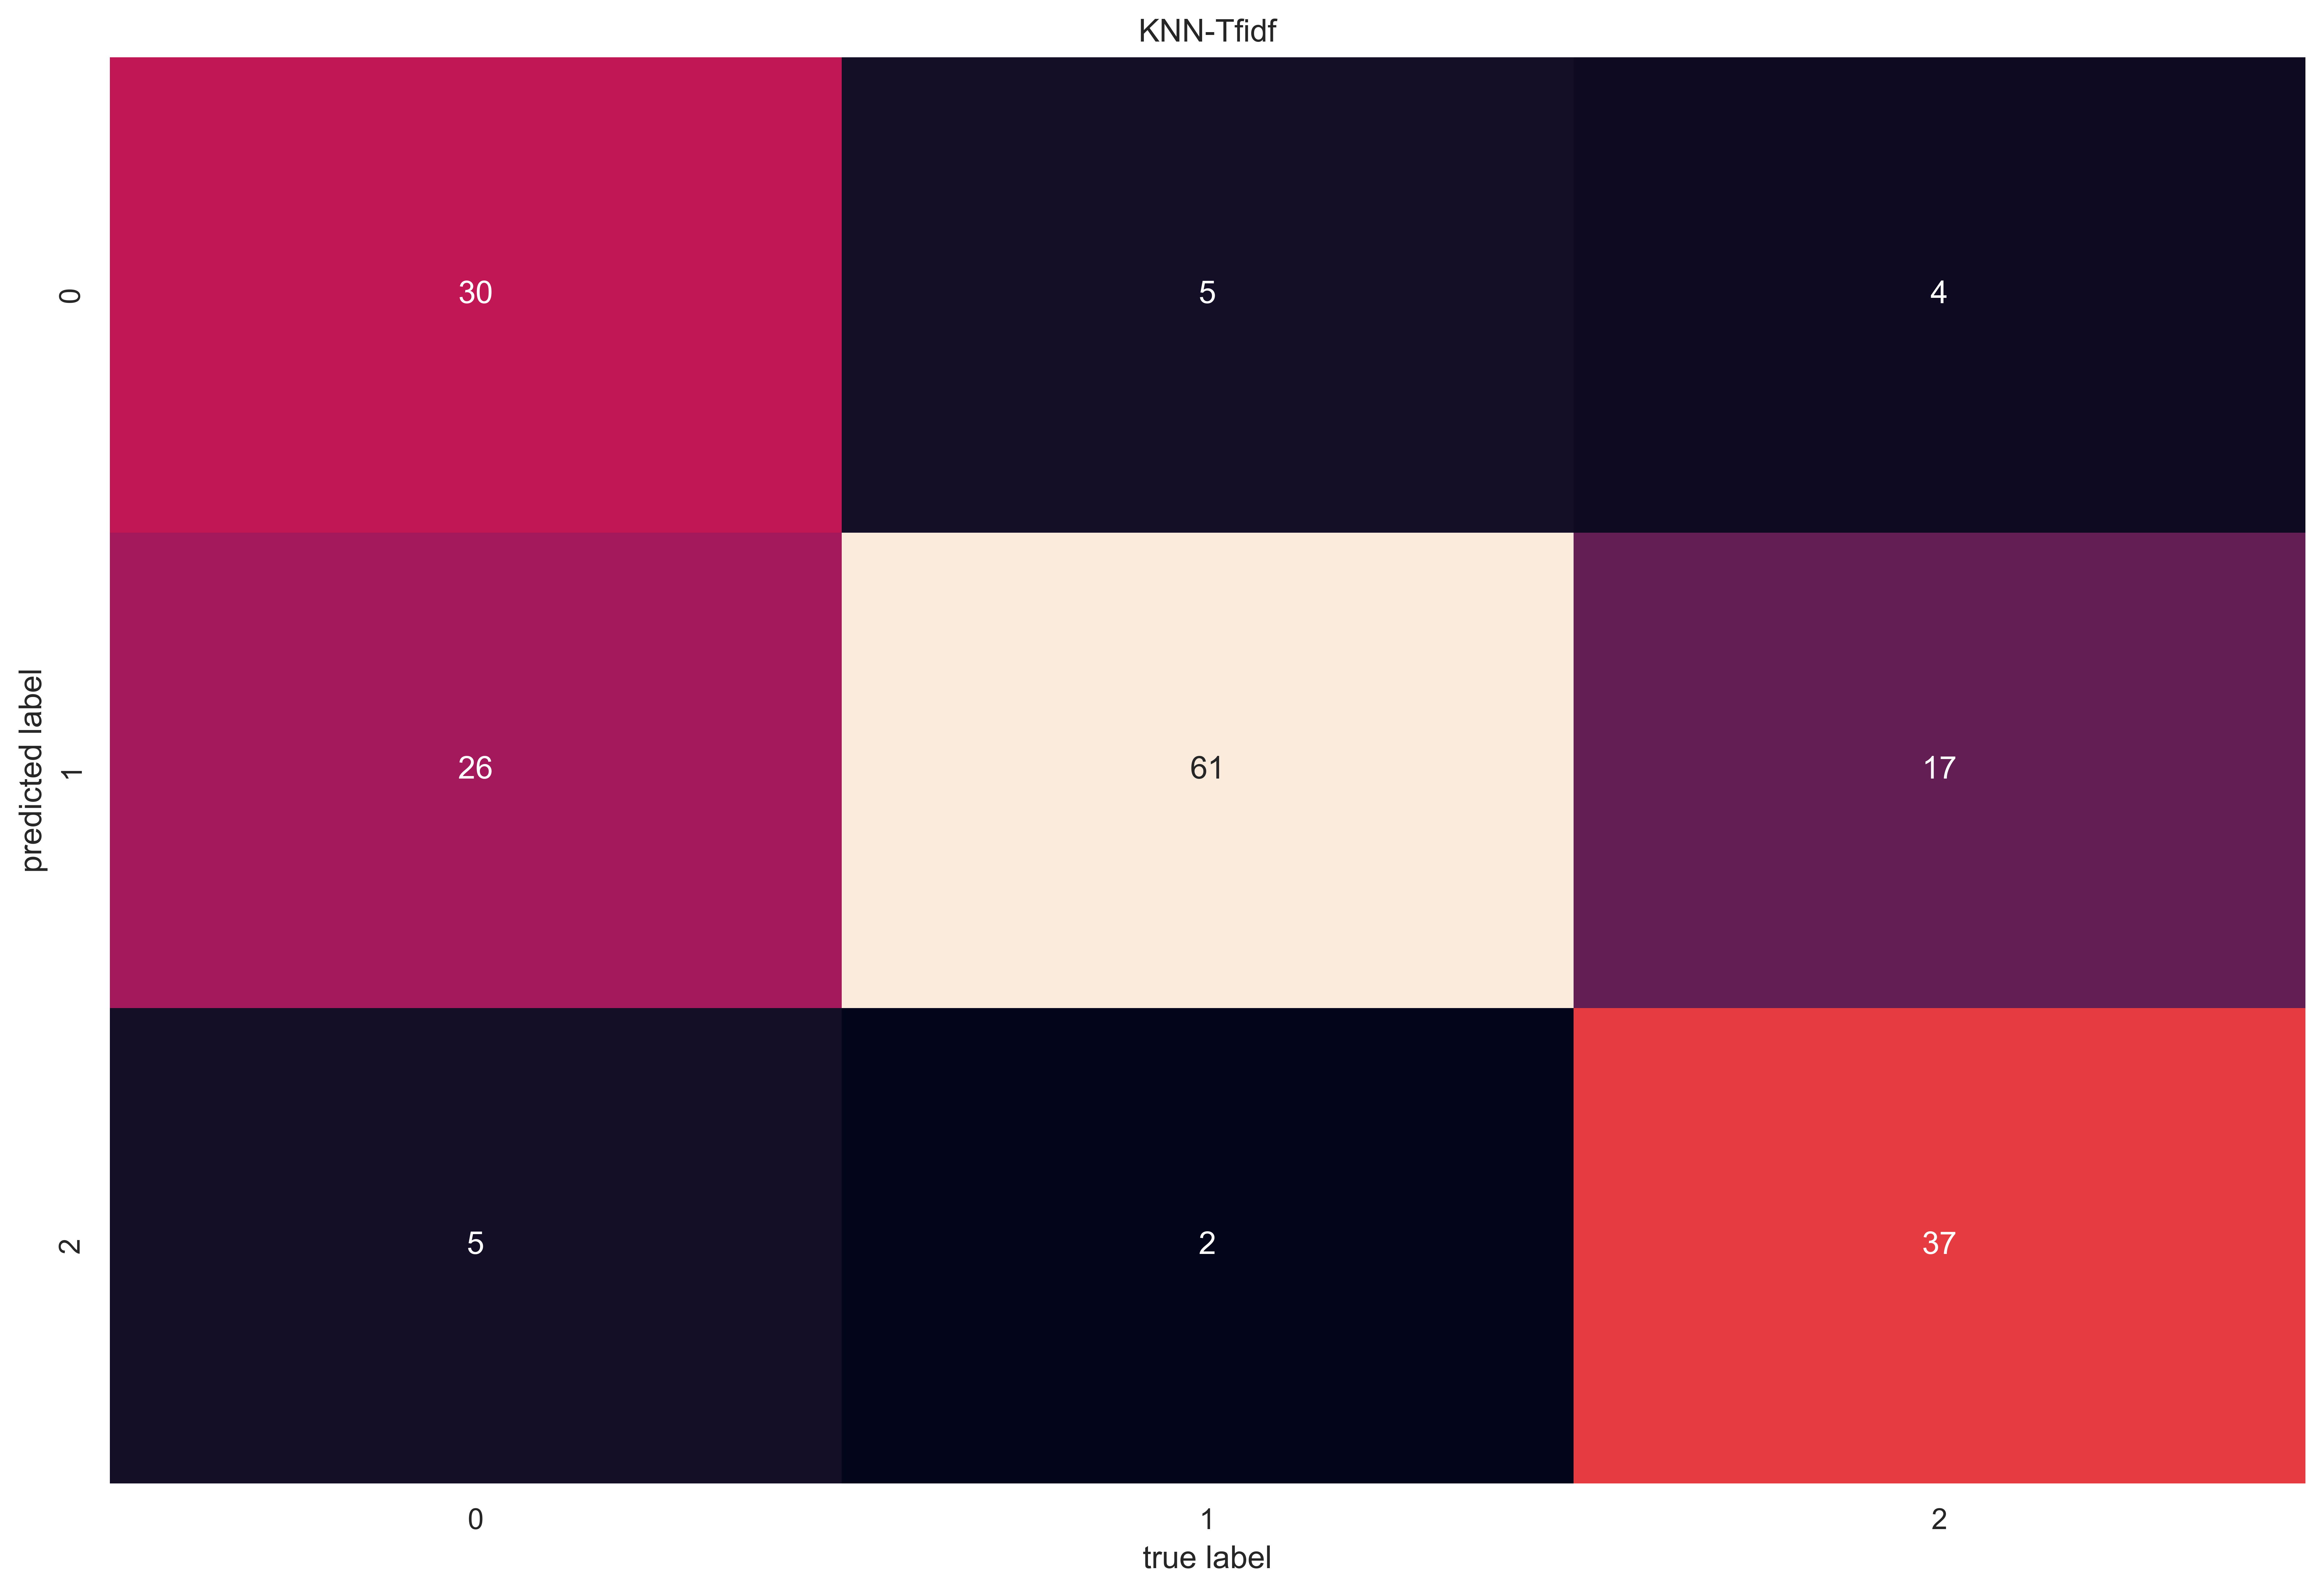

In [159]:
plt.figure(dpi=600)
cm_KNN_tfidf= confusion_matrix(y_test, y_pred_KNN_tfidf)
sns.heatmap(cm_KNN_tfidf.T, annot=True, fmt='d', cbar=False)
plt.title('KNN-Tfidf')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [160]:
print ('Accuracy:', accuracy_score(y_test, y_pred_KNN_tfidf))
print('Precision:',precision_score(y_test, y_pred_KNN_tfidf, average=None))
print ('F1 score:', f1_score(y_test, y_pred_KNN_tfidf,average=None))
print ('Recall:', recall_score(y_test, y_pred_KNN_tfidf,average=None))
print ('Precision:', precision_score(y_test,y_pred_KNN_tfidf,average=None))

Accuracy: 0.6844919786096256
Precision: [0.76923077 0.58653846 0.84090909]
F1 score: [0.6        0.70930233 0.7254902 ]
Recall: [0.49180328 0.89705882 0.63793103]
Precision: [0.76923077 0.58653846 0.84090909]


In [161]:
print(classification_report(y_test, y_pred_KNN_tfidf, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.77      0.49      0.60        61
           1       0.59      0.90      0.71        68
           2       0.84      0.64      0.73        58

    accuracy                           0.68       187
   macro avg       0.73      0.68      0.68       187
weighted avg       0.73      0.68      0.68       187



In [162]:
scores = cross_val_score(classifier_KNN, X_KFold_tfidf, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.74603175 0.71428571 0.74193548 0.61290323 0.77419355 0.79032258
 0.67741935 0.70967742 0.69354839 0.67741935]


In [163]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7138


# GradientBoosting-CV: 20 estimators, depth = 250, max. 500 features

In [164]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_depth=250, random_state=0)
    gb_clf.fit(x_train_cv, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(x_train_cv, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(x_test_cv, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.991
Accuracy score (test): 0.706
Learning rate:  0.075
Accuracy score (training): 0.991
Accuracy score (test): 0.706
Learning rate:  0.1
Accuracy score (training): 0.991
Accuracy score (test): 0.711
Learning rate:  0.25
Accuracy score (training): 0.991
Accuracy score (test): 0.706
Learning rate:  0.5
Accuracy score (training): 0.991
Accuracy score (test): 0.717
Learning rate:  0.75
Accuracy score (training): 0.991
Accuracy score (test): 0.743
Learning rate:  1
Accuracy score (training): 0.991
Accuracy score (test): 0.759


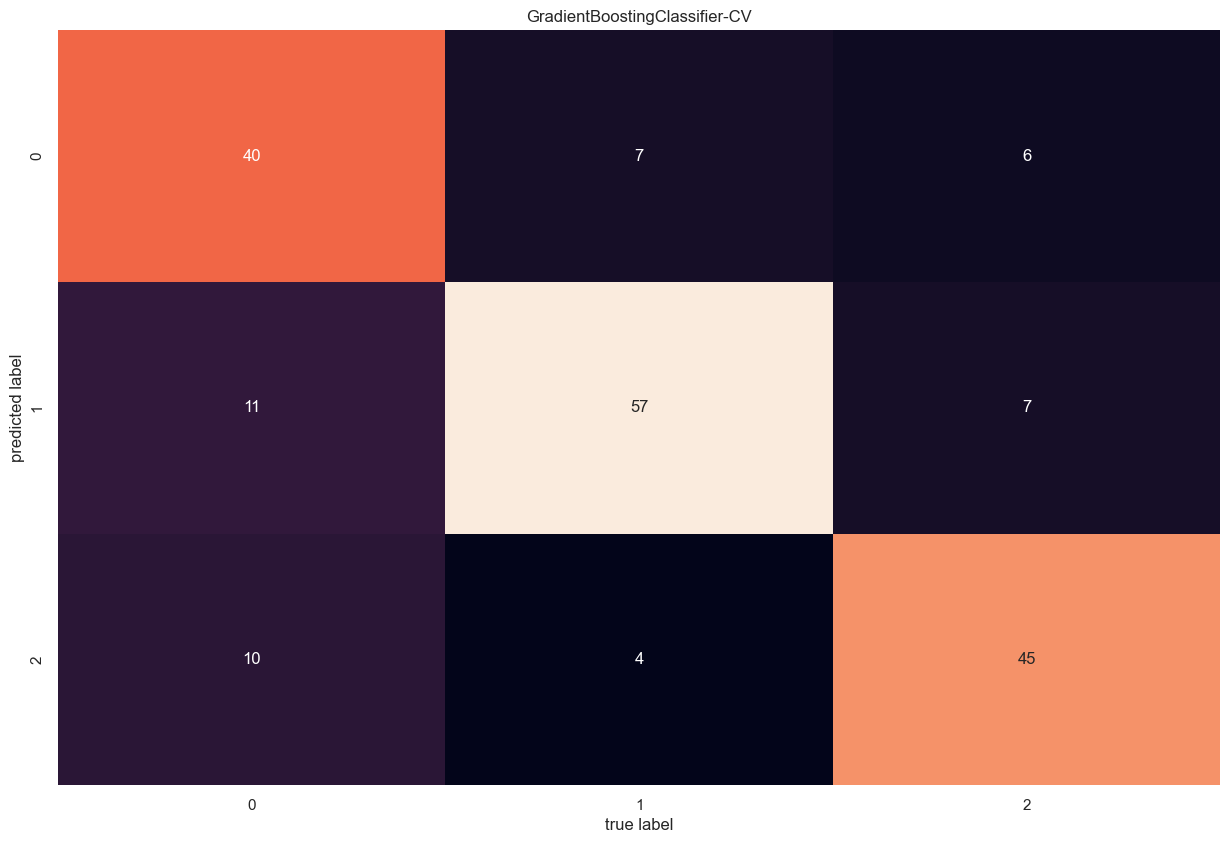

In [165]:
predicted_gbc_cv = gb_clf.predict(x_test_cv)

plt.figure(dpi=100)
mat_gbc = confusion_matrix(y_test, predicted_gbc_cv)
sns.heatmap(mat_gbc.T, annot=True, fmt='d', cbar=False)

plt.title('GradientBoostingClassifier-CV')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [166]:
print ('Accuracy:', accuracy_score(y_test, predicted_gbc_cv))
print('Precision:',precision_score(y_test, predicted_gbc_cv, average=None))
print ('F1 score:', f1_score(y_test, predicted_gbc_cv,average=None))
print ('Recall:', recall_score(y_test, predicted_gbc_cv,average=None))
print ('Precision:', precision_score(y_test,predicted_gbc_cv,average=None))

Accuracy: 0.7593582887700535
Precision: [0.75471698 0.76       0.76271186]
F1 score: [0.70175439 0.7972028  0.76923077]
Recall: [0.6557377  0.83823529 0.77586207]
Precision: [0.75471698 0.76       0.76271186]


In [167]:
print(classification_report(y_test, predicted_gbc_cv, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70        61
           1       0.76      0.84      0.80        68
           2       0.76      0.78      0.77        58

    accuracy                           0.76       187
   macro avg       0.76      0.76      0.76       187
weighted avg       0.76      0.76      0.76       187



In [168]:
scores = cross_val_score(gb_clf, X_KFold_cv, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.80952381 0.84126984 0.64516129 0.70967742 0.74193548 0.82258065
 0.80645161 0.82258065 0.74193548 0.75806452]


In [169]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7699


# GradientBoosting-TFIDF: 20 estimators, depth = 250, max. 500 features

In [170]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_depth=250, random_state=0)
    gb_clf.fit(x_train_tfidf, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(x_train_tfidf, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(x_test_tfidf, y_test)))


Learning rate:  0.05
Accuracy score (training): 0.991
Accuracy score (test): 0.727
Learning rate:  0.075
Accuracy score (training): 0.991
Accuracy score (test): 0.727
Learning rate:  0.1
Accuracy score (training): 0.991
Accuracy score (test): 0.727
Learning rate:  0.25
Accuracy score (training): 0.991
Accuracy score (test): 0.733
Learning rate:  0.5
Accuracy score (training): 0.991
Accuracy score (test): 0.722
Learning rate:  0.75
Accuracy score (training): 0.991
Accuracy score (test): 0.743
Learning rate:  1
Accuracy score (training): 0.991
Accuracy score (test): 0.754


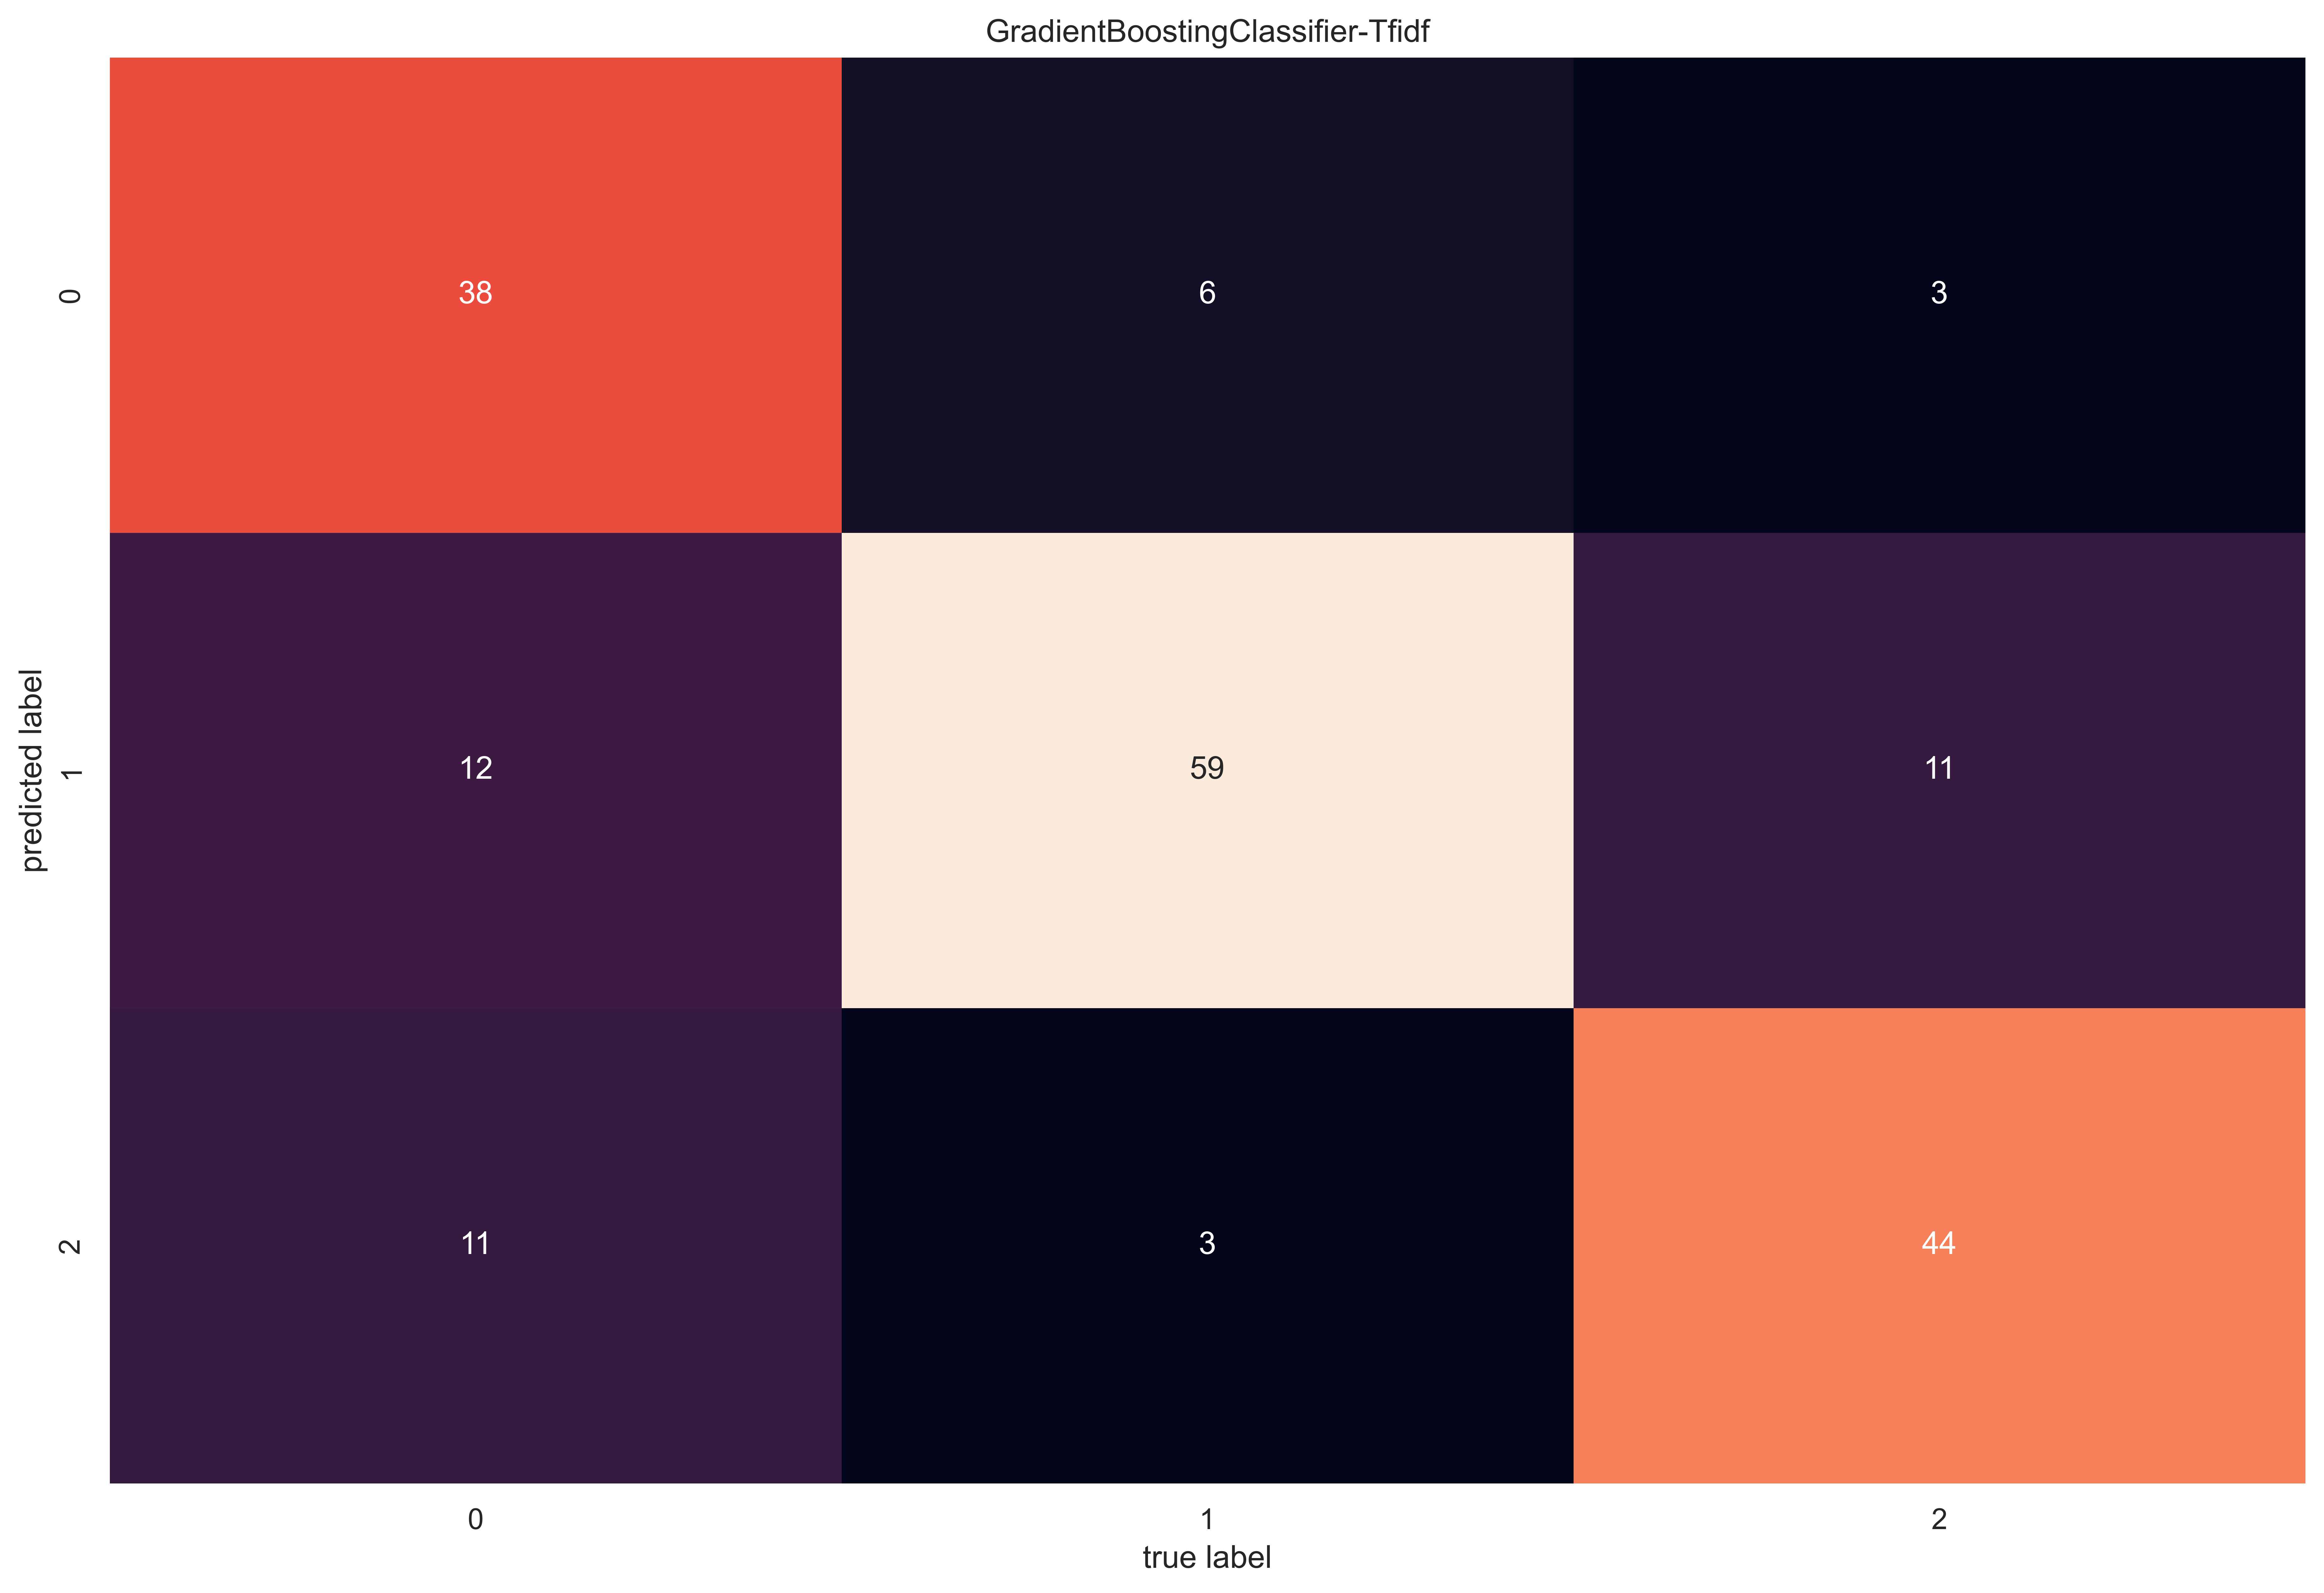

In [171]:
predicted_gbc_tfidf = gb_clf.predict(x_test_tfidf)

plt.figure(dpi=600)
mat_gbc = confusion_matrix(y_test, predicted_gbc_tfidf)
sns.heatmap(mat_gbc.T, annot=True, fmt='d', cbar=False)

plt.title('GradientBoostingClassifier-Tfidf')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [172]:
print ('Accuracy:', accuracy_score(y_test, predicted_gbc_tfidf))
print('Precision:',precision_score(y_test, predicted_gbc_tfidf, average=None))
print ('F1 score:', f1_score(y_test, predicted_gbc_tfidf,average=None))
print ('Recall:', recall_score(y_test, predicted_gbc_tfidf,average=None))
print ('Precision:', precision_score(y_test,predicted_gbc_tfidf,average=None))

Accuracy: 0.7540106951871658
Precision: [0.80851064 0.7195122  0.75862069]
F1 score: [0.7037037  0.78666667 0.75862069]
Recall: [0.62295082 0.86764706 0.75862069]
Precision: [0.80851064 0.7195122  0.75862069]


In [173]:
print(classification_report(y_test, predicted_gbc_tfidf, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.81      0.62      0.70        61
           1       0.72      0.87      0.79        68
           2       0.76      0.76      0.76        58

    accuracy                           0.75       187
   macro avg       0.76      0.75      0.75       187
weighted avg       0.76      0.75      0.75       187



In [174]:
scores = cross_val_score(gb_clf, X_KFold_tfidf, list(y), cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.82539683 0.77777778 0.64516129 0.69354839 0.75806452 0.79032258
 0.79032258 0.79032258 0.77419355 0.79032258]


In [175]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7635
